In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

# Location: 101 Cypress

In [2]:
file_name = './2023-01-04 Cypress 101/Data/101 Cypress - Device Event Detail (raw data).xlsx'
xl_file = pd.ExcelFile(file_name)

dfs = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}
df_event_detail = dfs['Data']
df_event_detail = df_event_detail.drop(axis=1, columns=[' '])
dict1 = {}
for column in df_event_detail.columns:
    dict1[column] = column.strip()
df_event_detail = df_event_detail.rename(columns=dict1)

df_event_detail['Timestamp'] = df_event_detail['Timestamp'].apply(lambda x: x.strip())
df_event_detail['Category'] = df_event_detail['Category'].apply(lambda x: x.strip())
df_event_detail['Type'] = df_event_detail['Type'].apply(lambda x: x.strip())
df_event_detail['Timestamp'] = pd.to_datetime(df_event_detail['Timestamp'])
df_event_detail = df_event_detail.rename(columns={'Event Value':'Event_value'})

In [5]:
def plot_function(df_main,t):
    df_event_detail = df_main.copy(deep=True)
    df_gr = pd.DataFrame({'Aggregate ramp metering rate':df_event_detail.query('Type == "Ramp Meter - Lane 1 Active Rate"').groupby([pd.Grouper(key='Timestamp',freq='{}min'.format(t)),'Type']).Event_value.mean()}).reset_index()
    df_gr2 = pd.DataFrame({'Aggregate Mainline num vehicles':df_event_detail.query('Type == "Detector On" & Event_value==11').groupby([pd.Grouper(key='Timestamp',freq='{}min'.format(t)),'Type']).Event_value.count()}).reset_index()
    df_gr2['Aggregate Mainline flow rate'] = df_gr2['Aggregate Mainline num vehicles'].apply(lambda x: x*(60/t))
    df_gr4 = pd.DataFrame({'Aggregate Ramp Demand num vehicles':df_event_detail.query('Type == "Detector On" & Event_value==21').groupby([pd.Grouper(key='Timestamp',freq='{}min'.format(t)),'Type']).Event_value.count()}).reset_index()
    df_gr4['Aggregate Ramp Demand flow rate'] = df_gr4['Aggregate Ramp Demand num vehicles'].apply(lambda x: x*(60/t))
    df_gr5 = pd.DataFrame({'Aggregate Ramp Passage num vehicles':df_event_detail.query('Type == "Detector On" & Event_value==23').groupby([pd.Grouper(key='Timestamp',freq='{}min'.format(t)),'Type']).Event_value.count()}).reset_index()
    df_gr5['Aggregate Ramp Passage flow rate'] = df_gr5['Aggregate Ramp Passage num vehicles'].apply(lambda x: x*(60/t))

    df_green_time_estimation = df_event_detail.loc[(df_event_detail['Type']=='Ramp Meter - Begin Green') | (df_event_detail['Type']=='Ramp Meter - Begin Red')].reset_index(drop=True)


    def green_time_calculator(df,start,end):
        total_green_time = 0
        start_time = 0
        end_time = 0
        for i in range(len(df)):
            if df['Type'][i] == 'Ramp Meter - Begin Red':
                start_time = df['Timestamp'][i]
            else:
                if start_time != 0:
                    end_time = df['Timestamp'][i]
                    total_green_time += (start_time - end_time).total_seconds()

        #If last event is Begin Red, add green time from start till first event
        if df['Type'][len(df)-1] == 'Ramp Meter - Begin Red':
            total_green_time += (df['Timestamp'][len(df)-1] - start).total_seconds()

        #If first event is Begin Green, add green time from last event till end
        if df['Type'][0] == 'Ramp Meter - Begin Green':
            total_green_time += (end - df['Timestamp'][0]).total_seconds()

        return(total_green_time)


    green_time_array = []
    all_start_timestamps = np.array(df_gr2['Timestamp'])
    for i in range(len(df_gr2)):
        s = df_gr2['Timestamp'][i]
        e = df_gr2['Timestamp'][i] + datetime.timedelta(minutes=t)
        df = df_green_time_estimation.loc[(df_green_time_estimation['Timestamp']>= df_gr2['Timestamp'][i])& (df_green_time_estimation['Timestamp']< df_gr2['Timestamp'][i]+datetime.timedelta(minutes=t))].reset_index(drop=True)
        if len(df)==0:
            green_time_array.append(0)
        else:
            green_time_array.append(green_time_calculator(df,s,e))
            
    df_gr3 = pd.DataFrame()
    df_gr3['Timestamp'] = all_start_timestamps
    df_gr3['Green_time'] = green_time_array
    print(df_gr)
    print(df_gr2)
    print(df_gr3)
    print(df_gr4)
    print(df_gr5)
    print('*************************************{} Minute Aggregate******************************'.format(t))
    
    fig, ax = plt.subplots(5,1)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    ax[0].step(df_gr2['Timestamp'],df_gr2['Aggregate Mainline flow rate'],color='blue')
    ax[0].set_xlabel('Timestamp')
    ax[0].set_ylabel('Mainline flow rate')
    #ax[0].legend(['Mainline flow rate from Detector 11'])
    ax[0].set_xticks(df_gr2['Timestamp'],df_gr2['Timestamp'],rotation=45)
    ax[0].text(0.1, 0.1, 'Detector 11', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
    ax[0].text(0.1, 0.2, '{} Minute Aggregate'.format(t), horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
    #ax2.text(0.9, 0.5, 'End text', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
    

    ax[1].step(df_gr4['Timestamp'],df_gr4['Aggregate Ramp Demand flow rate'],color='orange')
    ax[1].set_xlabel('Timestamp')
    ax[1].set_ylabel('Ramp Demand flow rate')
    ax[1].set_ylim(0,800)
    #ax[1].legend(['Ramp Demand flow rate from Detector 21'])
    ax[1].set_xticks(df_gr4['Timestamp'],df_gr4['Timestamp'],rotation=45)
    ax[1].text(0.1, 0.1, 'Detector 21', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)
    ax[1].text(0.1, 0.2, '{} Minute Aggregate'.format(t), horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)



    ax[2].step(df_gr5['Timestamp'],df_gr5['Aggregate Ramp Passage flow rate'],color='red')
    ax[2].set_xlabel('Timestamp')
    ax[2].set_ylabel('Ramp Passage flow rate')
    ax[2].set_ylim(0,800)
    #ax[2].legend(['Ramp Passage flow rate from Detector 23'])
    ax[2].set_xticks(df_gr4['Timestamp'],df_gr4['Timestamp'],rotation=45)
    ax[2].text(0.1, 0.1, 'Detector 23', horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes)
    ax[2].text(0.1, 0.2, '{} Minute Aggregate'.format(t), horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes)


    ax[3].step(df_gr['Timestamp'],df_gr['Aggregate ramp metering rate'],color='black')
    ax[3].set_xlabel('Timestamp')
    ax[3].set_ylabel('Ramp metering rate')
    ax[3].set_xticks(df_gr['Timestamp'],df_gr['Timestamp'],rotation=45)
    ax[3].text(0.1, 0.1, '{} Minute Aggregate'.format(t), horizontalalignment='center', verticalalignment='center', transform=ax[3].transAxes)
    

    ax[4].step(df_gr3['Timestamp'],df_gr3['Green_time'],color='green')
    ax[4].set_xlabel('Timestamp')
    ax[4].set_ylabel('Green time')
    ax[4].set_xticks(df_gr3['Timestamp'],df_gr3['Timestamp'],rotation=45)
    ax[4].text(0.1, 0.1, '{} Minute Aggregate'.format(t), horizontalalignment='center', verticalalignment='center', transform=ax[4].transAxes)
    



    fig.subplots_adjust(hspace=1.5)
    plt.show()
    
    #Make scatter plots between mainline flow rate vs Ramp metering rate
    #Demand vs Passage ramp
    #Ramp metering rate vs Green time
    #Make scatter plots between 11 and 23

    df_flow_rate_ramp_rate = df_gr2.merge(df_gr,on='Timestamp',how='right')
    df_passage_demand = df_gr4.merge(df_gr5,on='Timestamp',how='right')
    df_green_ramp_rate = df_gr3.merge(df_gr,on='Timestamp',how='right')
    df_passage_mainline = df_gr2.merge(df_gr5,on='Timestamp',how='right')

    fig = plt.figure(figsize=(8,5)) 
    ax = fig.add_subplot(111)
    #plt.text(0.5,0.3,'hi')
    ax.scatter(df_flow_rate_ramp_rate['Aggregate ramp metering rate'],df_flow_rate_ramp_rate['Aggregate Mainline flow rate'])
    ax.set_ylabel('Aggregate Mainline flow rate from Detector 11')
    ax.set_xlabel('Aggregate Ramp Metering rate')
    ax.text(0.5, 0.1, '{} Minute Aggregate'.format(t), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    plt.title('Ramp Metering rate vs Mainline flow rate')
    plt.show()

    fig = plt.figure(figsize=(8,5)) 
    ax = fig.add_subplot(111)
    ax.scatter(df_passage_demand['Aggregate Ramp Demand flow rate'],df_passage_demand['Aggregate Ramp Passage flow rate'],c='r')
    ax.set_ylabel('Aggregate Ramp Passage flow rate from Detector 23')
    ax.set_xlabel('Aggregate Ramp Demand flow rate from Detector 21')
    ax.text(0.5, 0.1, '{} Minute Aggregate'.format(t), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    plt.title('Ramp Passage vs Ramp Demand')
    plt.show()

    fig = plt.figure(figsize=(8,5)) 
    ax = fig.add_subplot(111)
    ax.scatter(df_green_ramp_rate['Aggregate ramp metering rate'],df_green_ramp_rate['Green_time'],c='g')
    ax.set_ylabel('Green time')
    ax.set_xlabel('Aggregate Ramp Metering rate')
    ax.text(0.5, 0.1, '{} Minute Aggregate'.format(t), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    plt.title('Green time vs Ramp Metering rate')
    plt.show()

    fig = plt.figure(figsize=(8,5)) 
    ax = fig.add_subplot(111)
    ax.scatter(df_passage_mainline['Aggregate Ramp Passage flow rate'],df_passage_mainline['Aggregate Mainline flow rate'],c='k')
    ax.set_ylabel('Aggregate Mainline flow rate from Detector 11')
    ax.set_xlabel('Aggregate Ramp Passage flow rate from Detector 23')
    ax.text(0.5, 0.1, '{} Minute Aggregate'.format(t), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    plt.title('Mainline flow rate vs Ramp Passage flow rate')
    plt.show()
    print()
    print()
    print()

             Timestamp                             Type  \
0  2023-01-04 15:50:00  Ramp Meter - Lane 1 Active Rate   
1  2023-01-04 15:55:00  Ramp Meter - Lane 1 Active Rate   
2  2023-01-04 16:00:00  Ramp Meter - Lane 1 Active Rate   
3  2023-01-04 16:05:00  Ramp Meter - Lane 1 Active Rate   
4  2023-01-04 16:10:00  Ramp Meter - Lane 1 Active Rate   
5  2023-01-04 16:15:00  Ramp Meter - Lane 1 Active Rate   
6  2023-01-04 16:20:00  Ramp Meter - Lane 1 Active Rate   
7  2023-01-04 16:25:00  Ramp Meter - Lane 1 Active Rate   
8  2023-01-04 16:30:00  Ramp Meter - Lane 1 Active Rate   
9  2023-01-04 16:35:00  Ramp Meter - Lane 1 Active Rate   
10 2023-01-04 16:40:00  Ramp Meter - Lane 1 Active Rate   
11 2023-01-04 16:50:00  Ramp Meter - Lane 1 Active Rate   
12 2023-01-04 16:55:00  Ramp Meter - Lane 1 Active Rate   
13 2023-01-04 17:00:00  Ramp Meter - Lane 1 Active Rate   
14 2023-01-04 17:05:00  Ramp Meter - Lane 1 Active Rate   
15 2023-01-04 17:10:00  Ramp Meter - Lane 1 Active Rate 

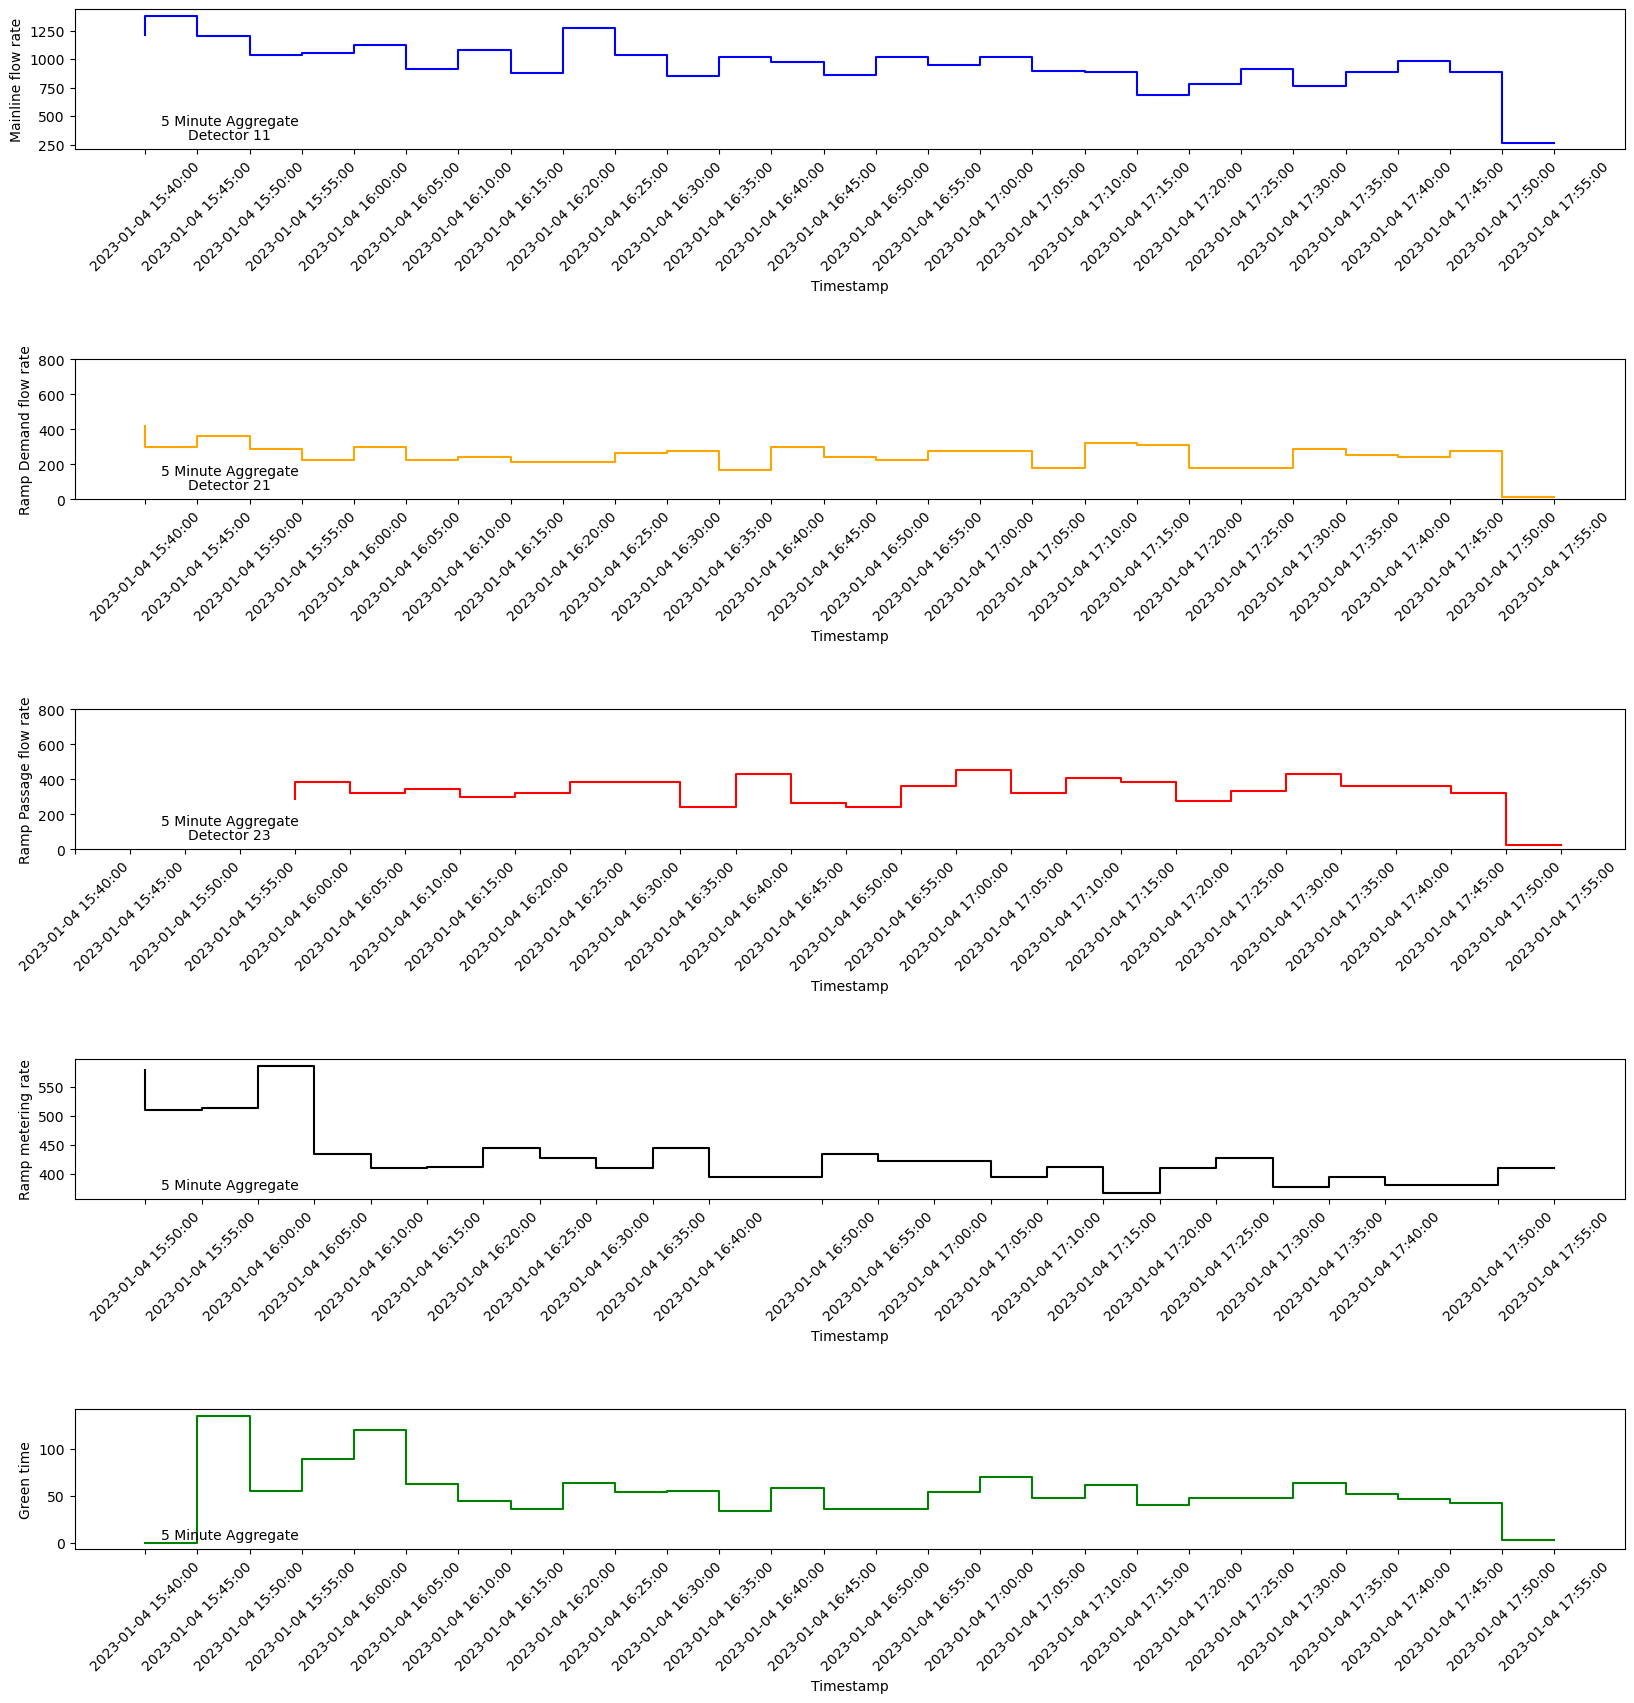

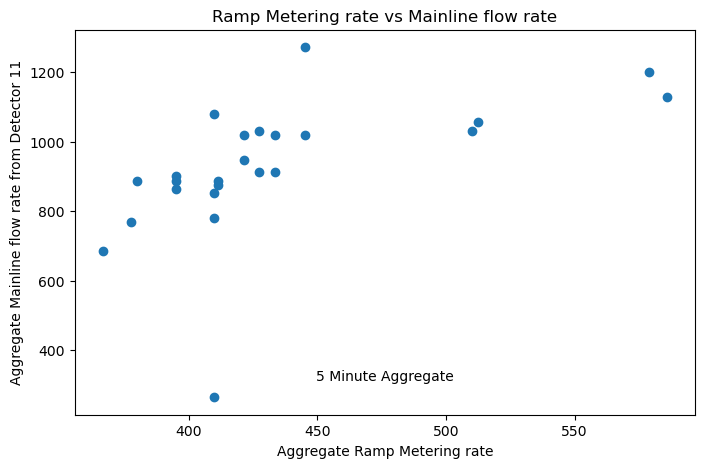

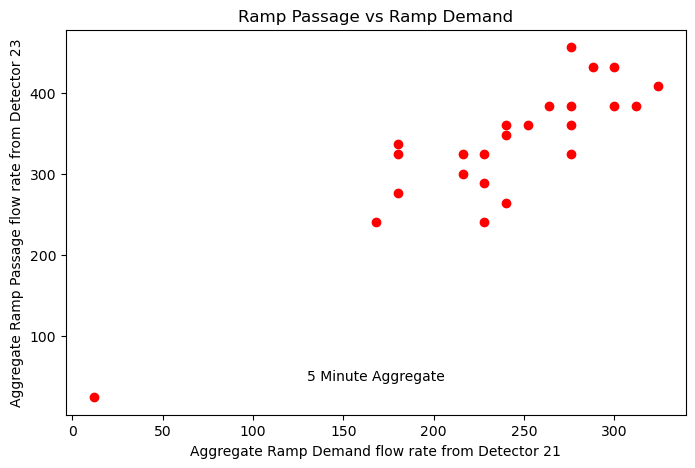

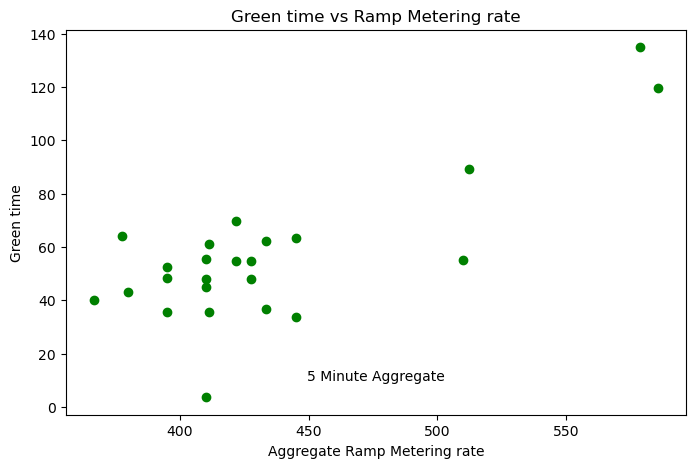

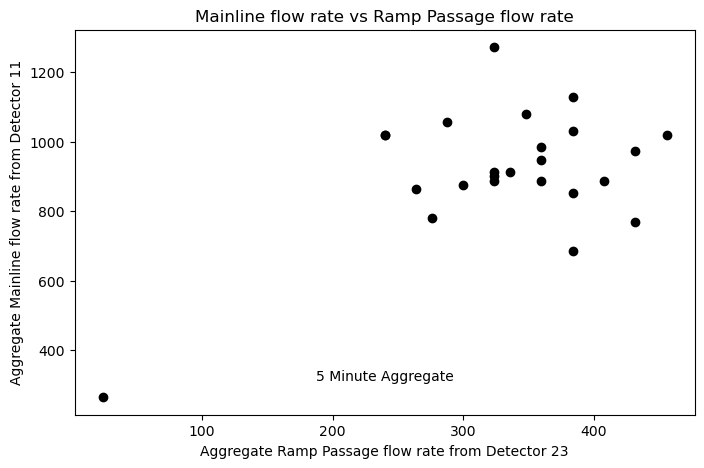




             Timestamp                             Type  \
0  2023-01-04 15:50:00  Ramp Meter - Lane 1 Active Rate   
1  2023-01-04 16:00:00  Ramp Meter - Lane 1 Active Rate   
2  2023-01-04 16:10:00  Ramp Meter - Lane 1 Active Rate   
3  2023-01-04 16:20:00  Ramp Meter - Lane 1 Active Rate   
4  2023-01-04 16:30:00  Ramp Meter - Lane 1 Active Rate   
5  2023-01-04 16:40:00  Ramp Meter - Lane 1 Active Rate   
6  2023-01-04 16:50:00  Ramp Meter - Lane 1 Active Rate   
7  2023-01-04 17:00:00  Ramp Meter - Lane 1 Active Rate   
8  2023-01-04 17:10:00  Ramp Meter - Lane 1 Active Rate   
9  2023-01-04 17:20:00  Ramp Meter - Lane 1 Active Rate   
10 2023-01-04 17:30:00  Ramp Meter - Lane 1 Active Rate   
11 2023-01-04 17:40:00  Ramp Meter - Lane 1 Active Rate   
12 2023-01-04 17:50:00  Ramp Meter - Lane 1 Active Rate   

    Aggregate ramp metering rate  
0                     565.000000  
1                     551.923077  
2                     427.500000  
3                     418.0000

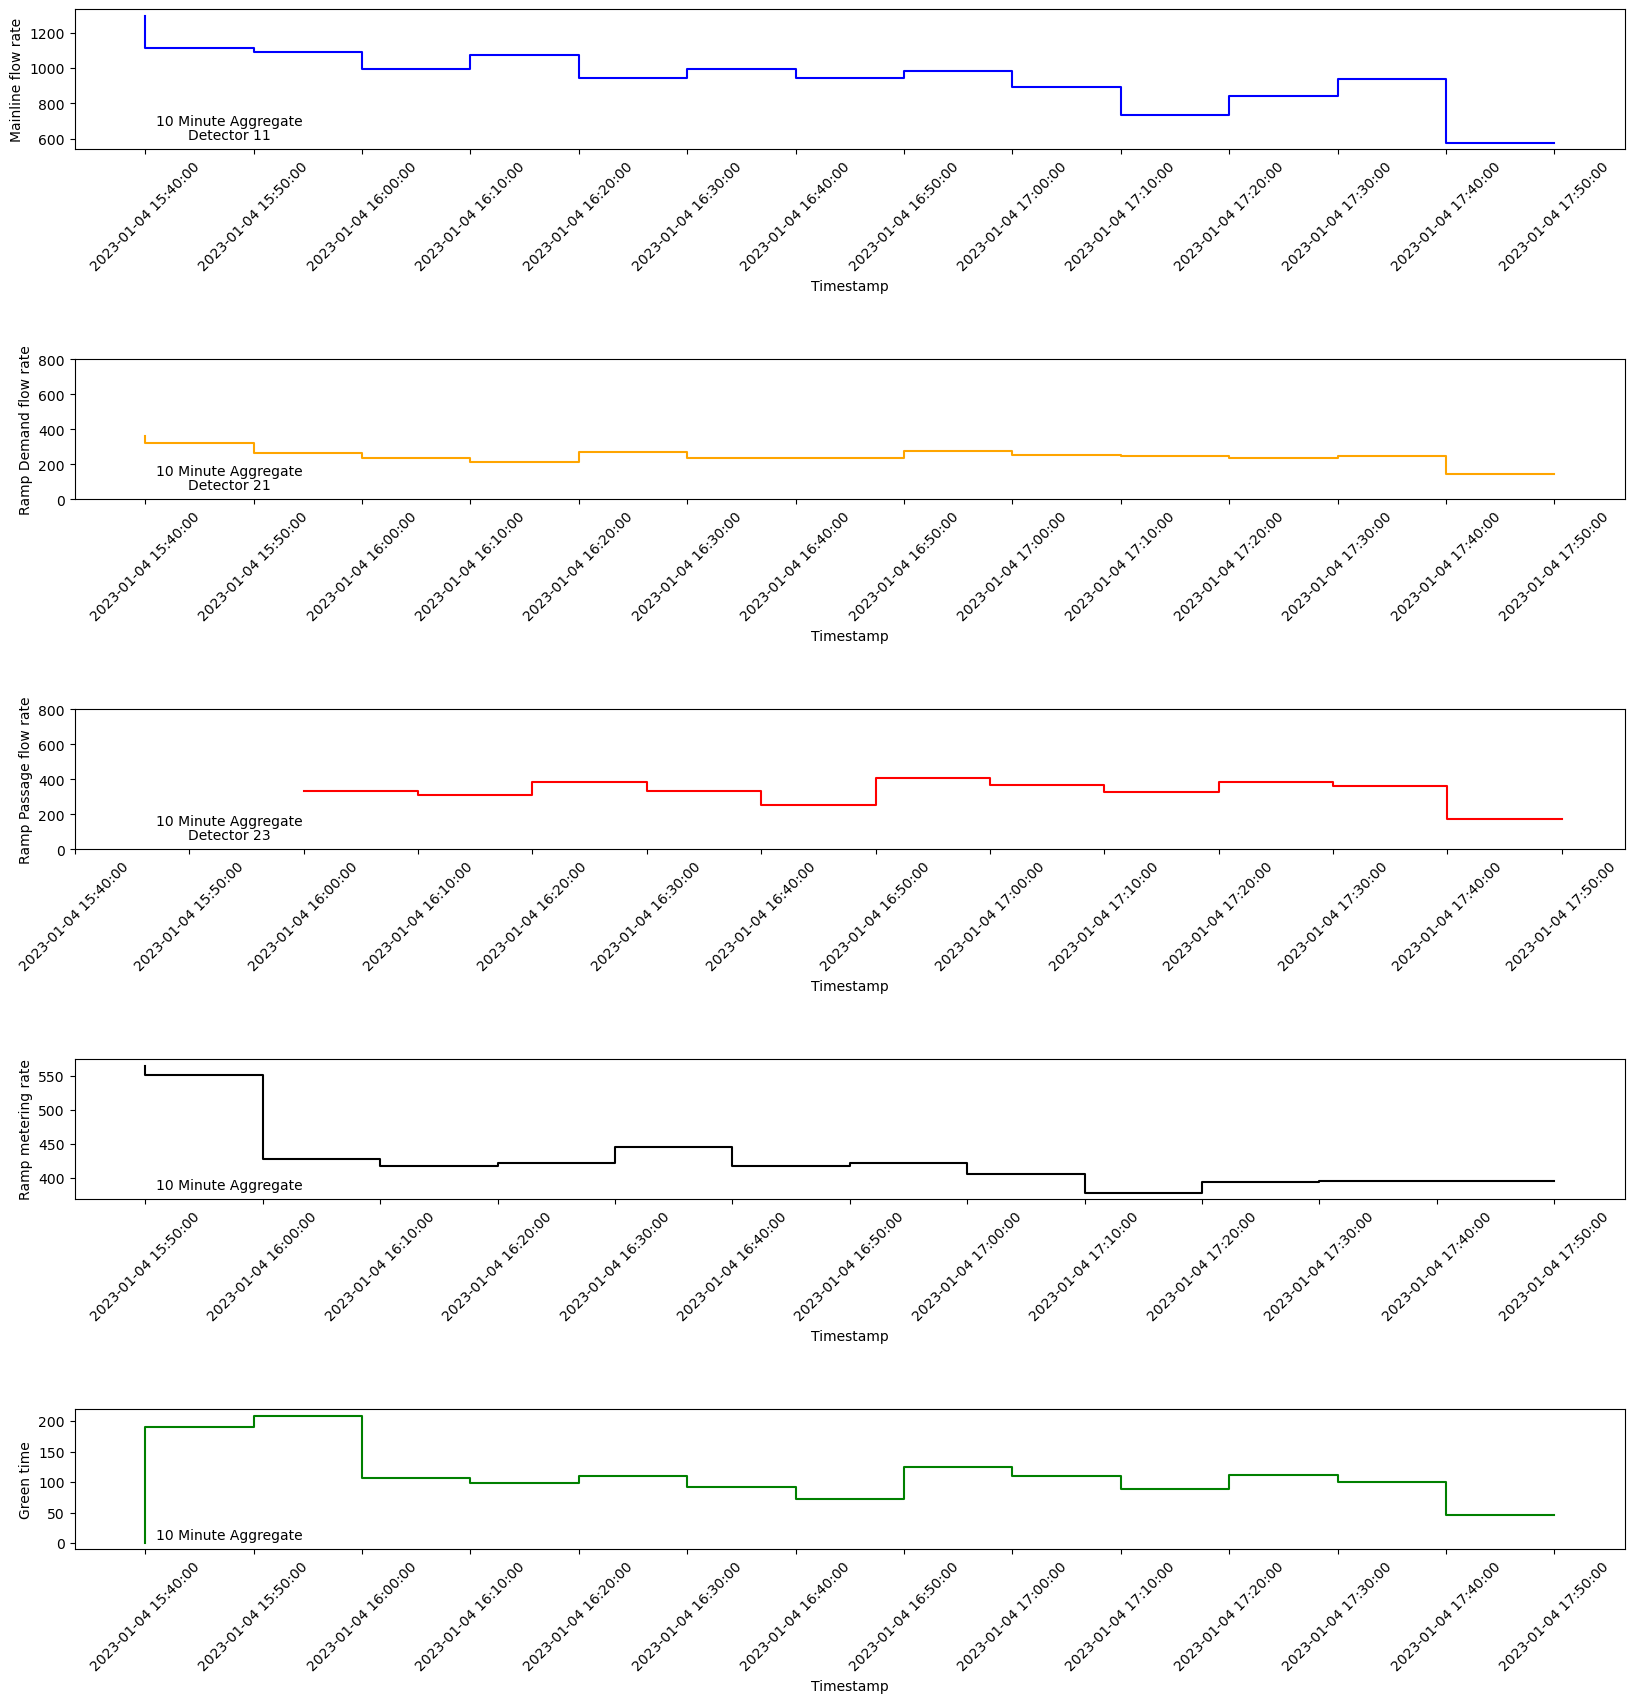

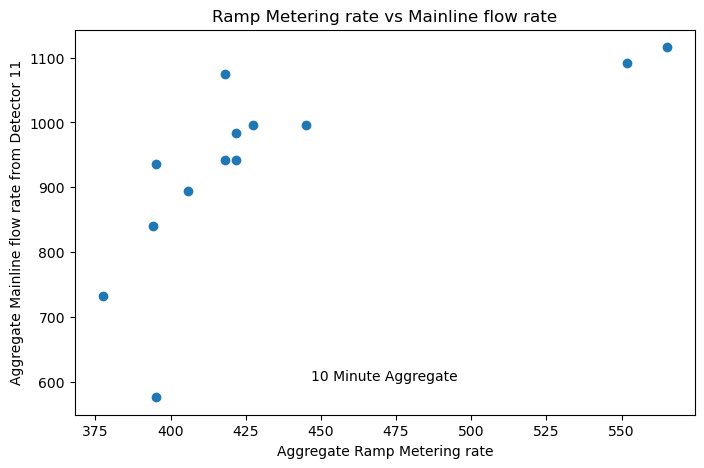

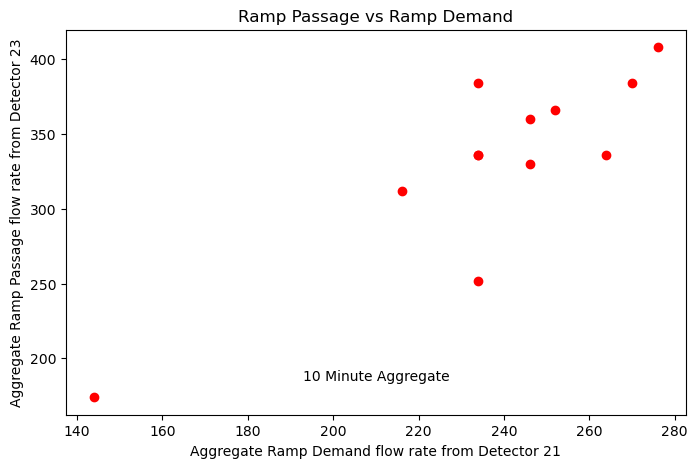

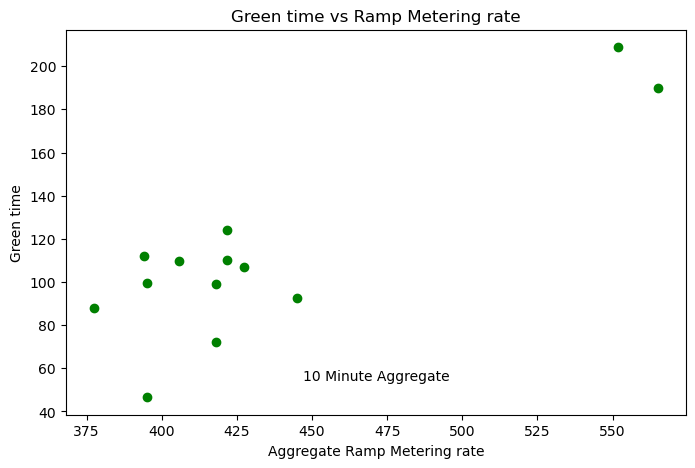

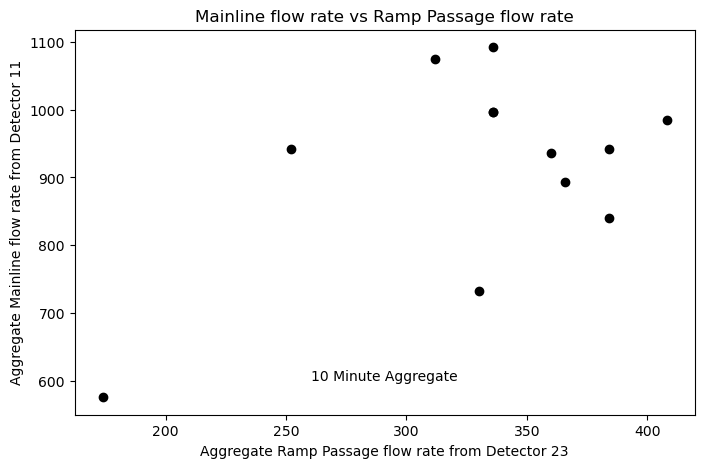




            Timestamp                             Type  \
0 2023-01-04 15:45:00  Ramp Meter - Lane 1 Active Rate   
1 2023-01-04 16:00:00  Ramp Meter - Lane 1 Active Rate   
2 2023-01-04 16:15:00  Ramp Meter - Lane 1 Active Rate   
3 2023-01-04 16:30:00  Ramp Meter - Lane 1 Active Rate   
4 2023-01-04 16:45:00  Ramp Meter - Lane 1 Active Rate   
5 2023-01-04 17:00:00  Ramp Meter - Lane 1 Active Rate   
6 2023-01-04 17:15:00  Ramp Meter - Lane 1 Active Rate   
7 2023-01-04 17:30:00  Ramp Meter - Lane 1 Active Rate   
8 2023-01-04 17:45:00  Ramp Meter - Lane 1 Active Rate   

   Aggregate ramp metering rate  
0                    565.000000  
1                    529.687500  
2                    416.666667  
3                    427.500000  
4                    418.000000  
5                    415.000000  
6                    394.375000  
7                    394.375000  
8                    395.000000  
            Timestamp         Type  Aggregate Mainline num vehicles  \
0 202

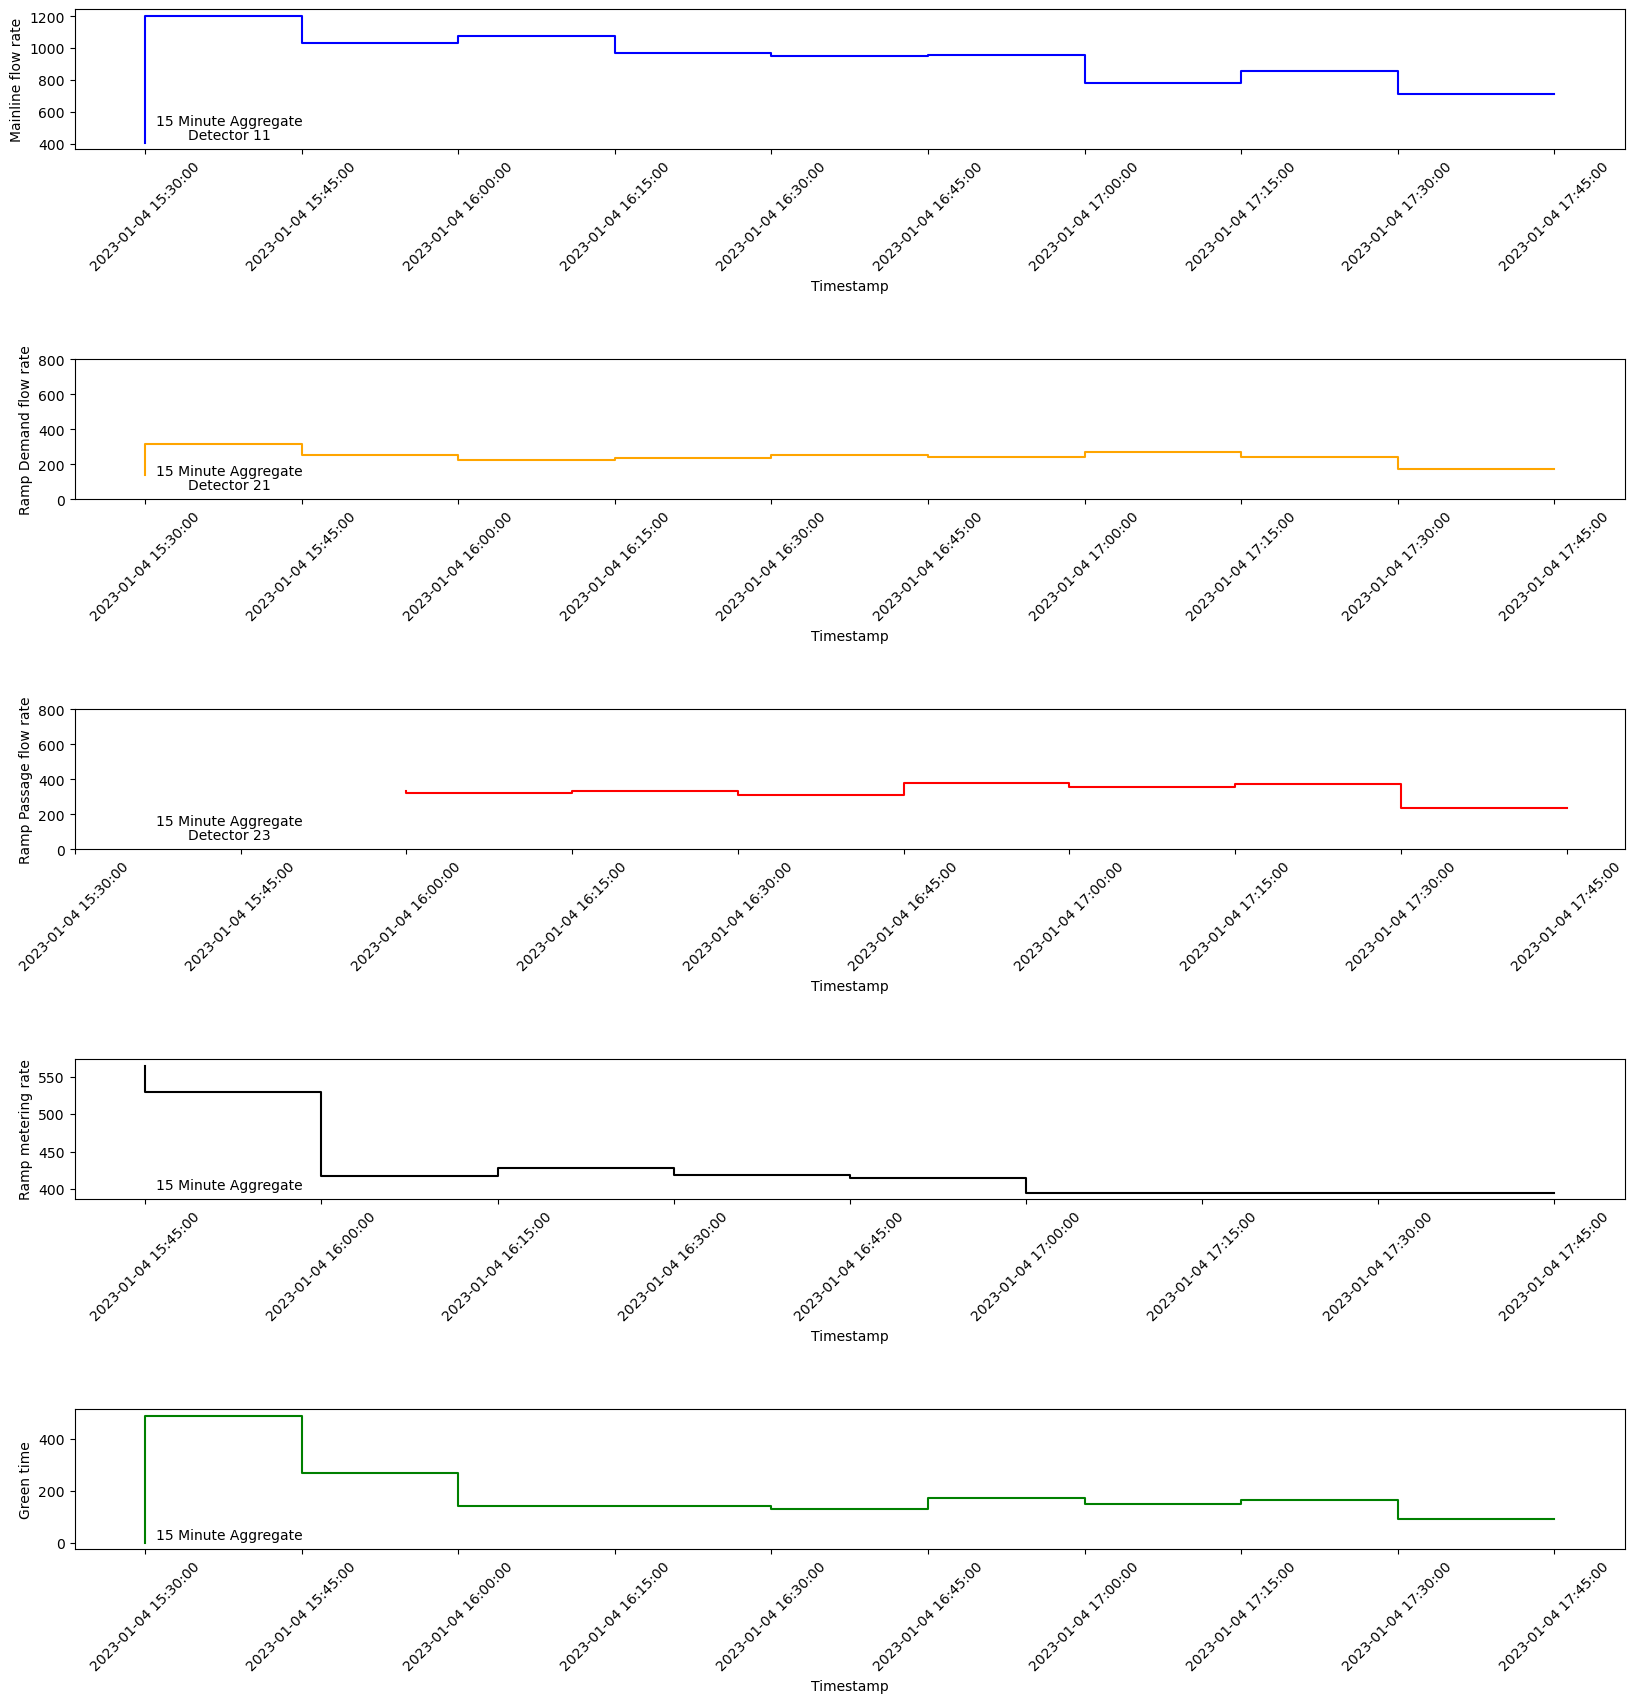

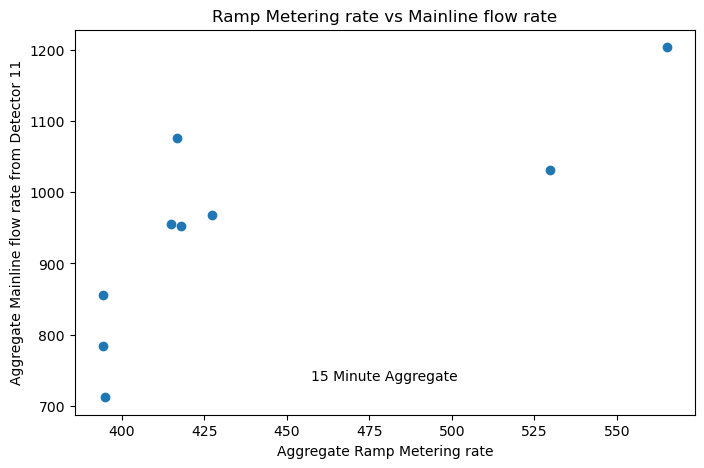

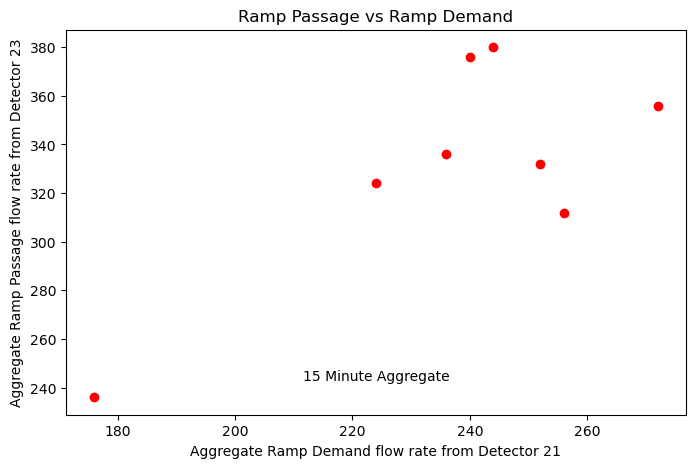

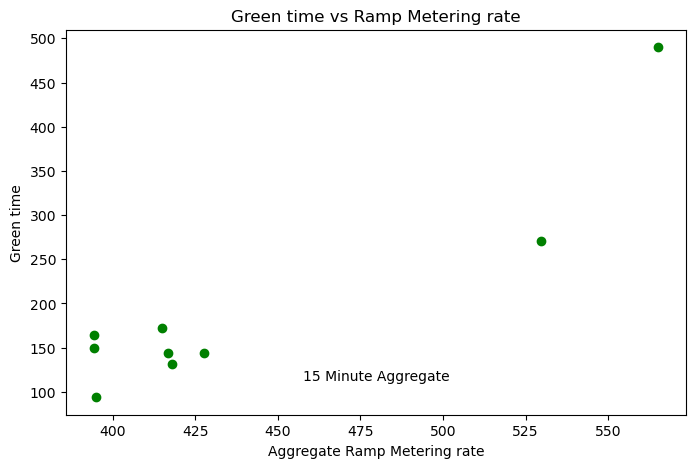

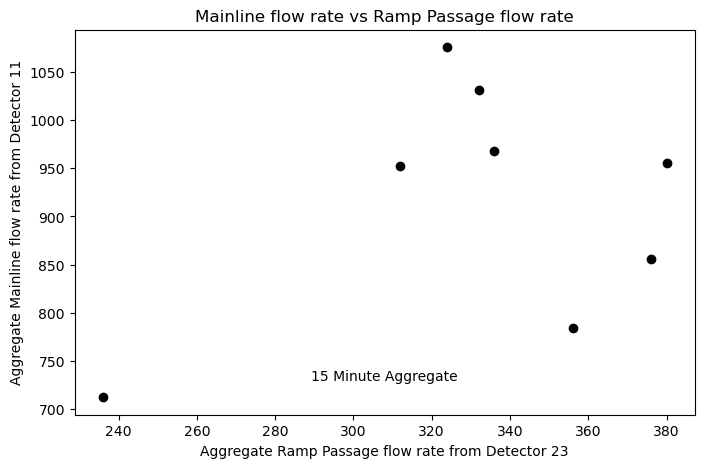




            Timestamp                             Type  \
0 2023-01-04 15:30:00  Ramp Meter - Lane 1 Active Rate   
1 2023-01-04 16:00:00  Ramp Meter - Lane 1 Active Rate   
2 2023-01-04 16:30:00  Ramp Meter - Lane 1 Active Rate   
3 2023-01-04 17:00:00  Ramp Meter - Lane 1 Active Rate   
4 2023-01-04 17:30:00  Ramp Meter - Lane 1 Active Rate   

   Aggregate ramp metering rate  
0                    565.000000  
1                    498.863636  
2                    422.222222  
3                    404.687500  
4                    394.500000  
            Timestamp         Type  Aggregate Mainline num vehicles  \
0 2023-01-04 15:30:00  Detector On                              402   
1 2023-01-04 16:00:00  Detector On                              527   
2 2023-01-04 16:30:00  Detector On                              480   
3 2023-01-04 17:00:00  Detector On                              435   
4 2023-01-04 17:30:00  Detector On                              392   

   Aggregate Main

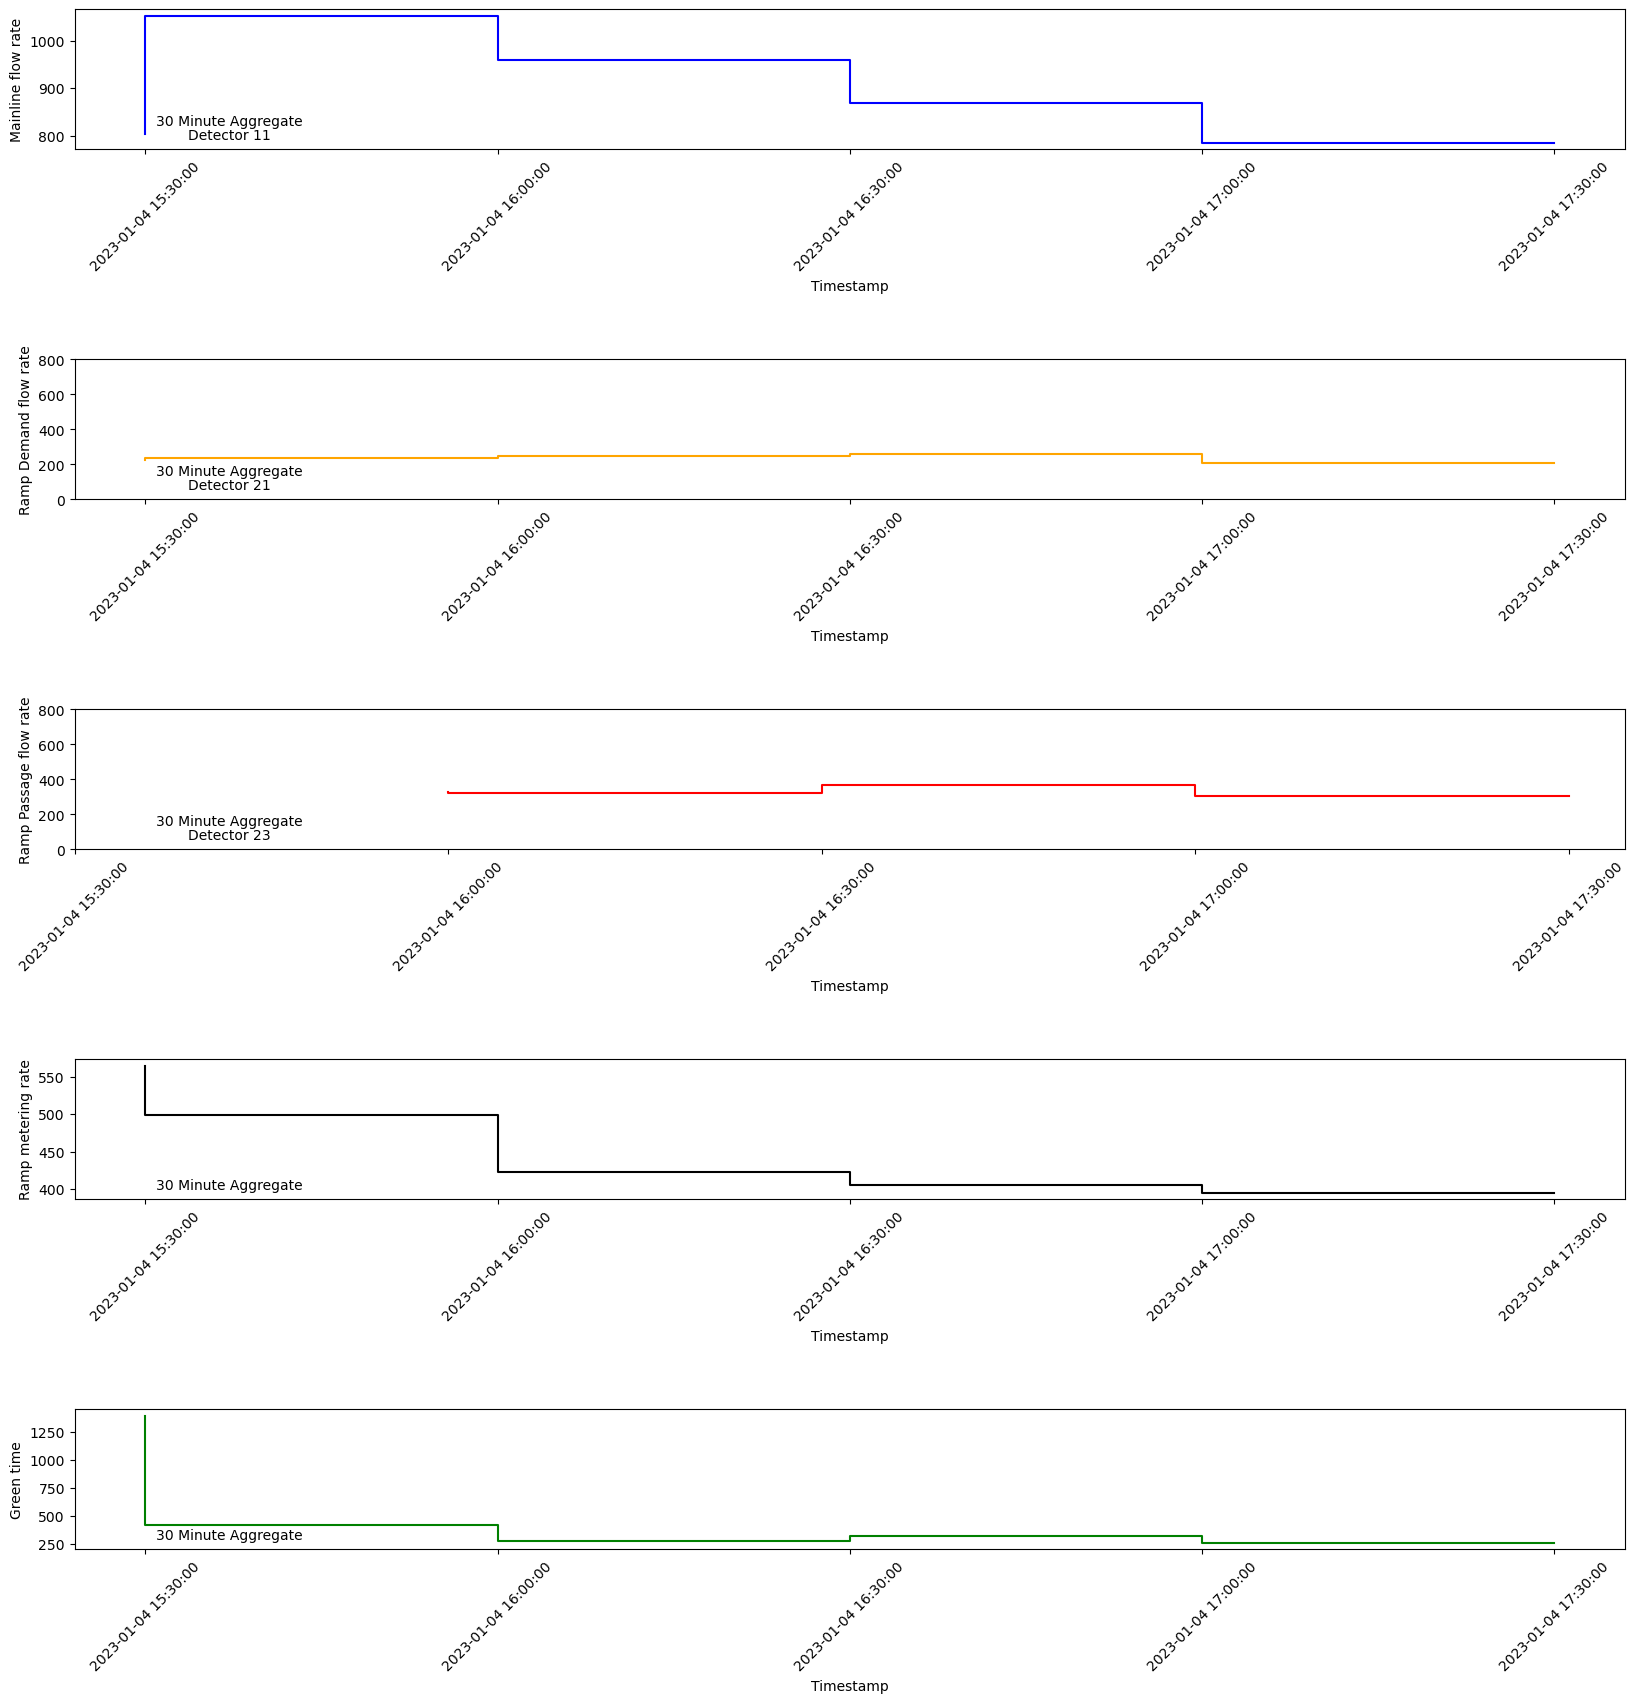

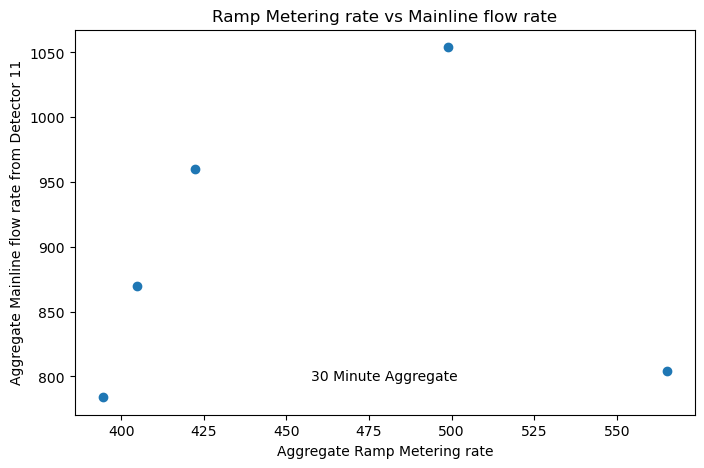

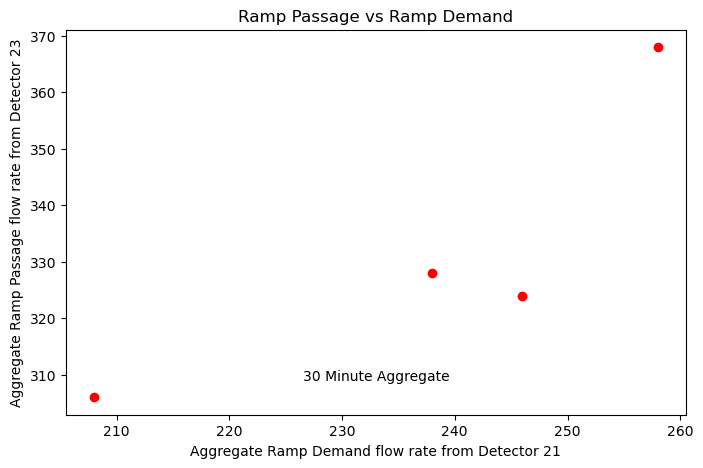

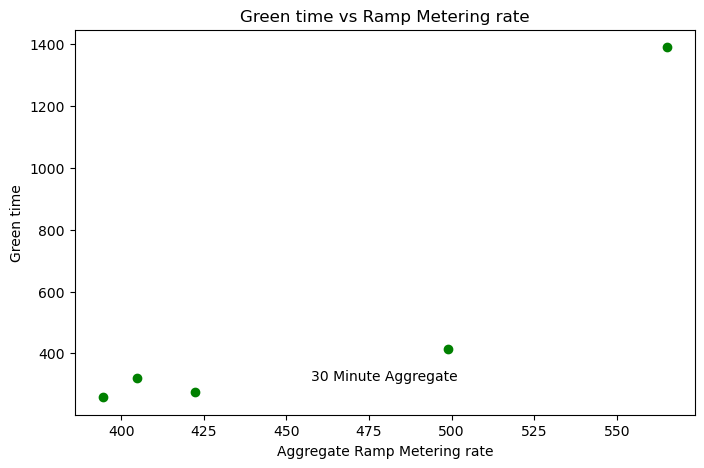

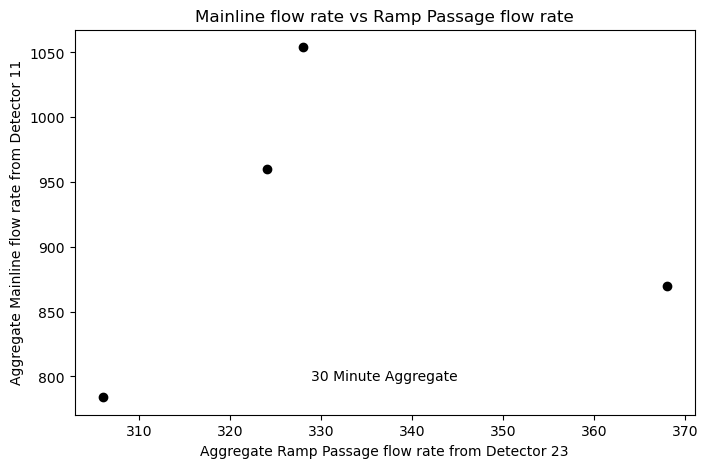

In [6]:
for i in [5,10,15,30]:
    plot_function(df_event_detail,i)

*************************************5 Minute Aggregate******************************


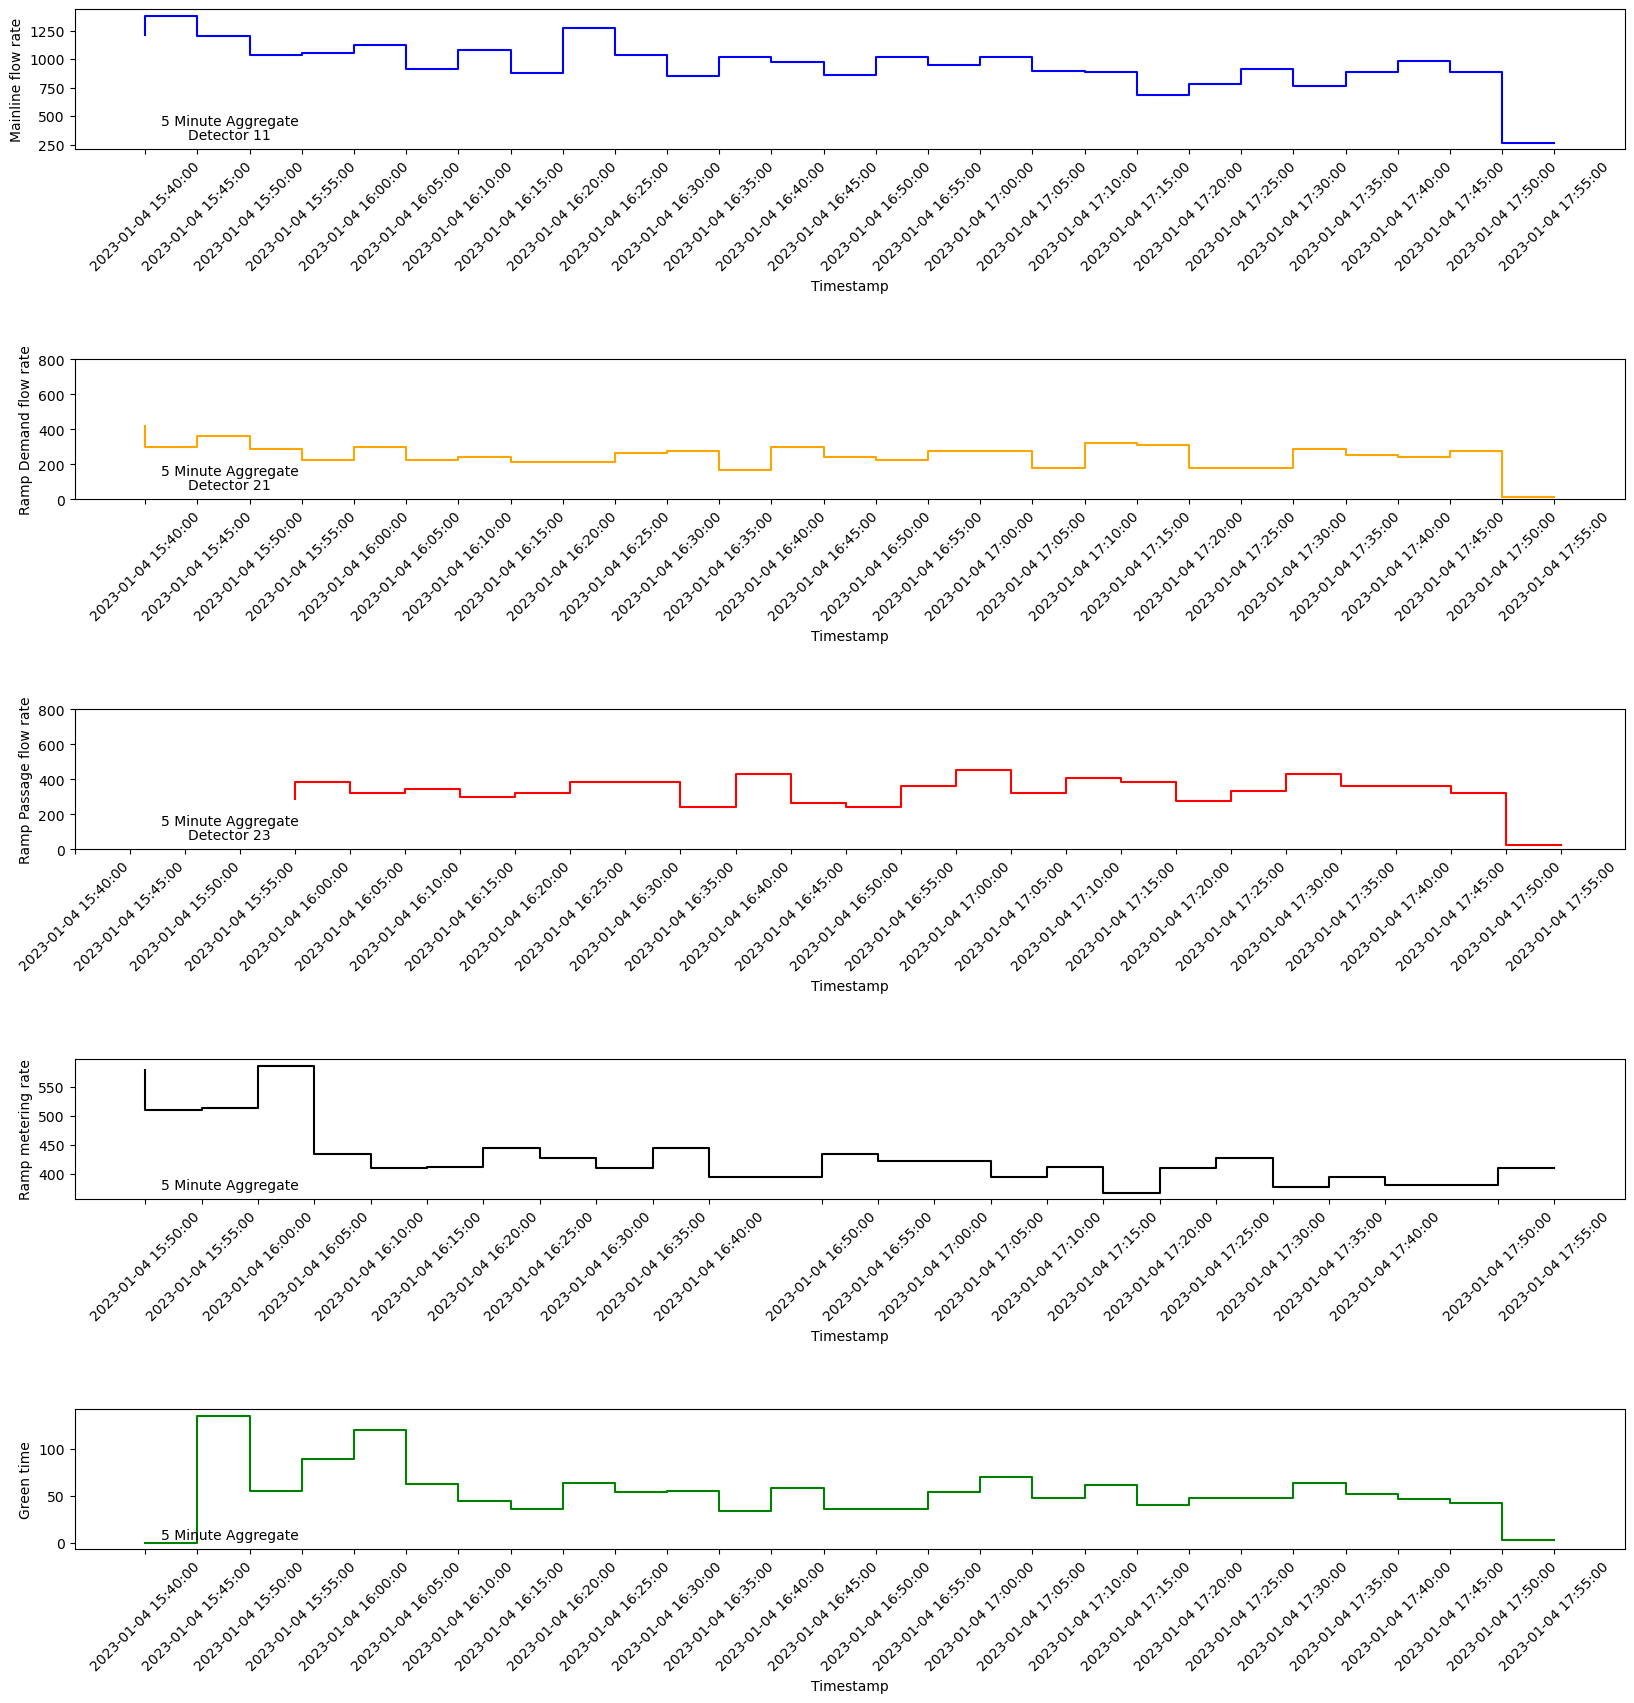

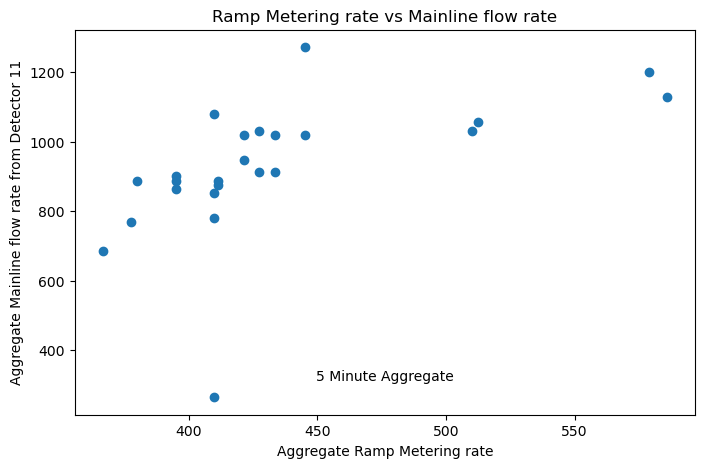

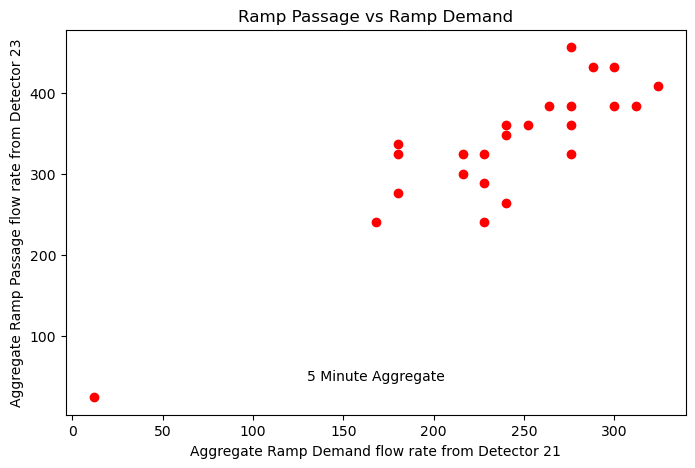

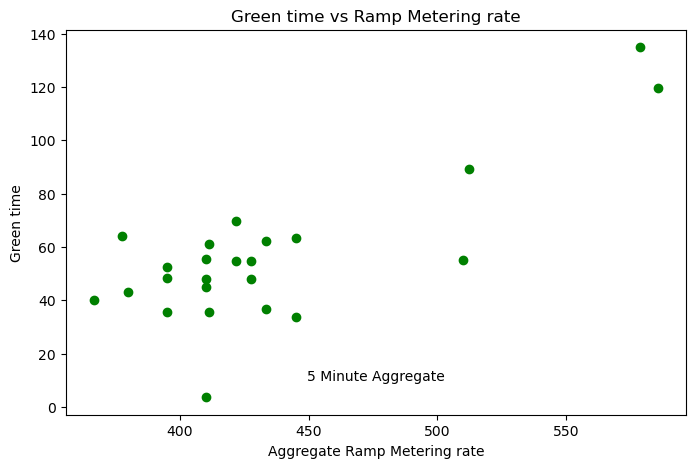

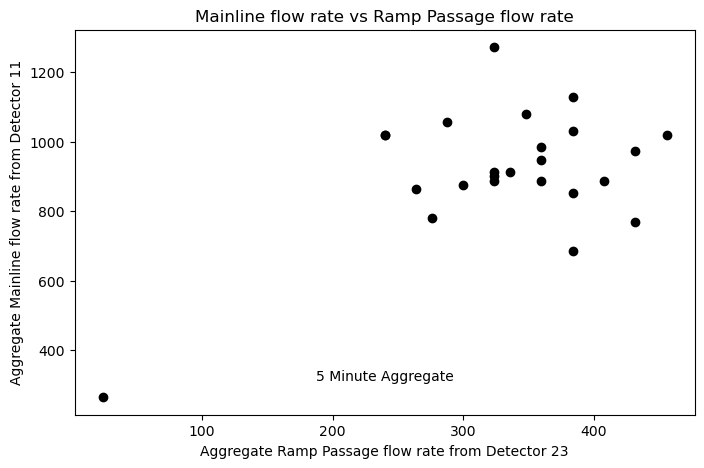




*************************************10 Minute Aggregate******************************


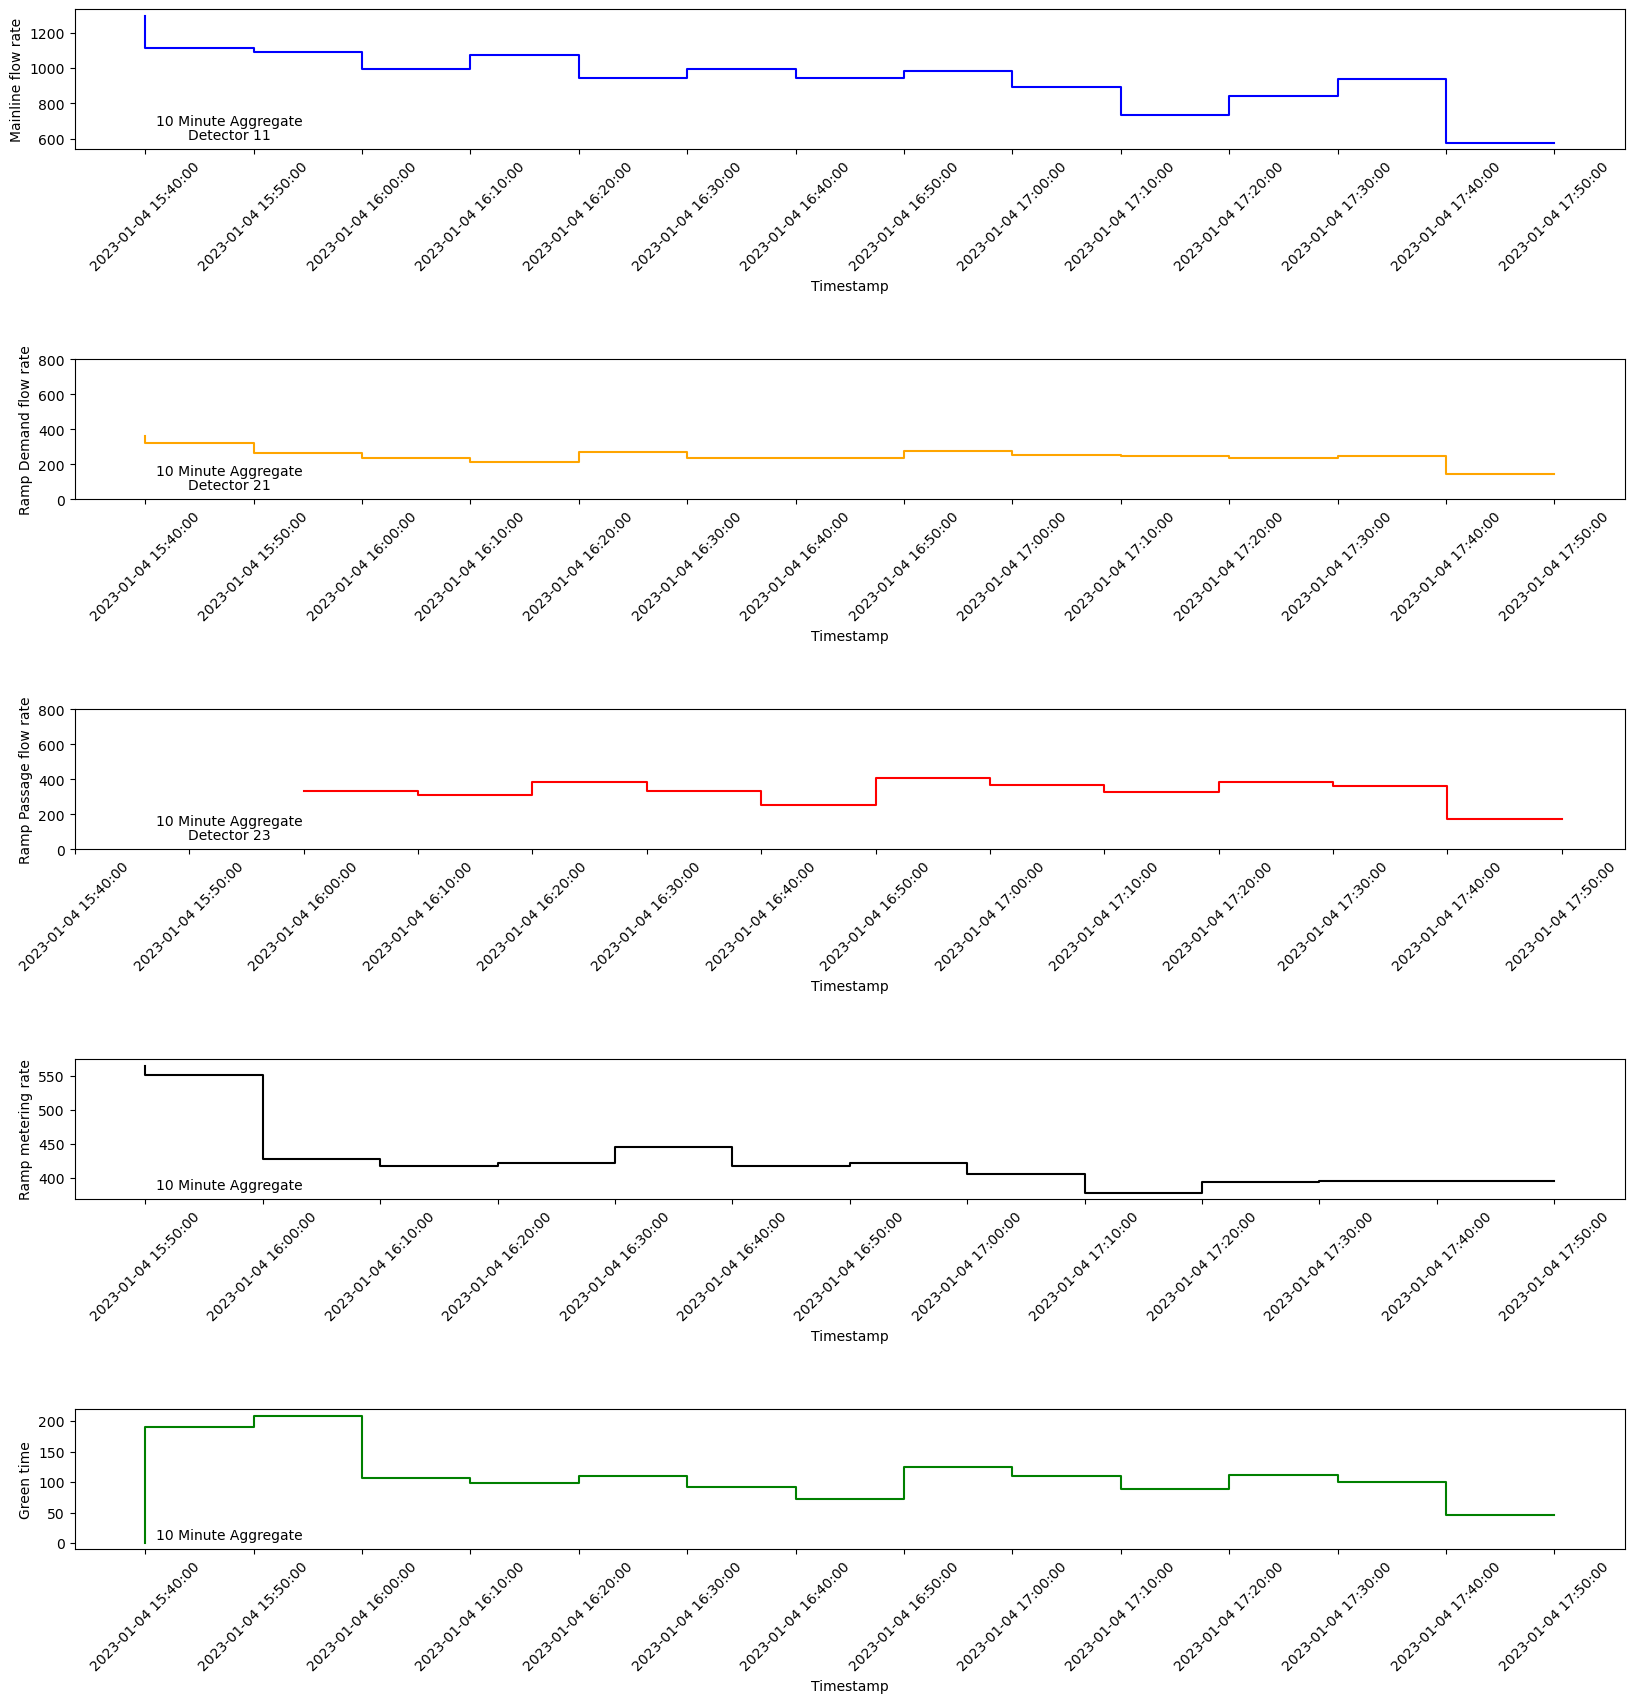

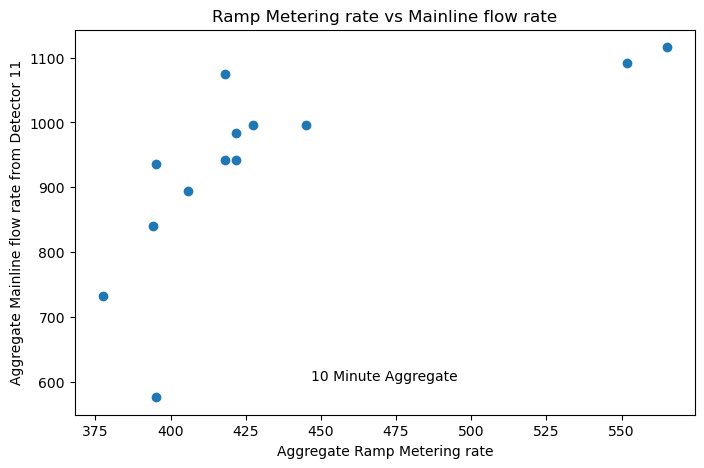

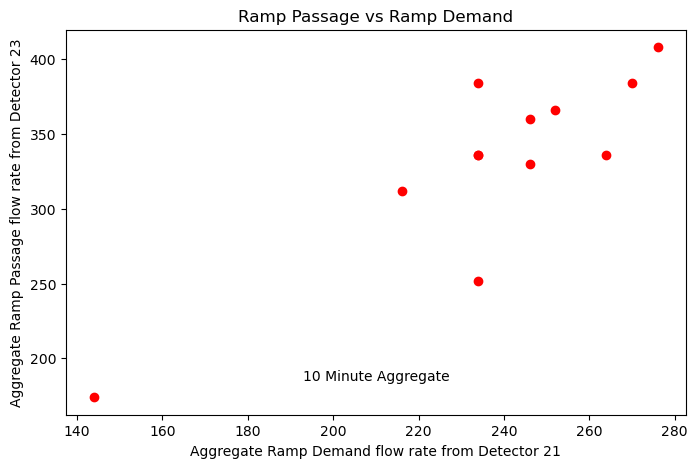

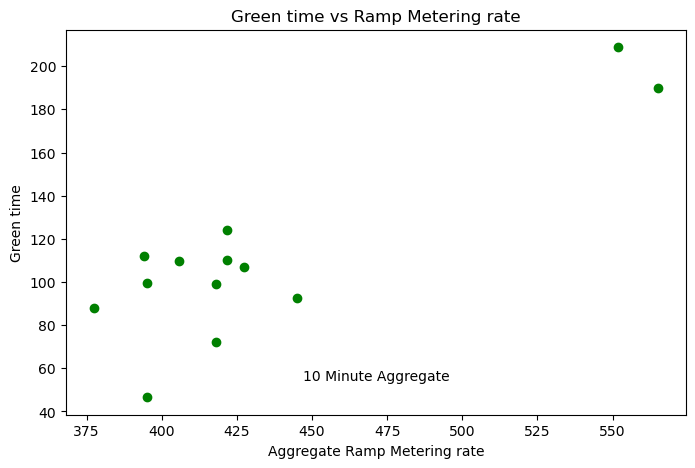

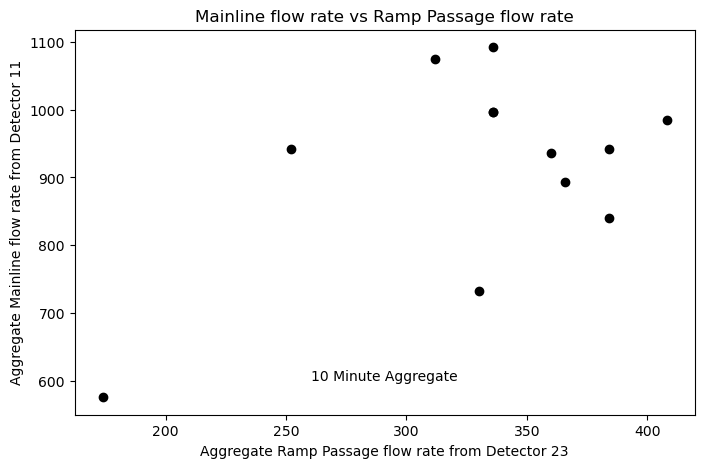




*************************************15 Minute Aggregate******************************


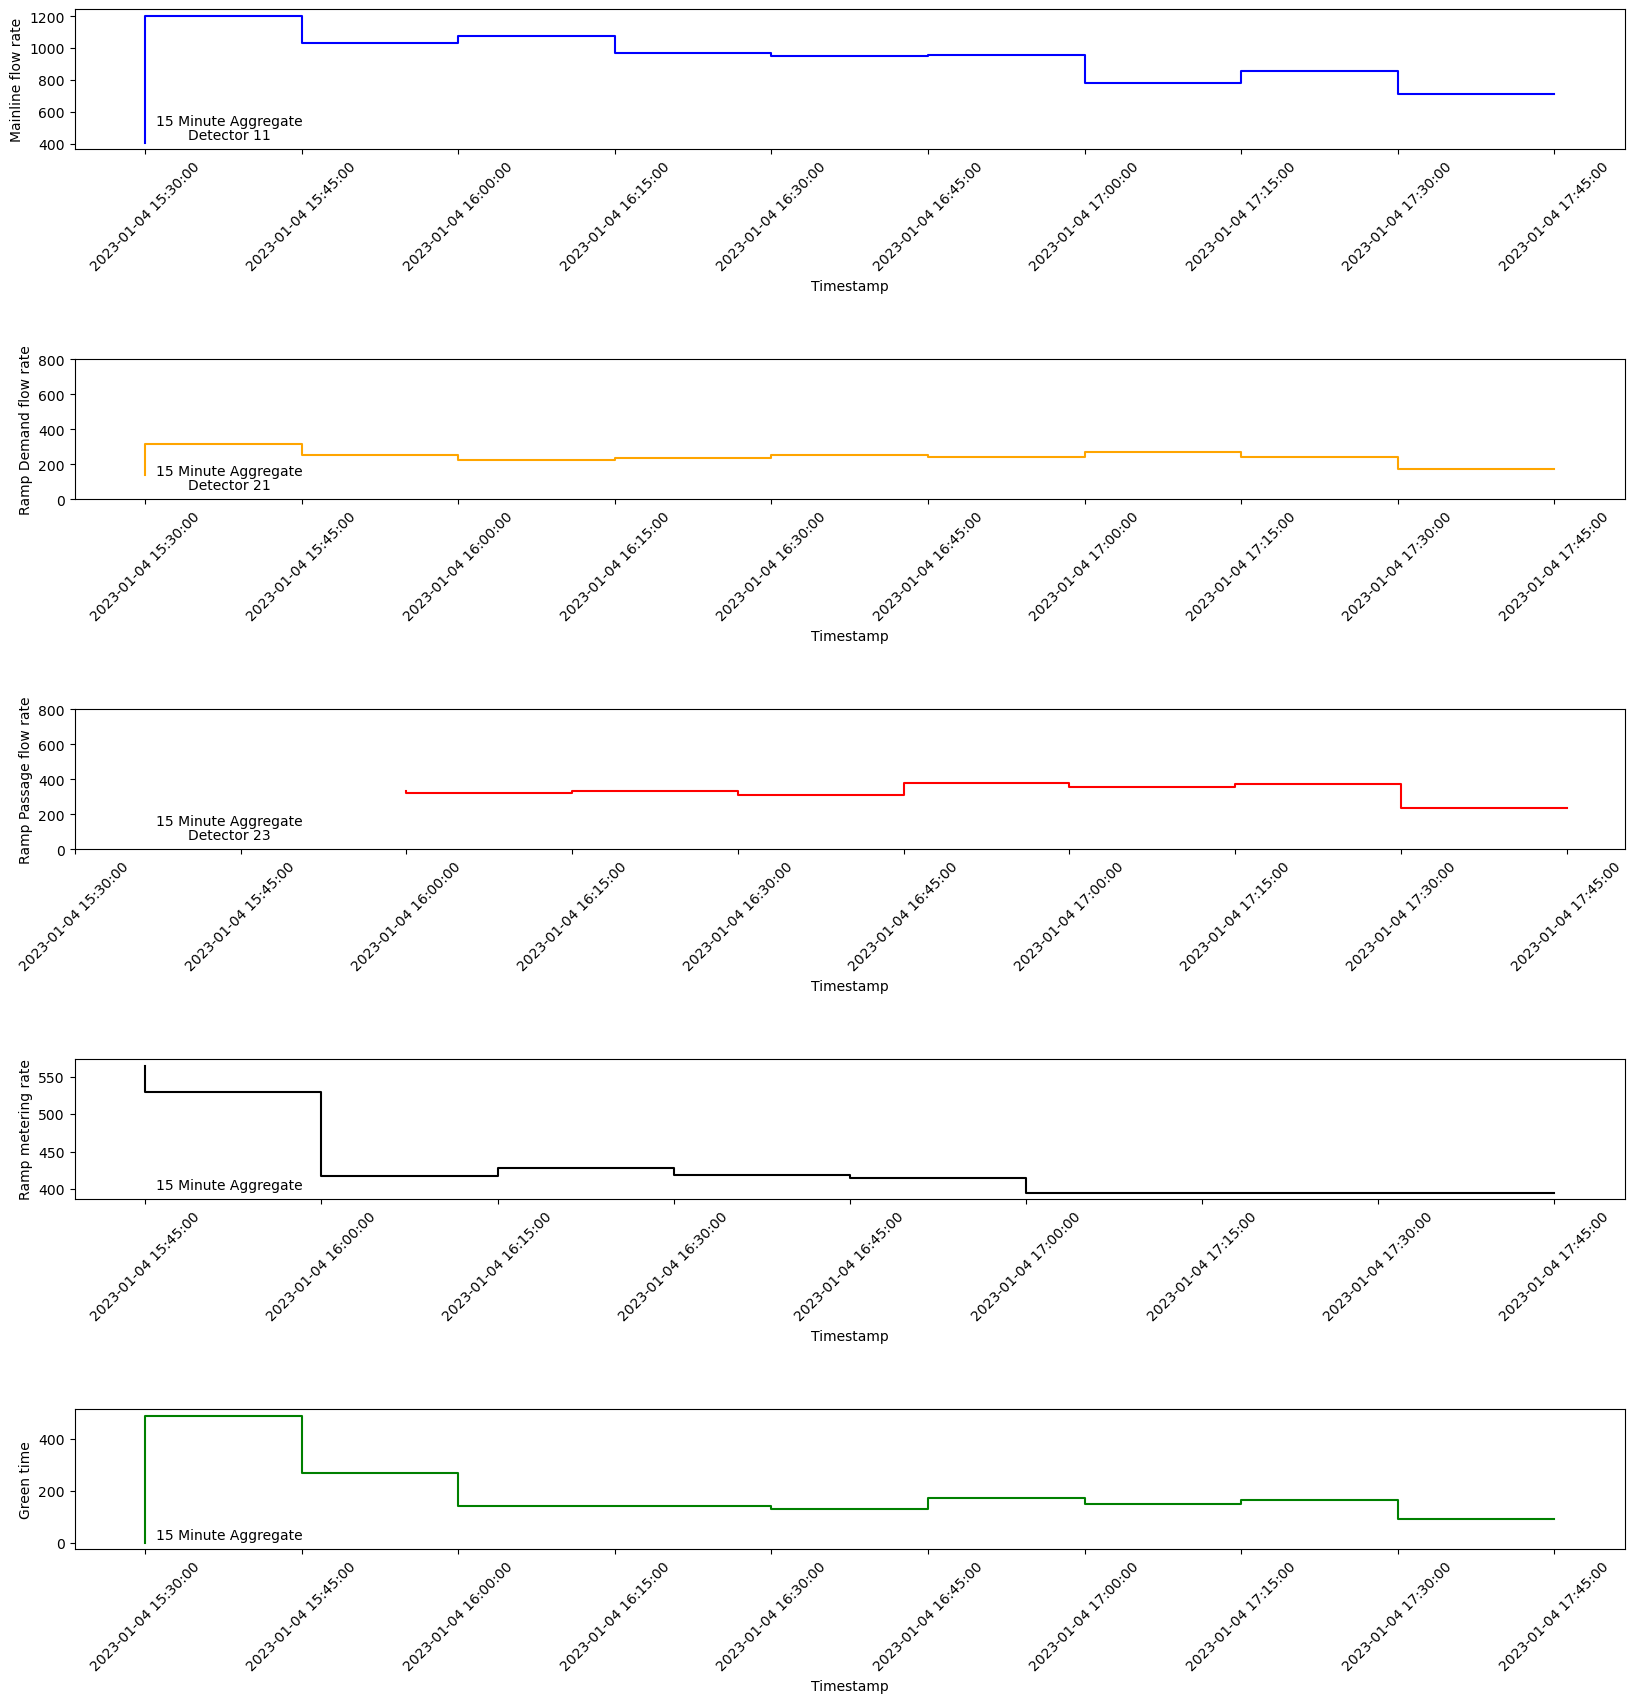

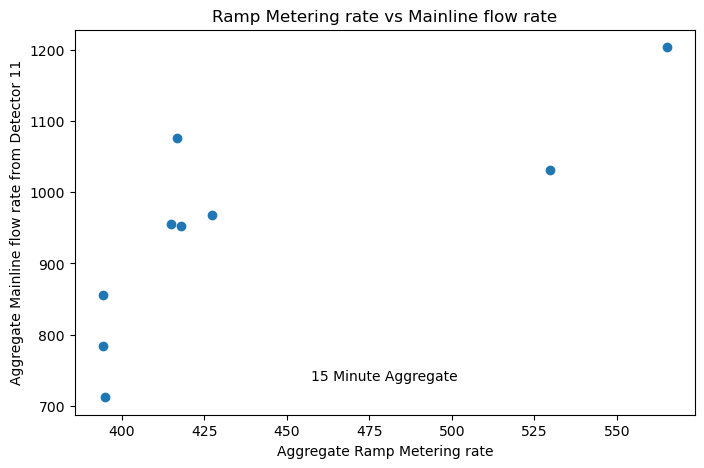

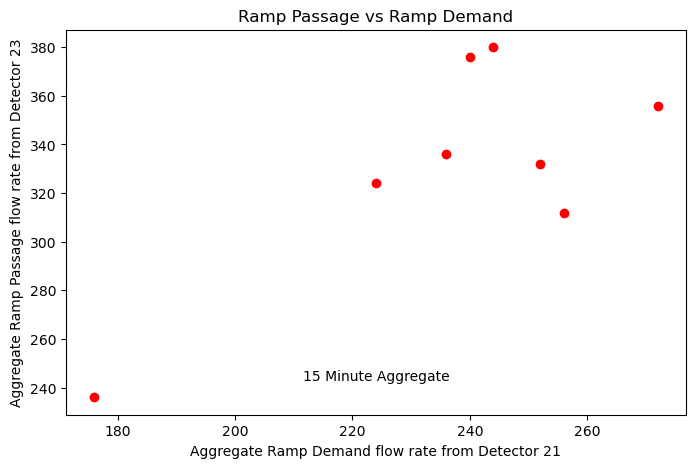

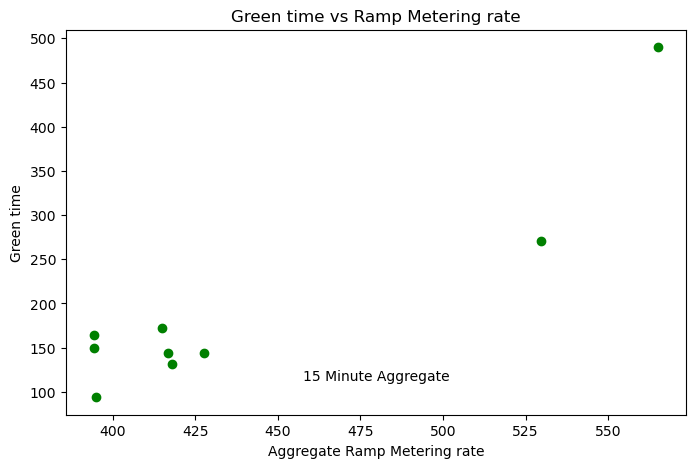

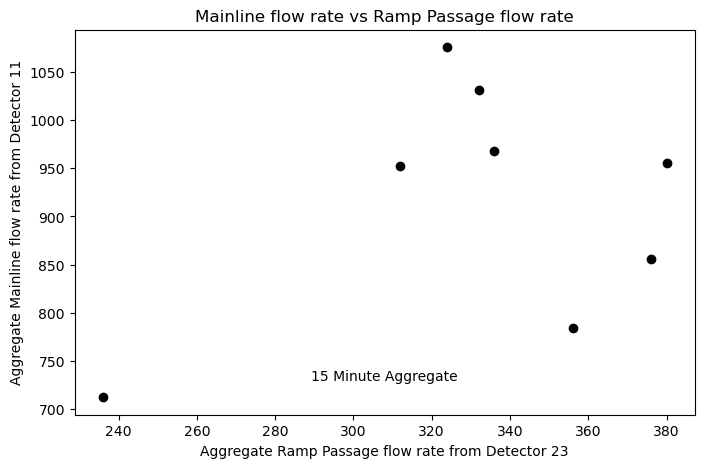




*************************************30 Minute Aggregate******************************


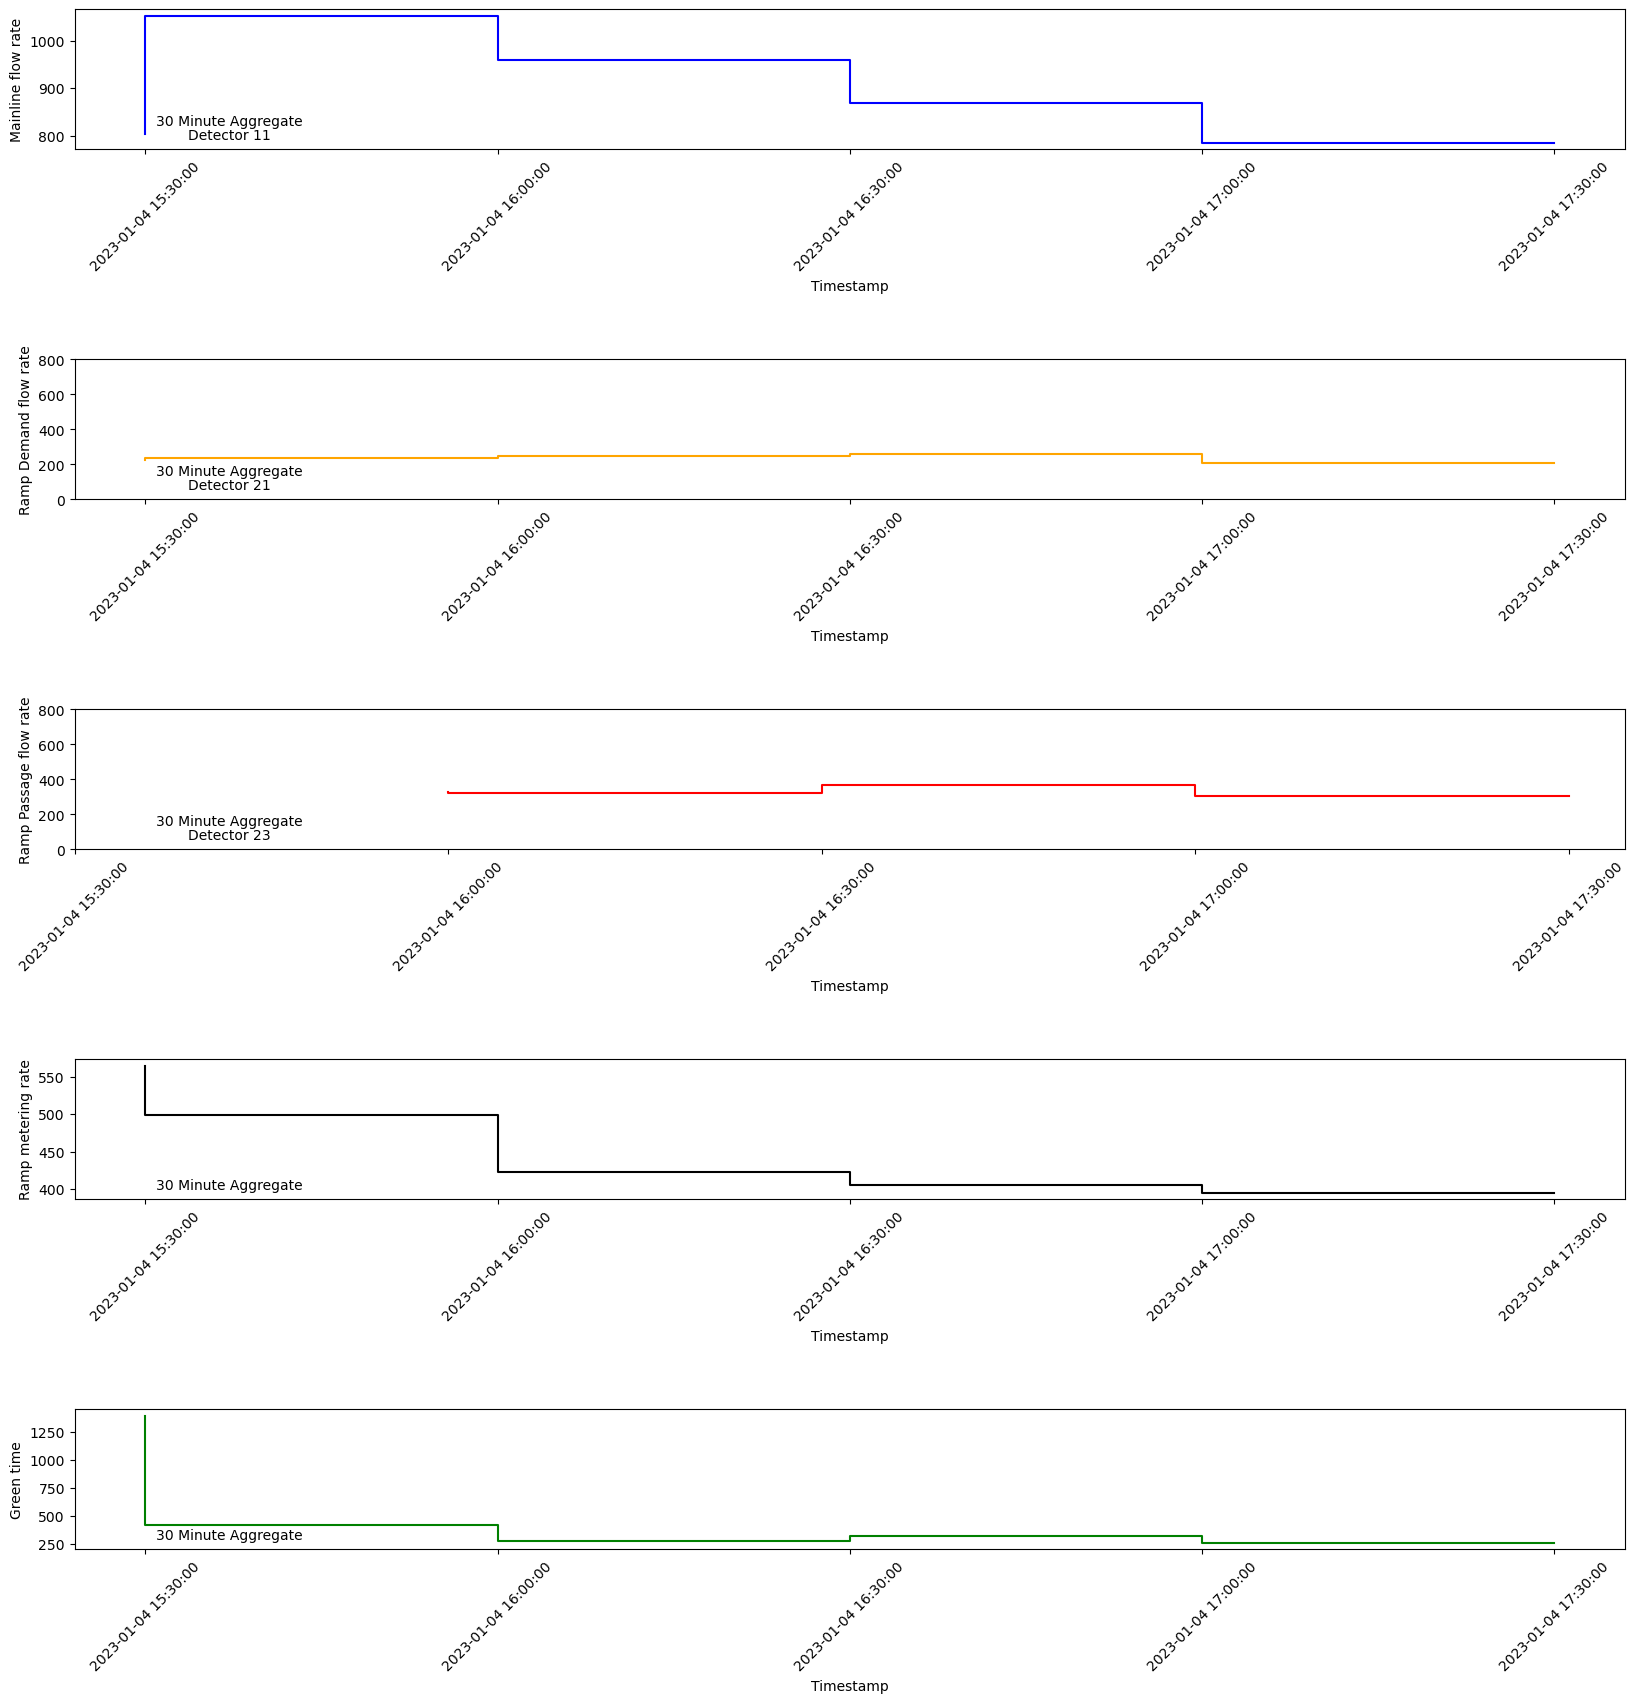

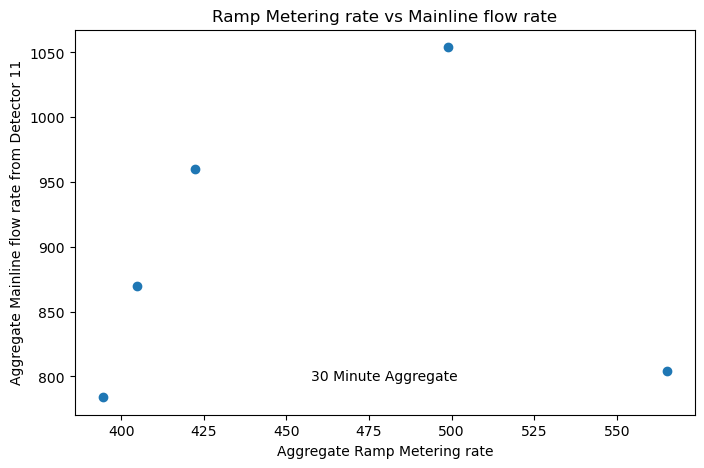

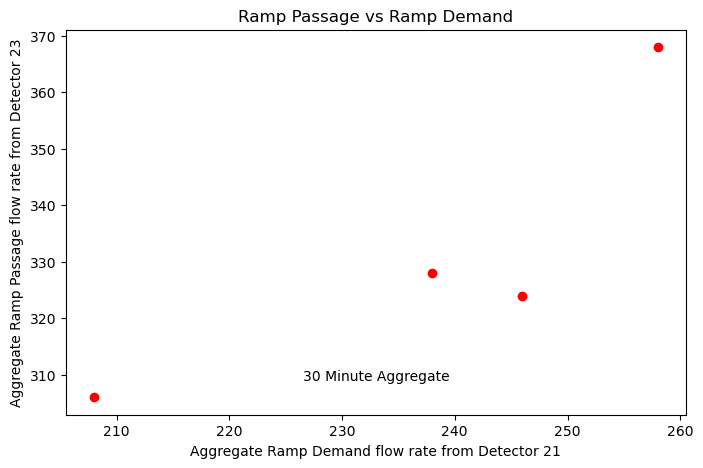

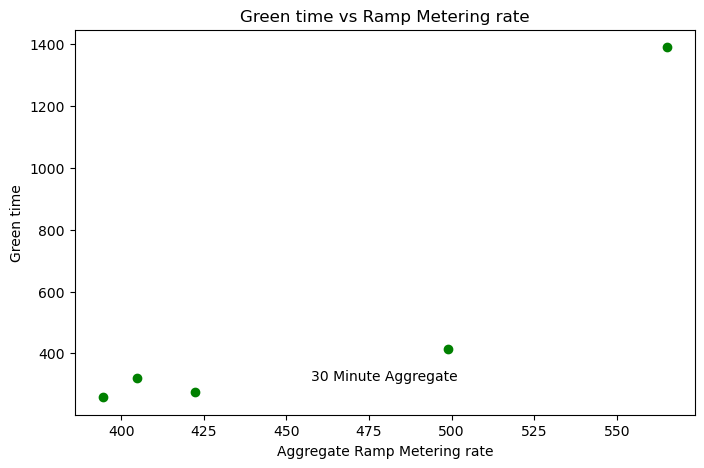

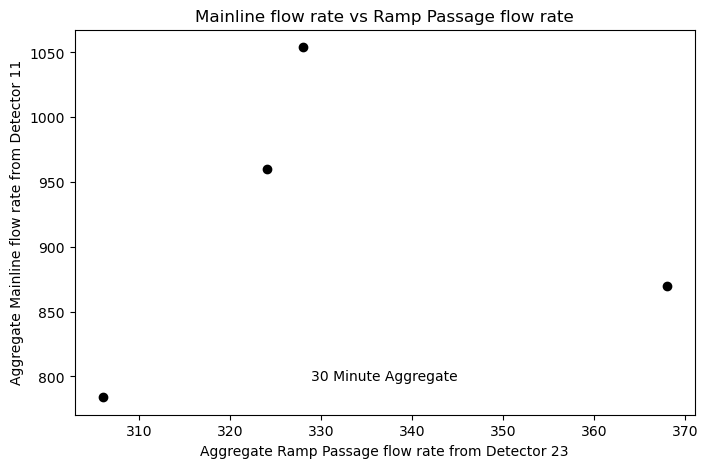

In [50]:
for i in [5,10,15,30]:
    plot_function(df_event_detail,i)

# Location: 104 Atlantic

In [51]:
file_name = './2023-01-20 Atlantic 104/Data/104 Atlantic - Device Event Detail (raw data).xlsx'
xl_file = pd.ExcelFile(file_name)

dfs = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}
df_event_detail = dfs['104 Atlantic - Device Event Det']
df_event_detail = df_event_detail.drop(axis=1, columns=[' '])
dict1 = {}
for column in df_event_detail.columns:
    dict1[column] = column.strip()
df_event_detail = df_event_detail.rename(columns=dict1)

df_event_detail['Timestamp'] = df_event_detail['Timestamp'].apply(lambda x: x.strip())
df_event_detail['Category'] = df_event_detail['Category'].apply(lambda x: x.strip())
df_event_detail['Type'] = df_event_detail['Type'].apply(lambda x: x.strip())
df_event_detail['Timestamp'] = pd.to_datetime(df_event_detail['Timestamp'])
df_event_detail = df_event_detail.rename(columns={'Event Value':'Event_value'})

In [52]:
df_event_detail

Timestamp           Category  \
0     2023-01-20 17:45:34.700    Detector Events   
1     2023-01-20 17:45:33.800    Detector Events   
2     2023-01-20 17:45:32.500    Detector Events   
3     2023-01-20 17:45:31.100    Detector Events   
4     2023-01-20 17:45:30.900    Detector Events   
...                       ...                ...   
39377 2023-01-20 16:00:00.400  Ramp Meter Events   
39378 2023-01-20 16:00:00.300    Detector Events   
39379 2023-01-20 16:00:00.200    Detector Events   
39380 2023-01-20 16:00:00.100    Detector Events   
39381 2023-01-20 16:00:00.000    Detector Events   

                                           Type  Event_value  
0                                   Detector On           11  
1                                   Detector On           23  
2                                  Detector Off            2  
3                                   Detector On           13  
4                                  Detector Off           23  
...                                         ...          ...  
39377  Ramp Meter - Lane 1 Requested Fixed Rate          800  
39378                               Detector On            2  
39379                              Detector Off           13  
39380                              Detector Off            3  
39381                               Detector On           13  

[39382 rows x 4 columns]

*************************************5 Minute Aggregate******************************


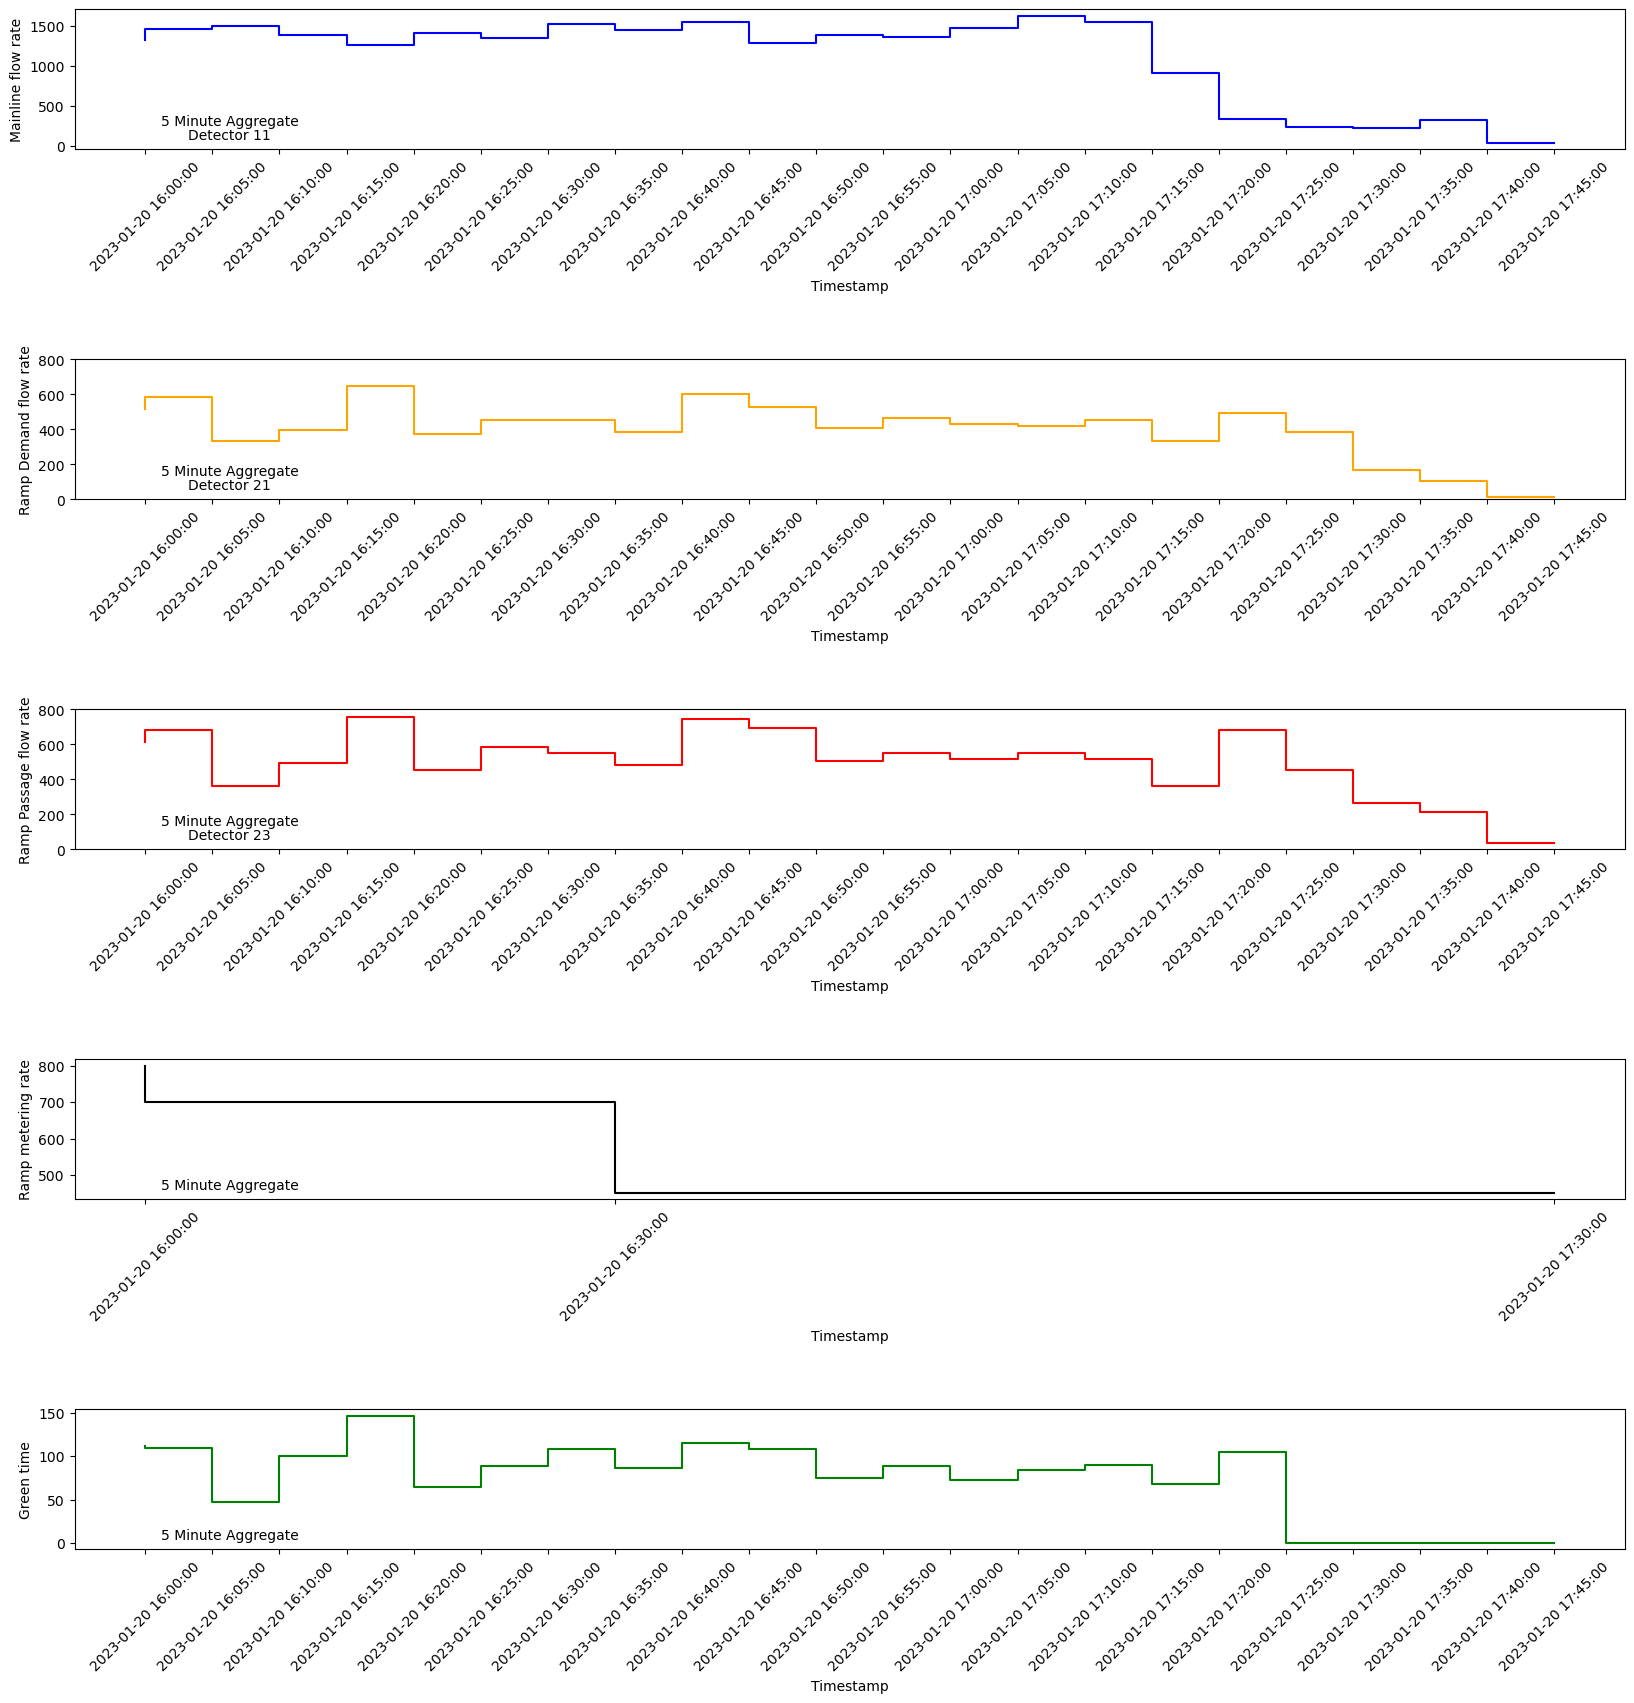

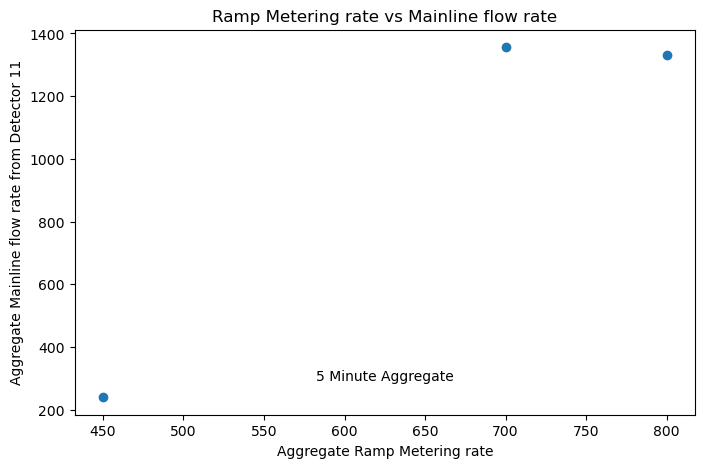

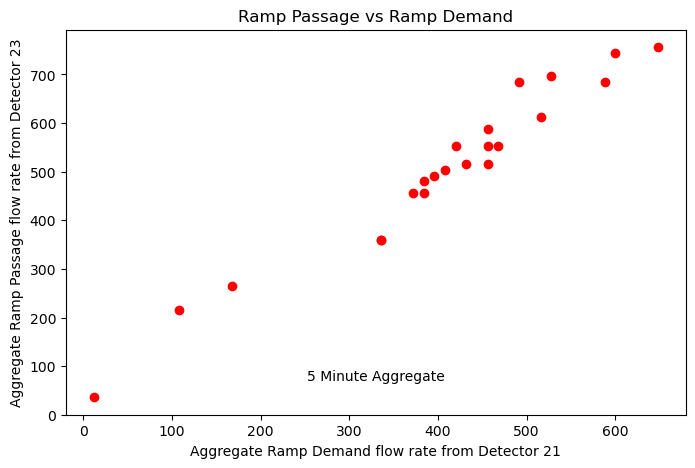

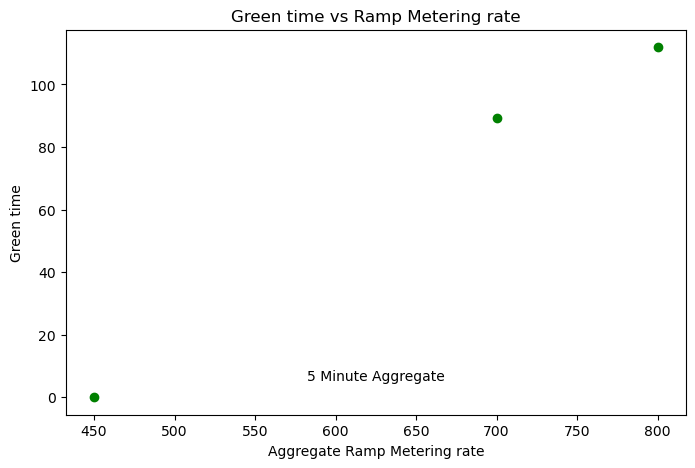

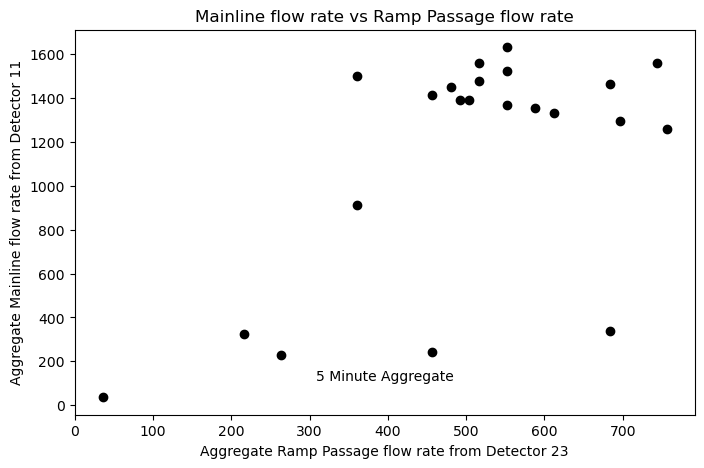




*************************************10 Minute Aggregate******************************


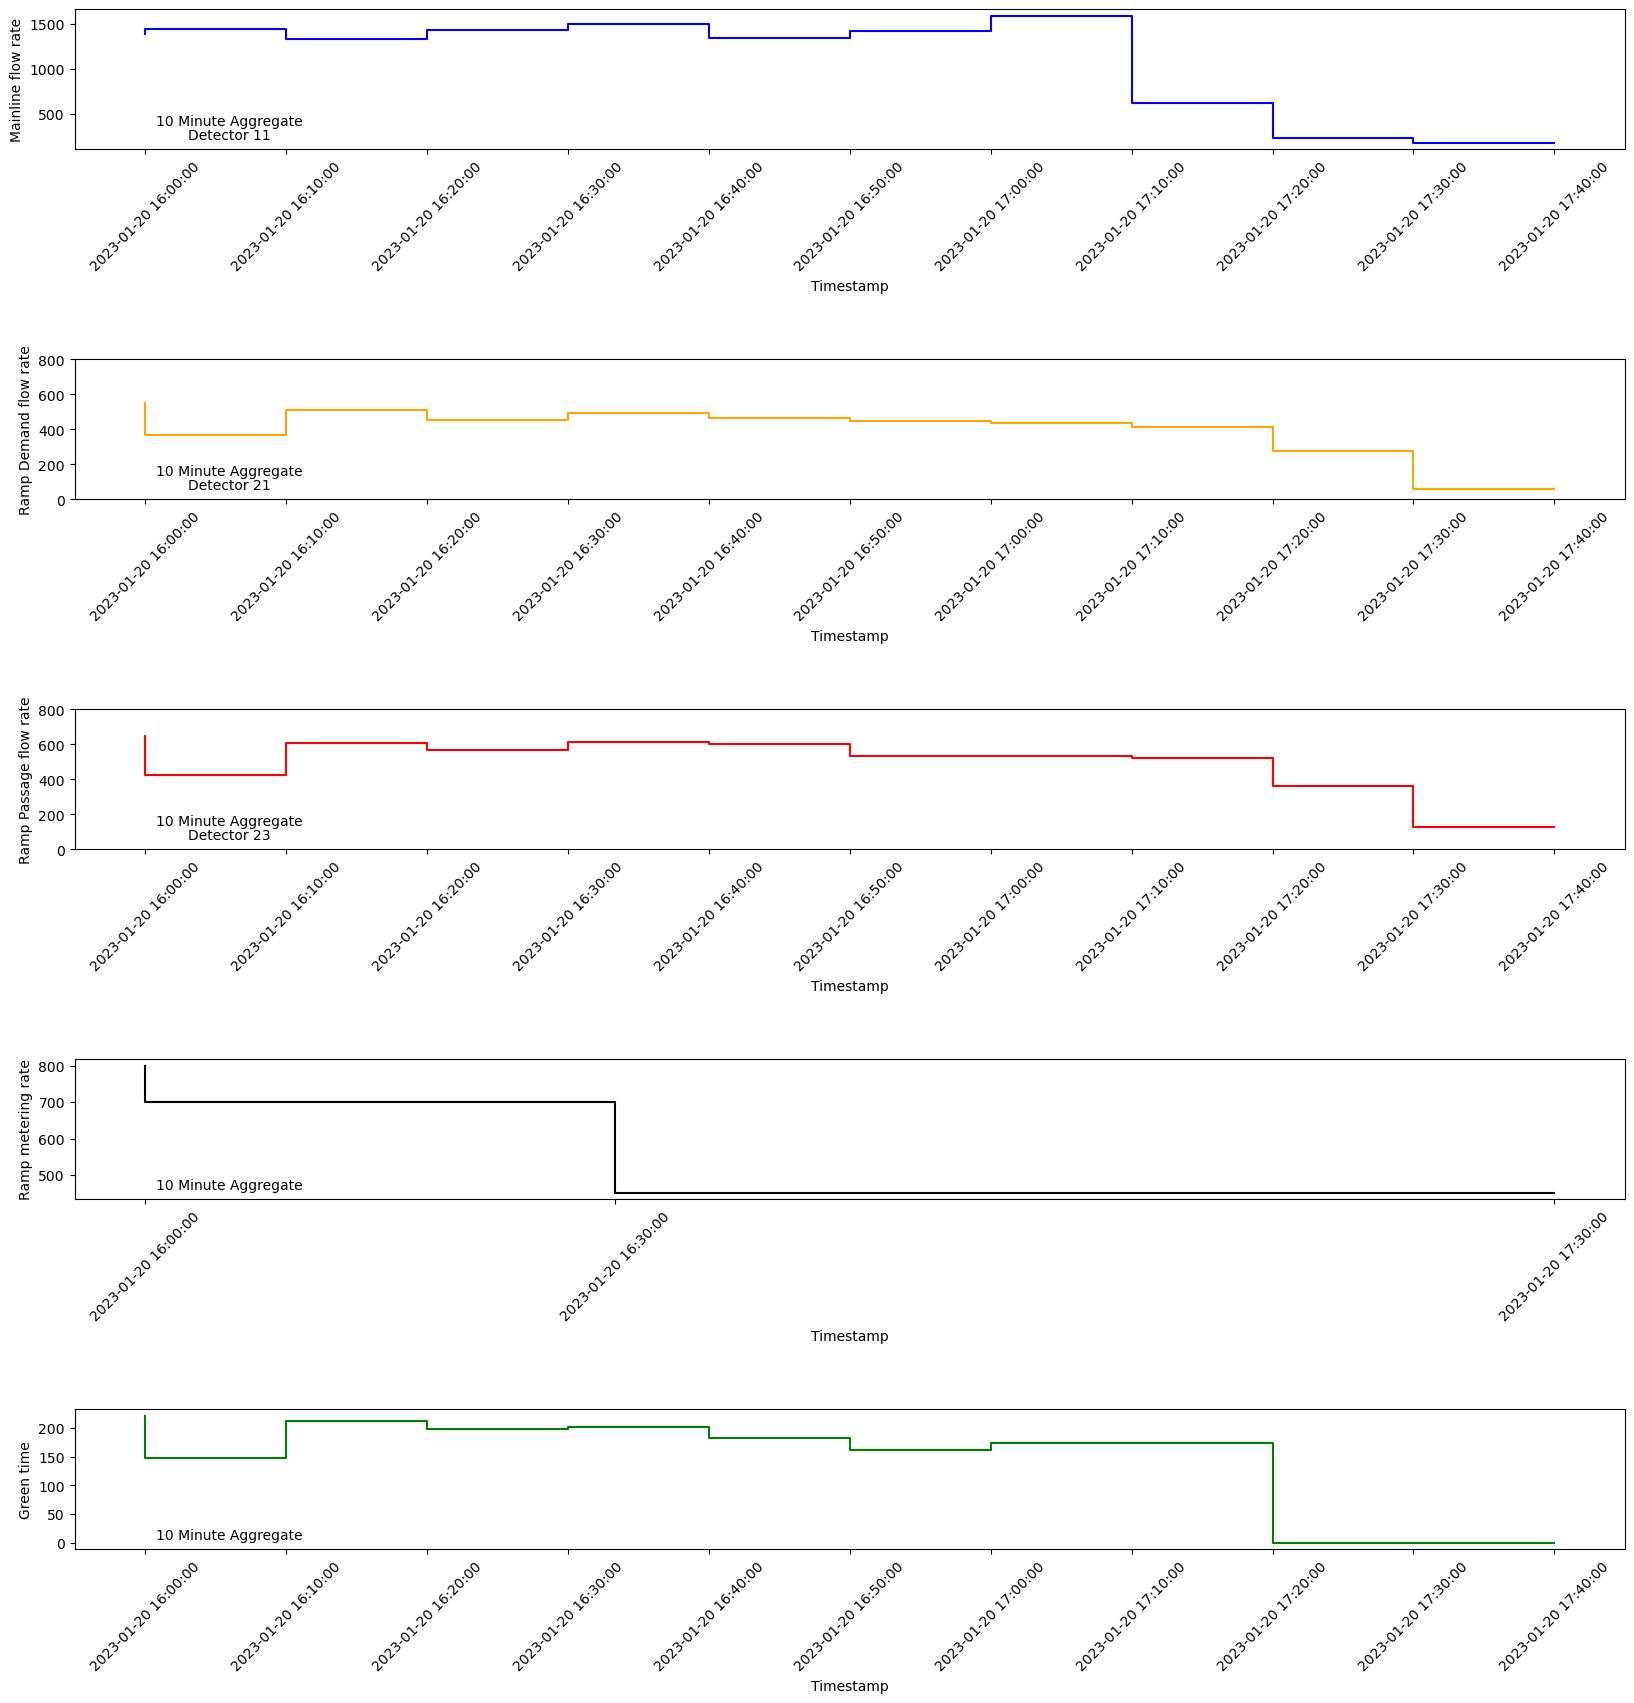

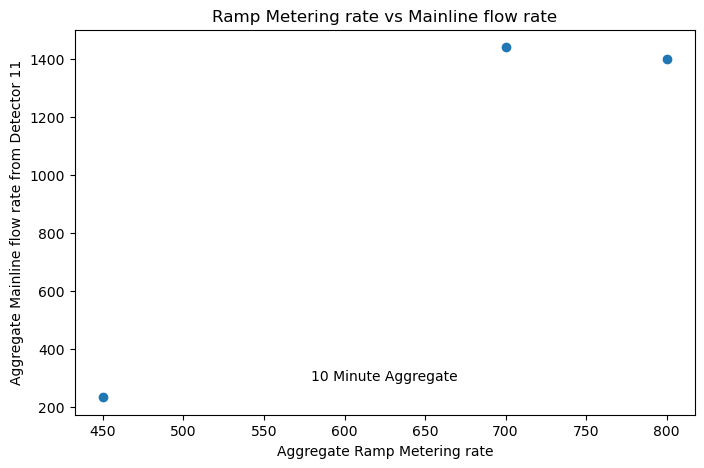

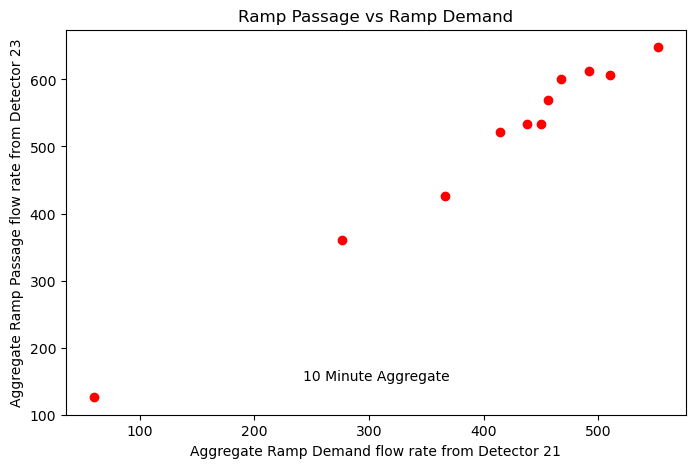

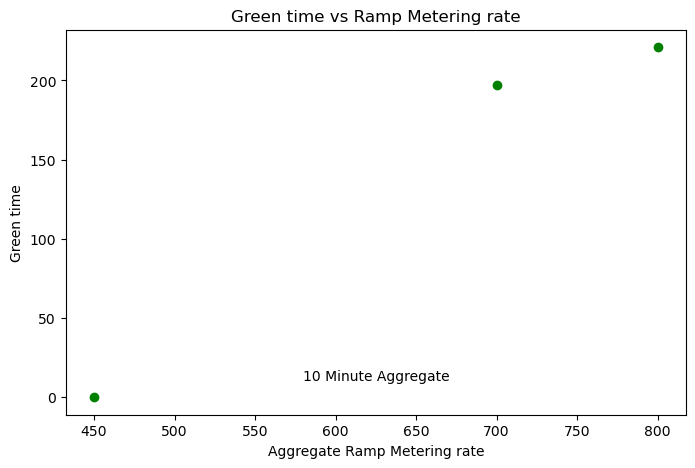

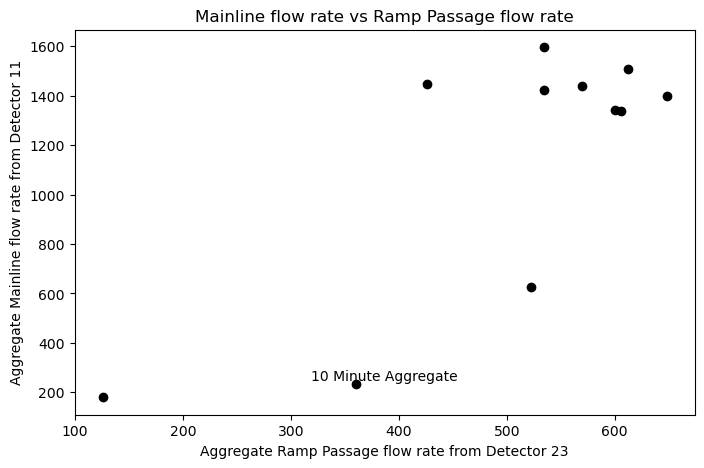




*************************************15 Minute Aggregate******************************


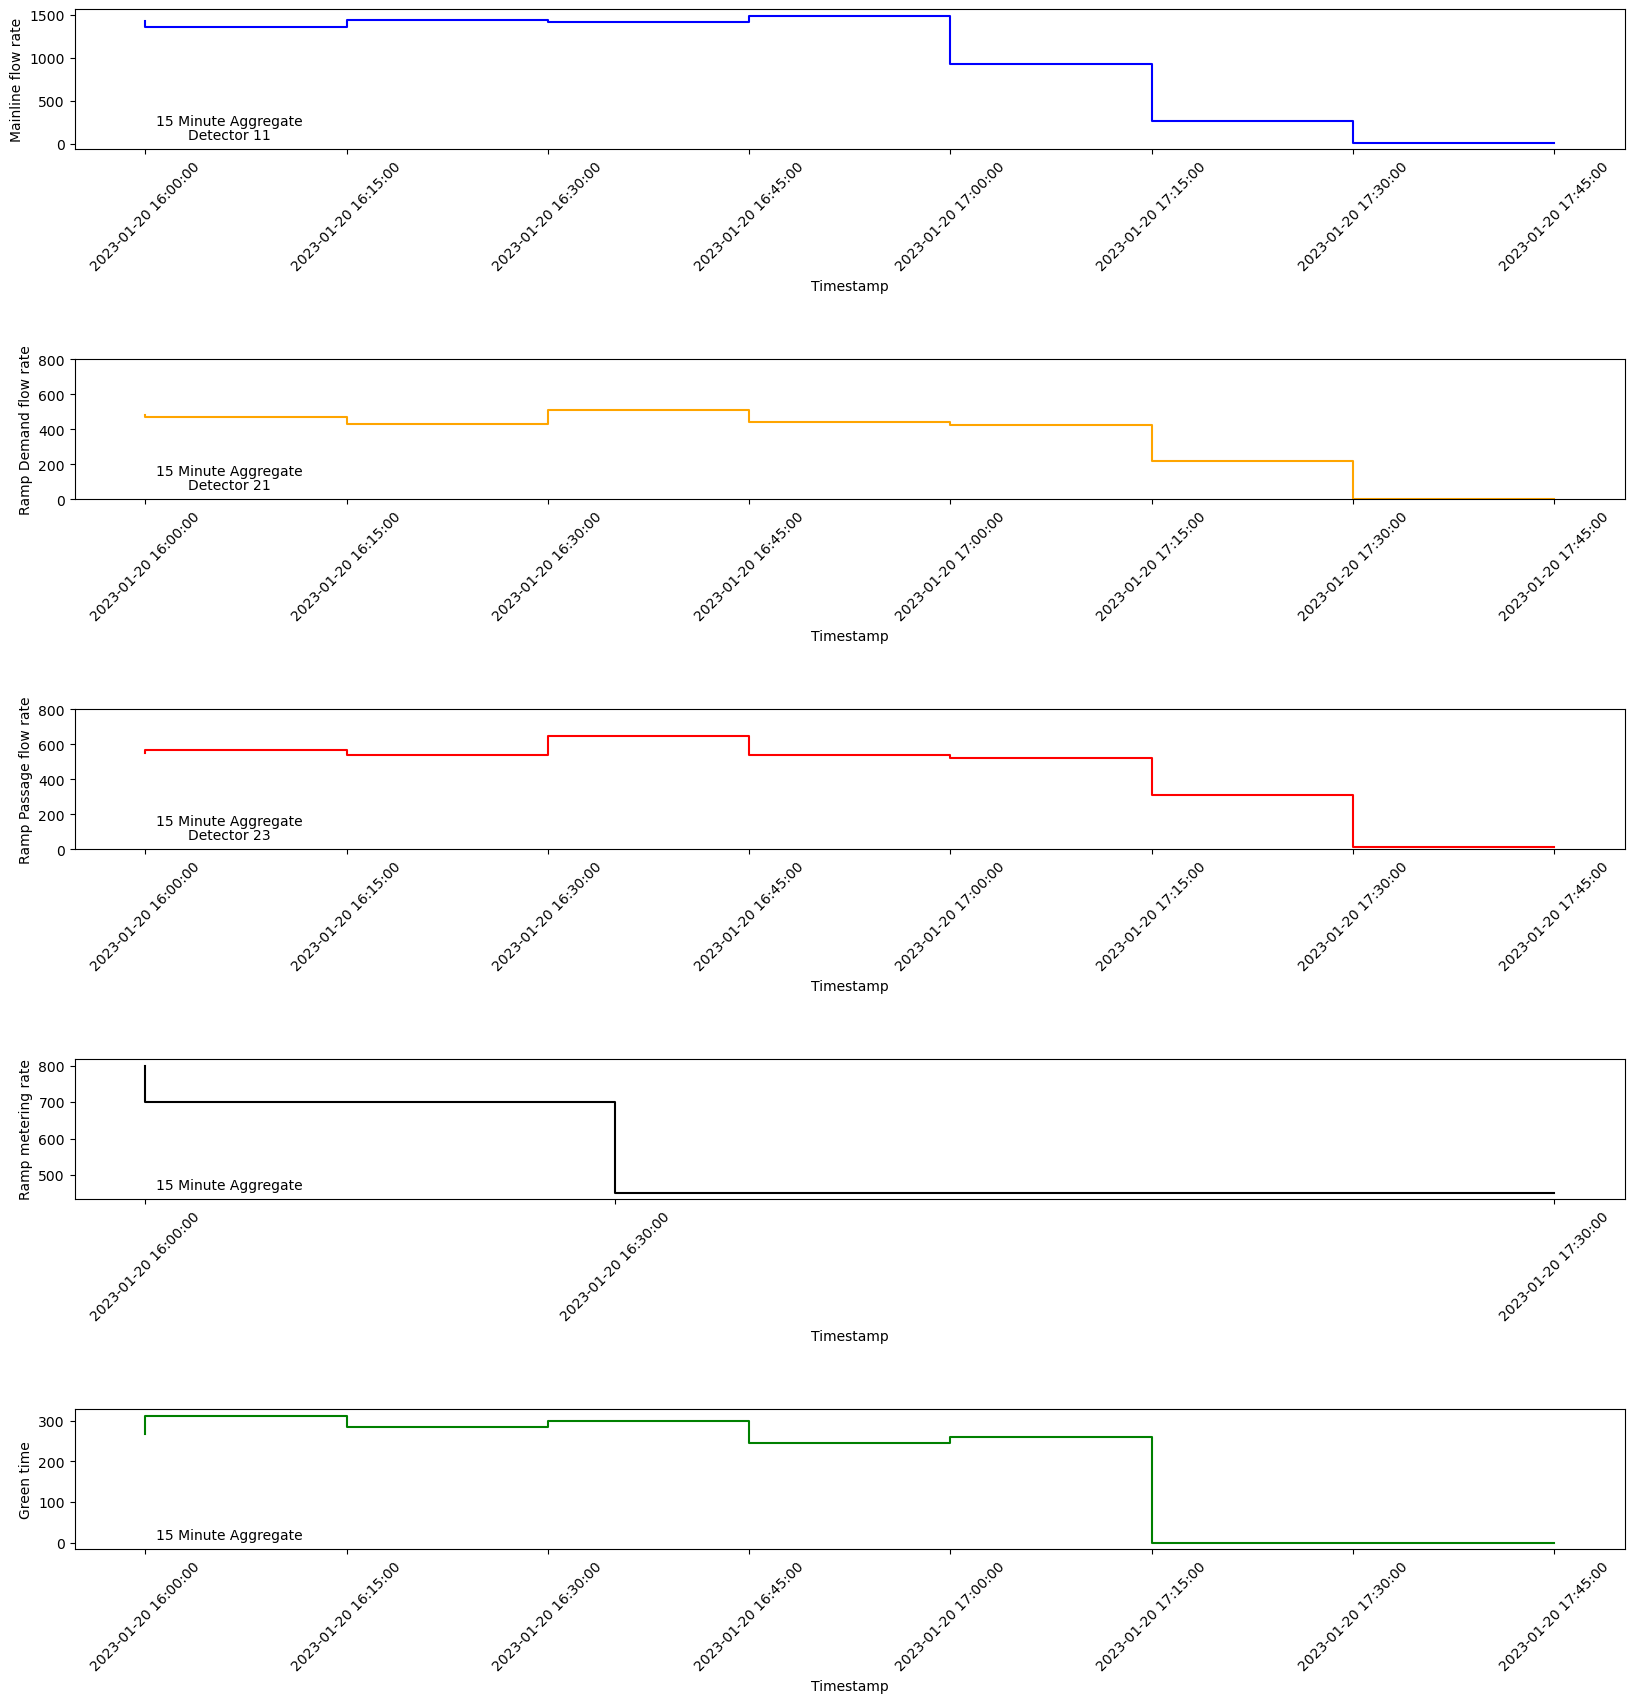

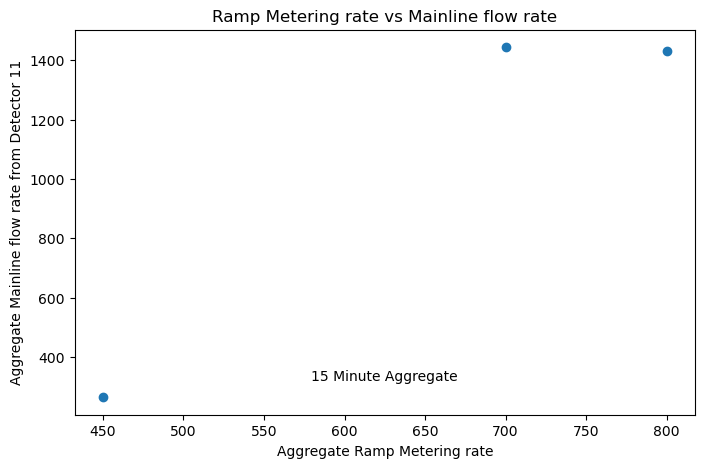

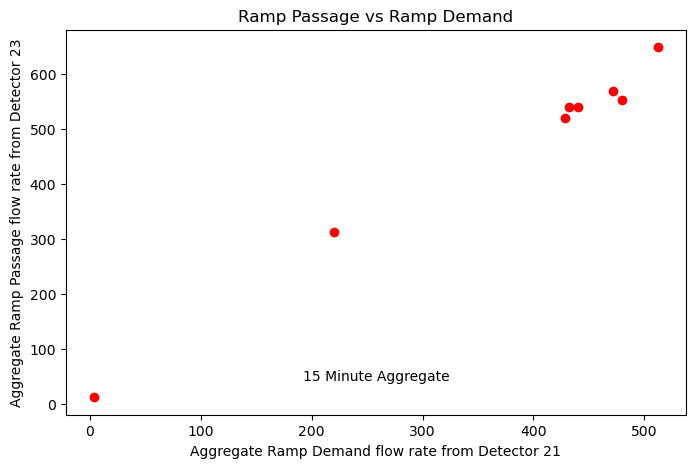

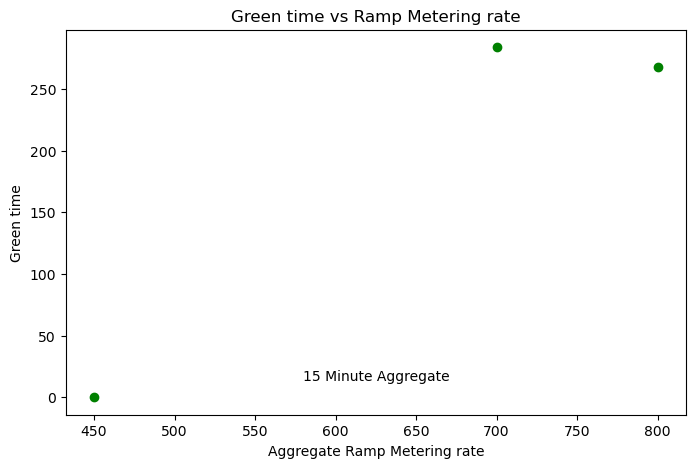

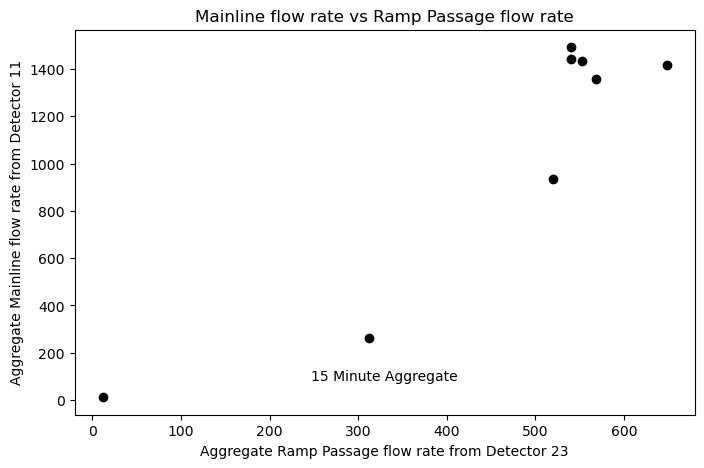




*************************************30 Minute Aggregate******************************


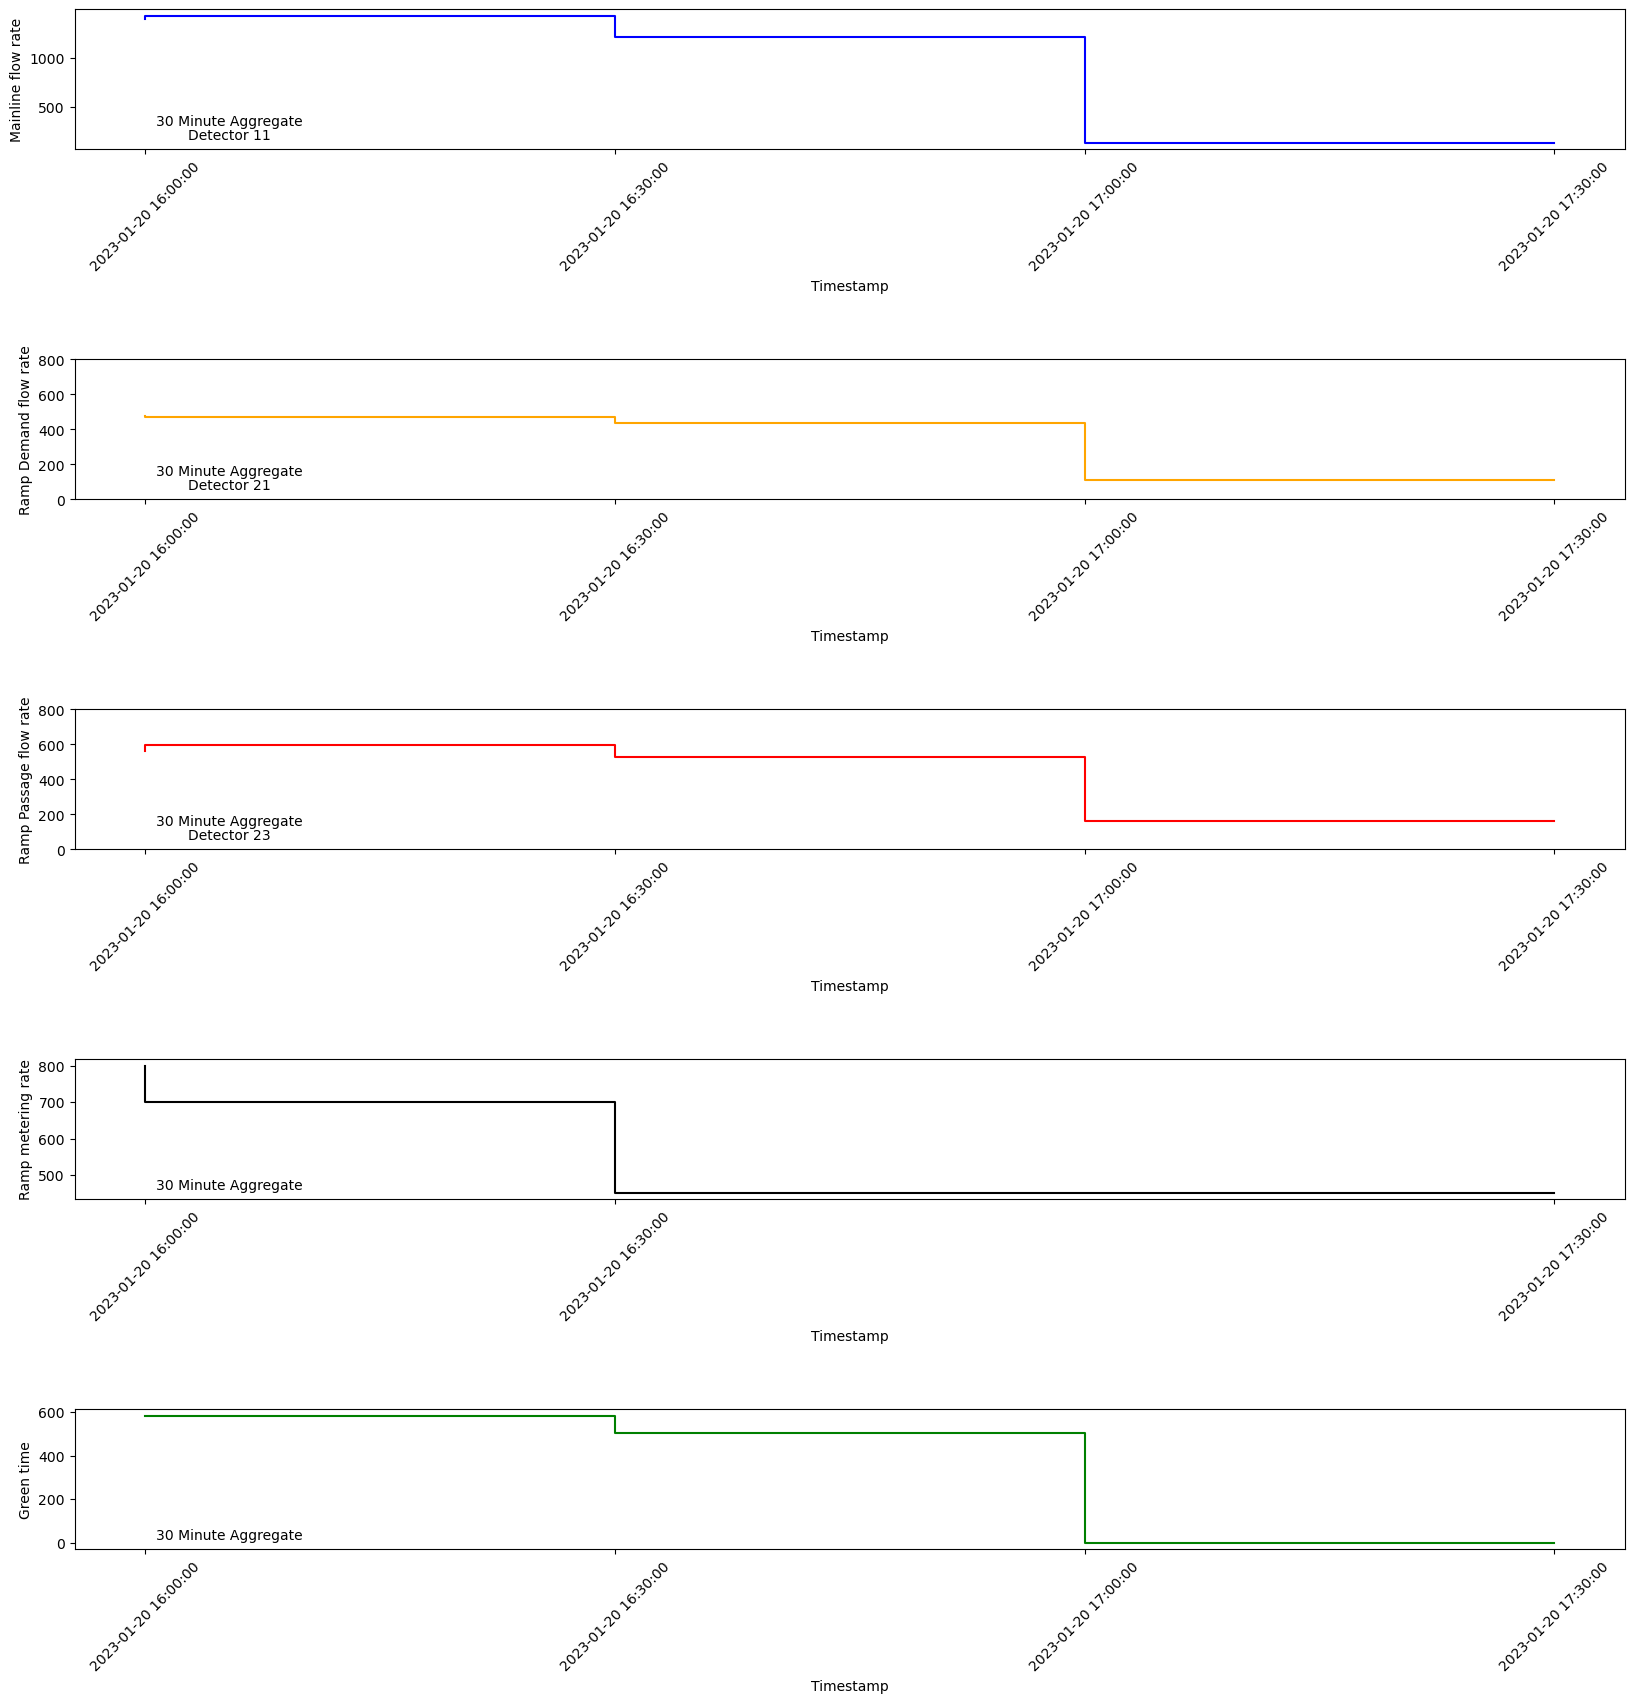

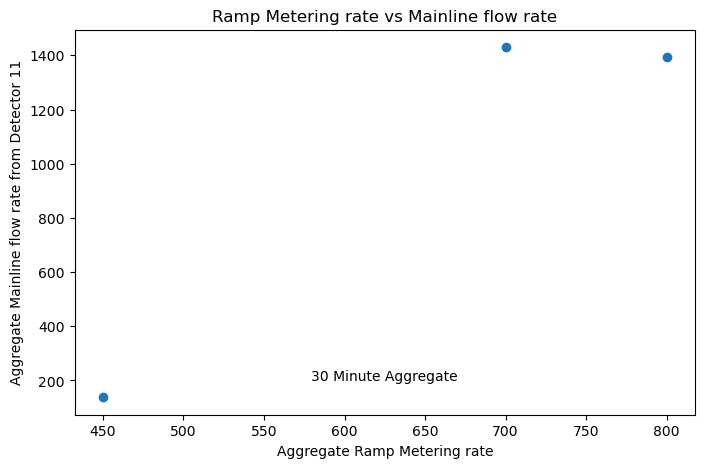

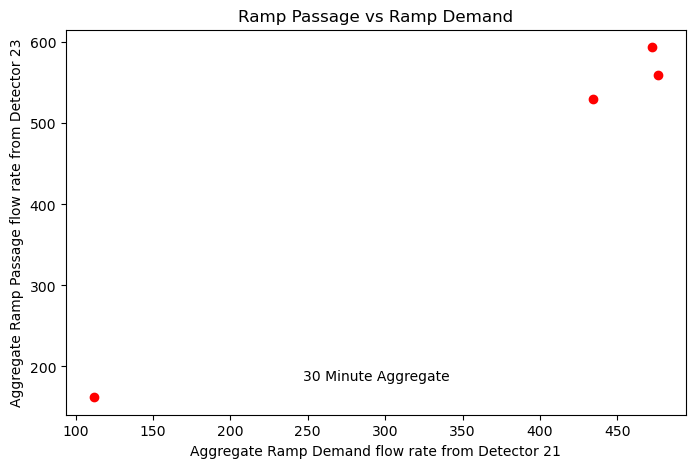

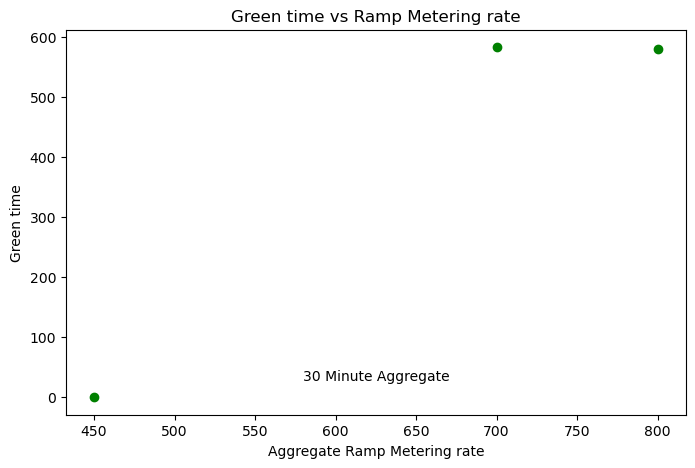

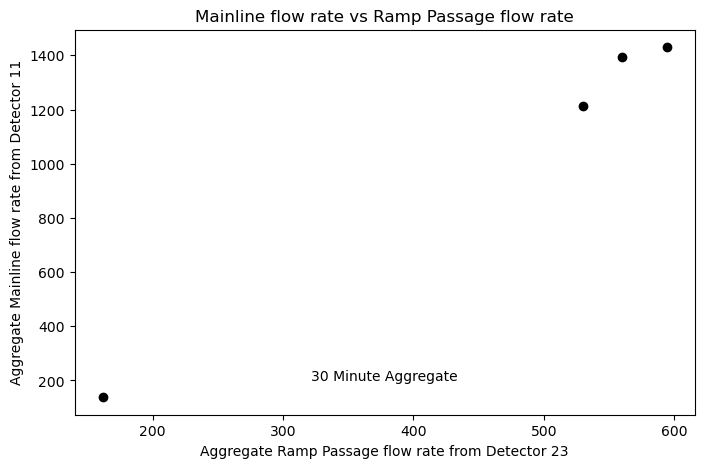

In [53]:
for i in [5,10,15,30]:
    plot_function(df_event_detail,i)

# Location: Palmetto 202

In [54]:
file_name = './2023-01-10 Palmetto 202/Data/202 Palmetto - Device Event Detail (raw data).xlsx'
xl_file = pd.ExcelFile(file_name)

dfs = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}
df_event_detail = dfs['Data']
df_event_detail = df_event_detail.drop(axis=1, columns=[' '])
dict1 = {}
for column in df_event_detail.columns:
    dict1[column] = column.strip()
df_event_detail = df_event_detail.rename(columns=dict1)

df_event_detail['Timestamp'] = df_event_detail['Timestamp'].apply(lambda x: x.strip())
df_event_detail['Category'] = df_event_detail['Category'].apply(lambda x: x.strip())
df_event_detail['Type'] = df_event_detail['Type'].apply(lambda x: x.strip())
df_event_detail['Timestamp'] = pd.to_datetime(df_event_detail['Timestamp'])
df_event_detail = df_event_detail.rename(columns={'Event Value':'Event_value'})

In [55]:
df_event_detail

Timestamp         Category          Type  Event_value
0     2023-01-10 17:31:20.200  Detector Events   Detector On           12
1     2023-01-10 17:31:20.200  Detector Events   Detector On           14
2     2023-01-10 17:31:20.100  Detector Events  Detector Off            3
3     2023-01-10 17:31:20.000  Detector Events   Detector On            4
4     2023-01-10 17:31:17.600  Detector Events   Detector On           13
...                       ...              ...           ...          ...
32385 2023-01-10 15:59:19.900  Detector Events   Detector On            4
32386 2023-01-10 15:59:19.700  Detector Events   Detector On           31
32387 2023-01-10 15:59:19.600  Detector Events   Detector On           23
32388 2023-01-10 15:59:19.500  Detector Events  Detector Off           23
32389 2023-01-10 15:59:19.300  Detector Events  Detector Off           14

[32390 rows x 4 columns]

*************************************5 Minute Aggregate******************************


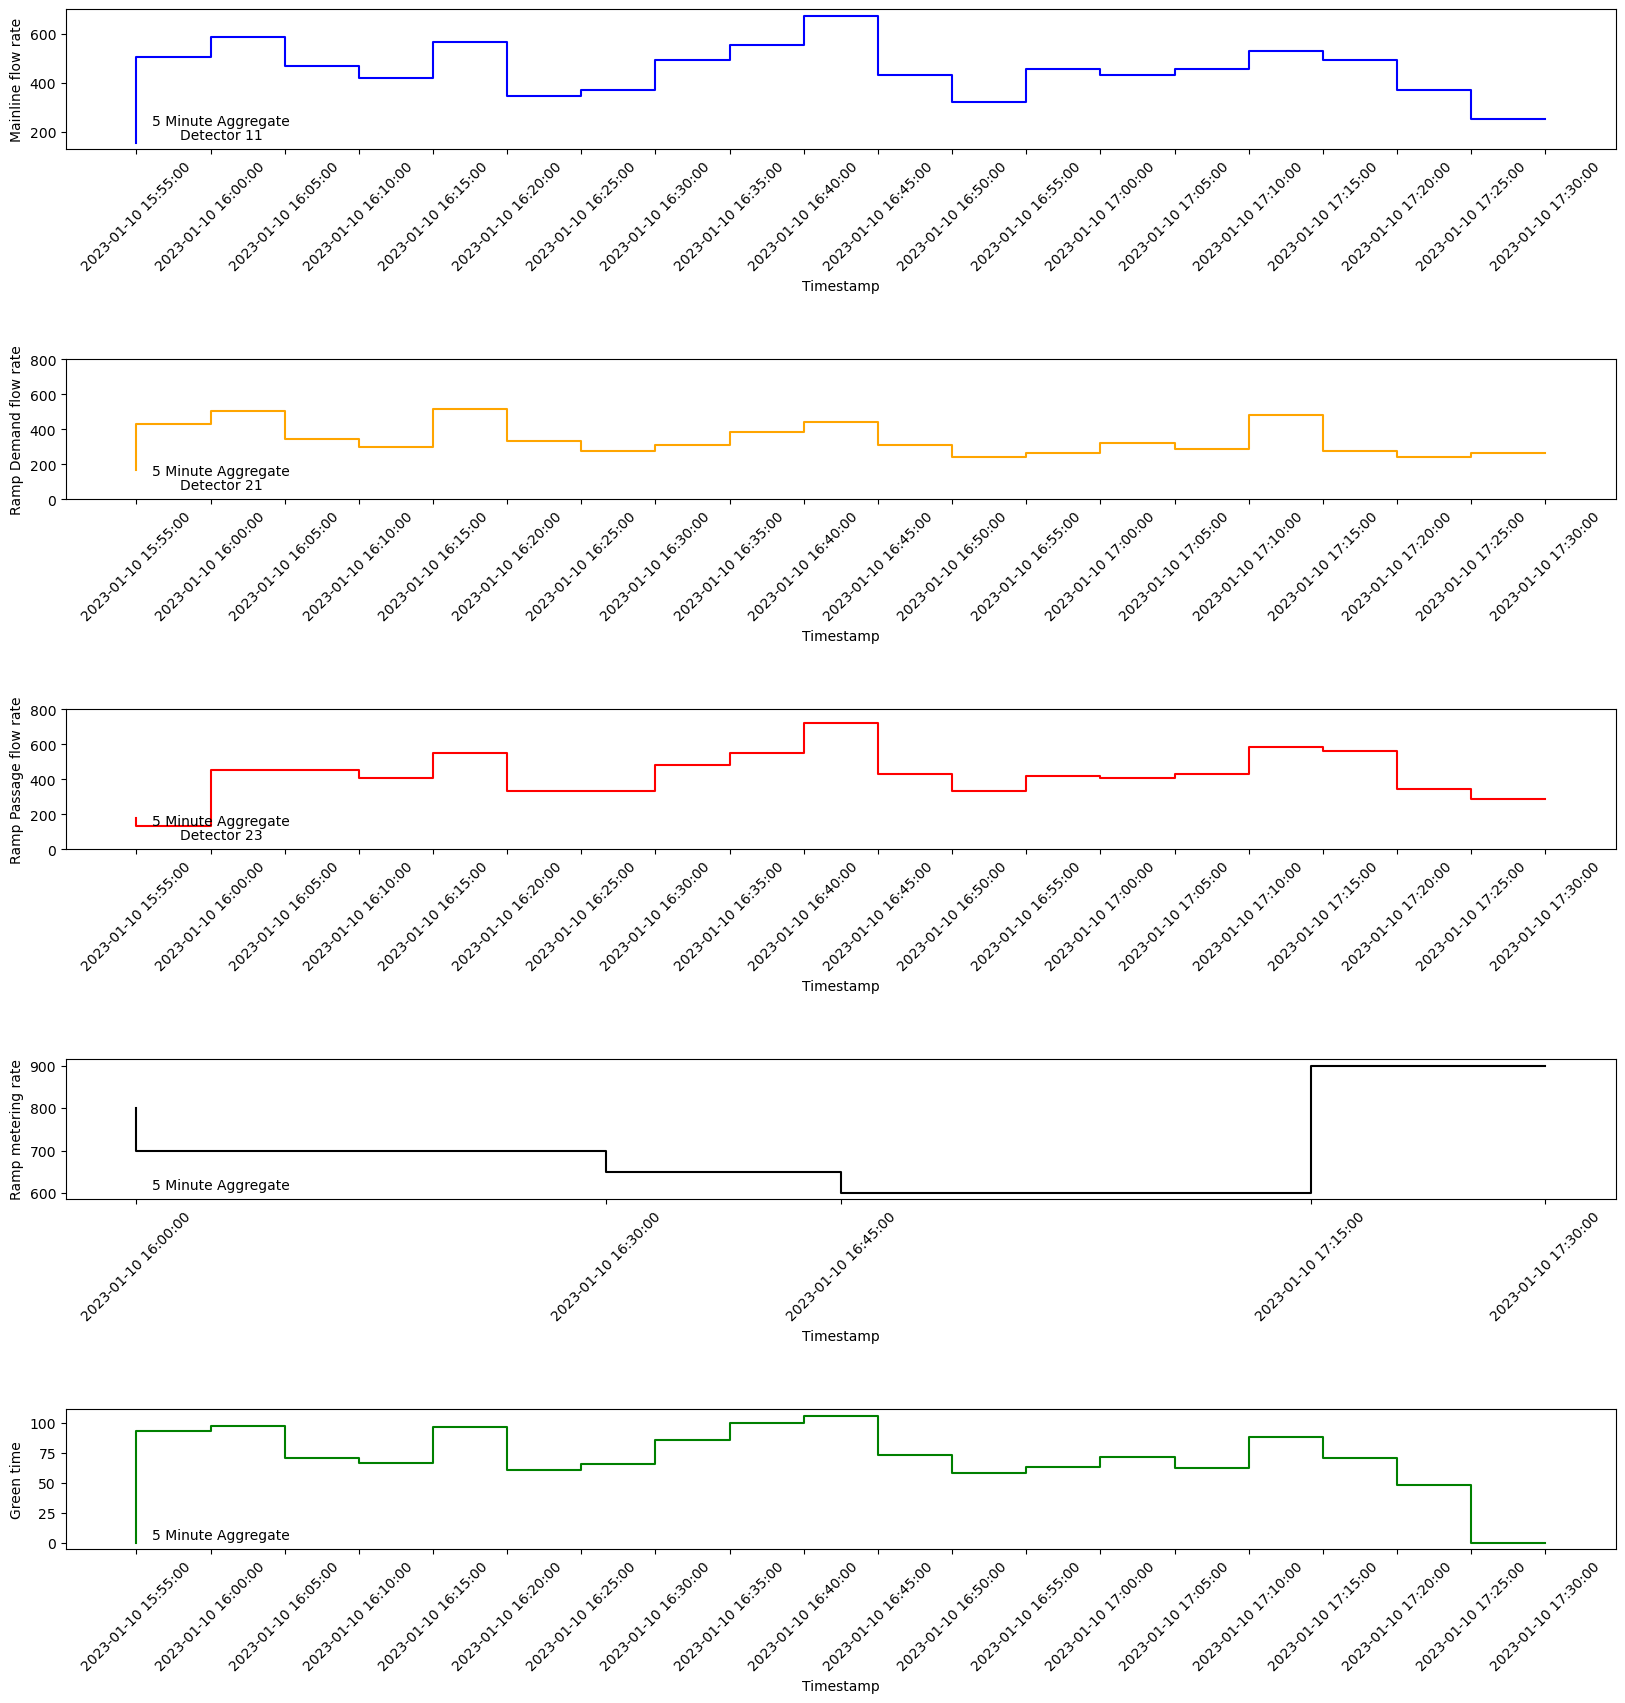

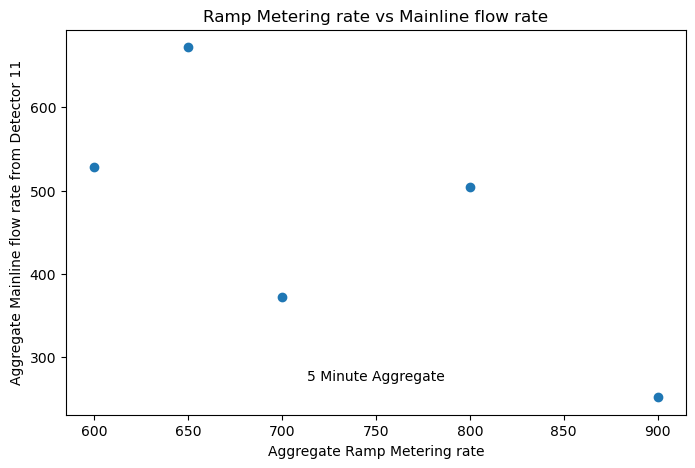

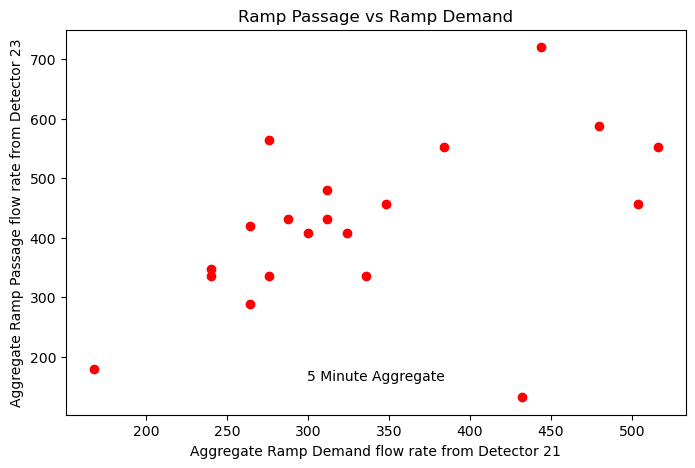

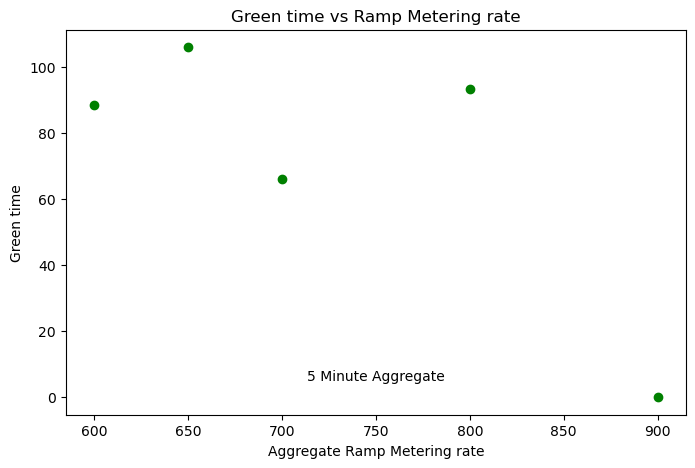

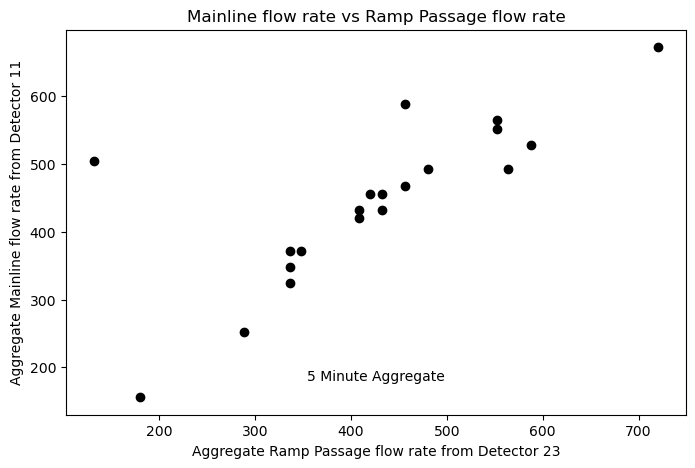




*************************************10 Minute Aggregate******************************


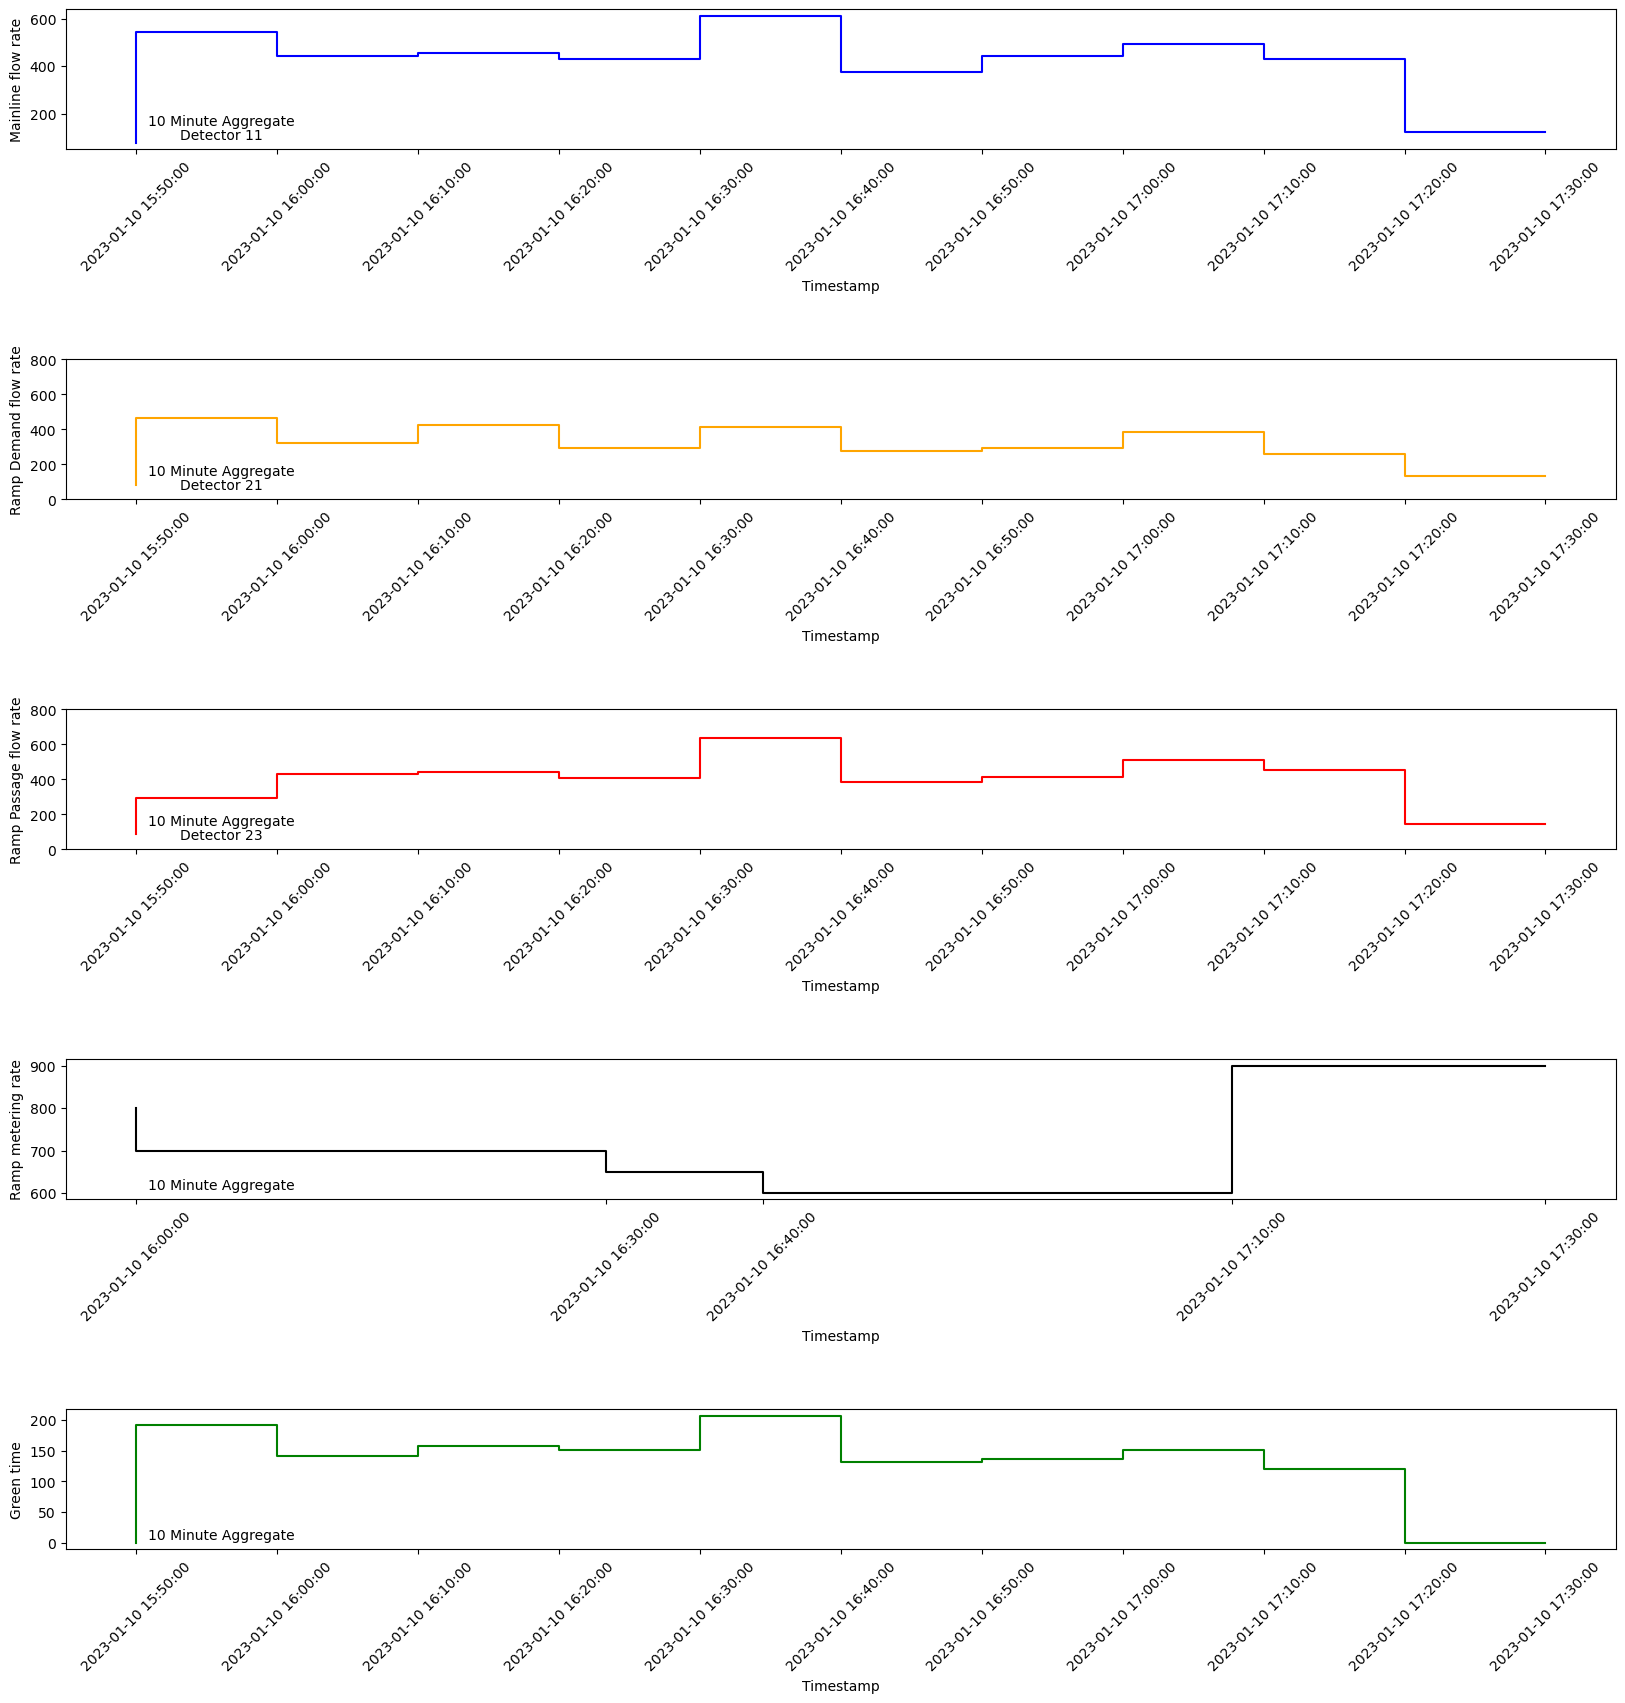

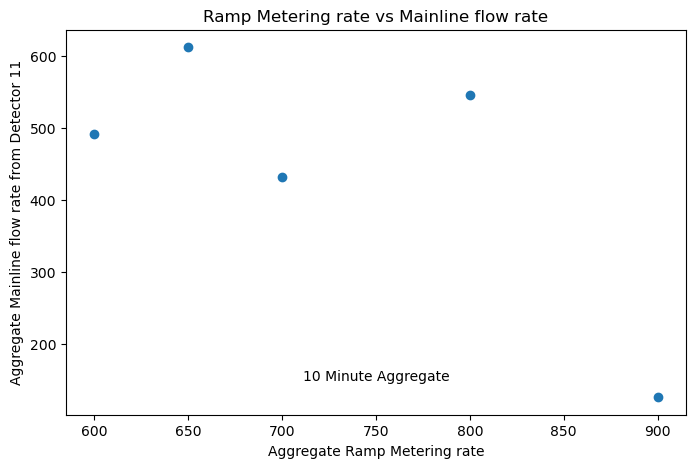

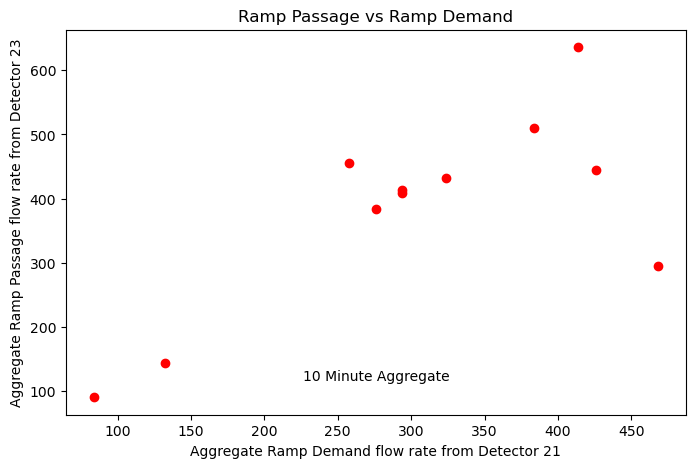

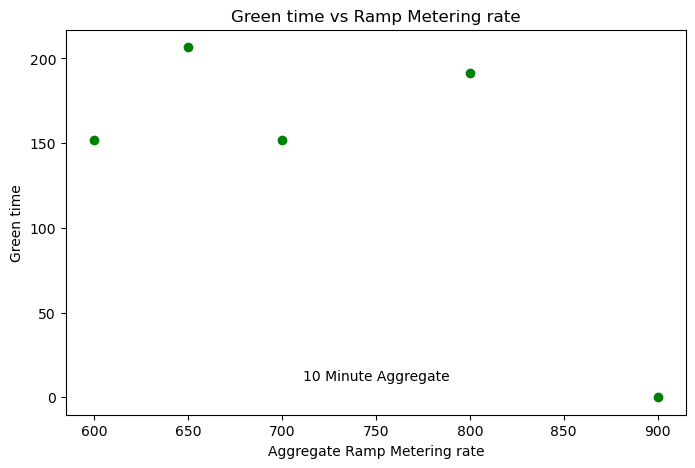

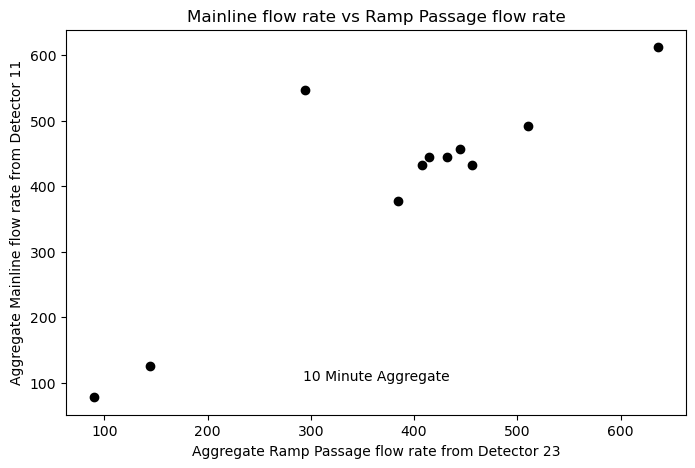




*************************************15 Minute Aggregate******************************


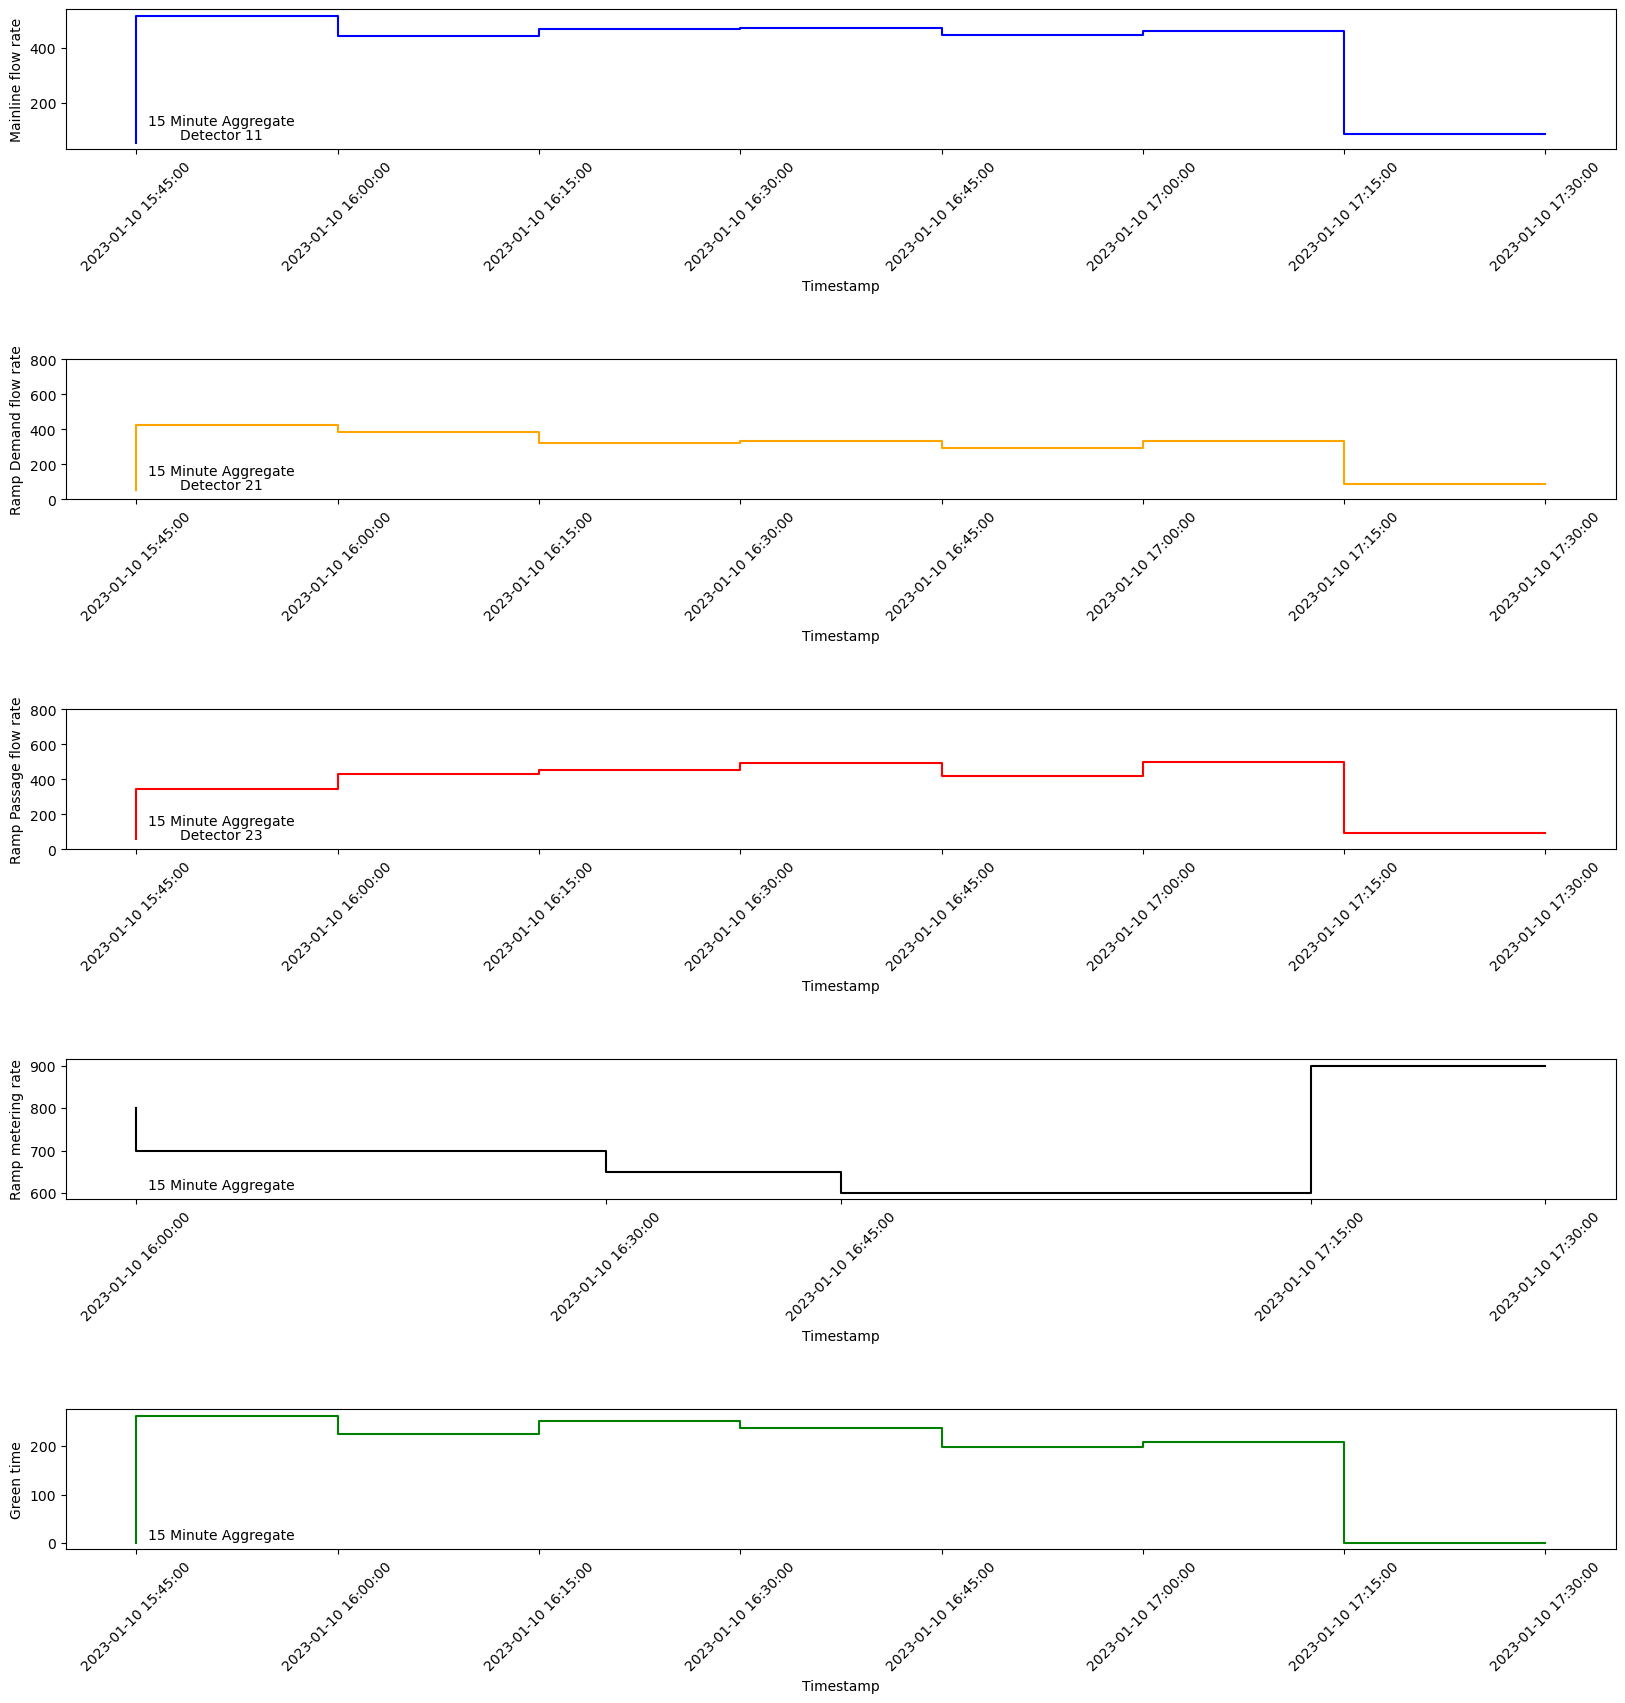

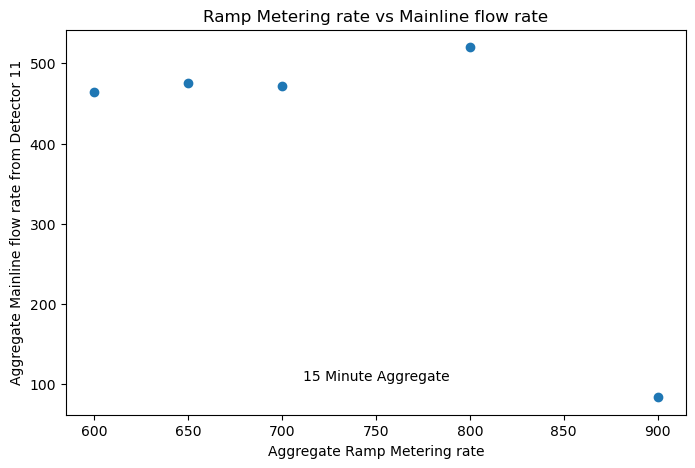

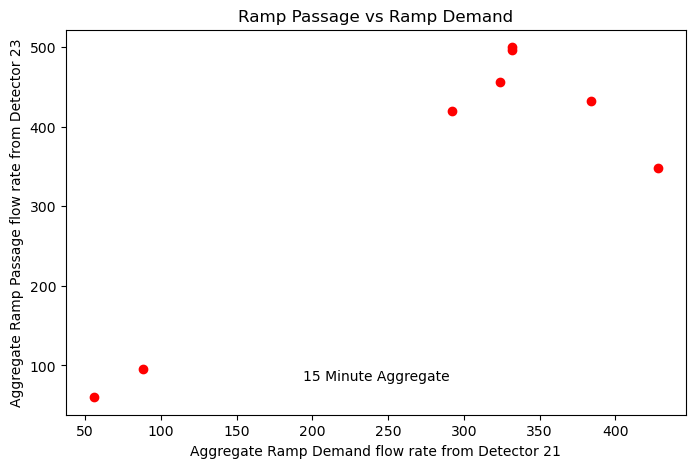

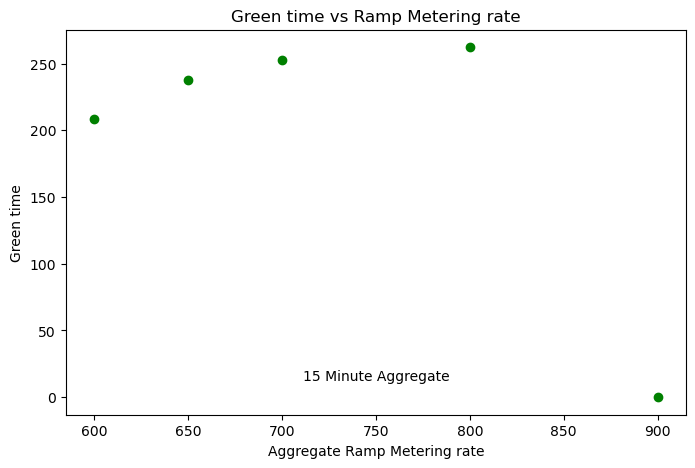

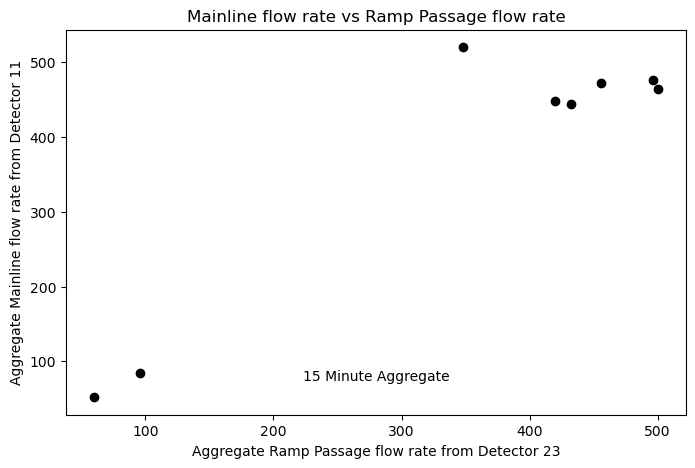




*************************************30 Minute Aggregate******************************


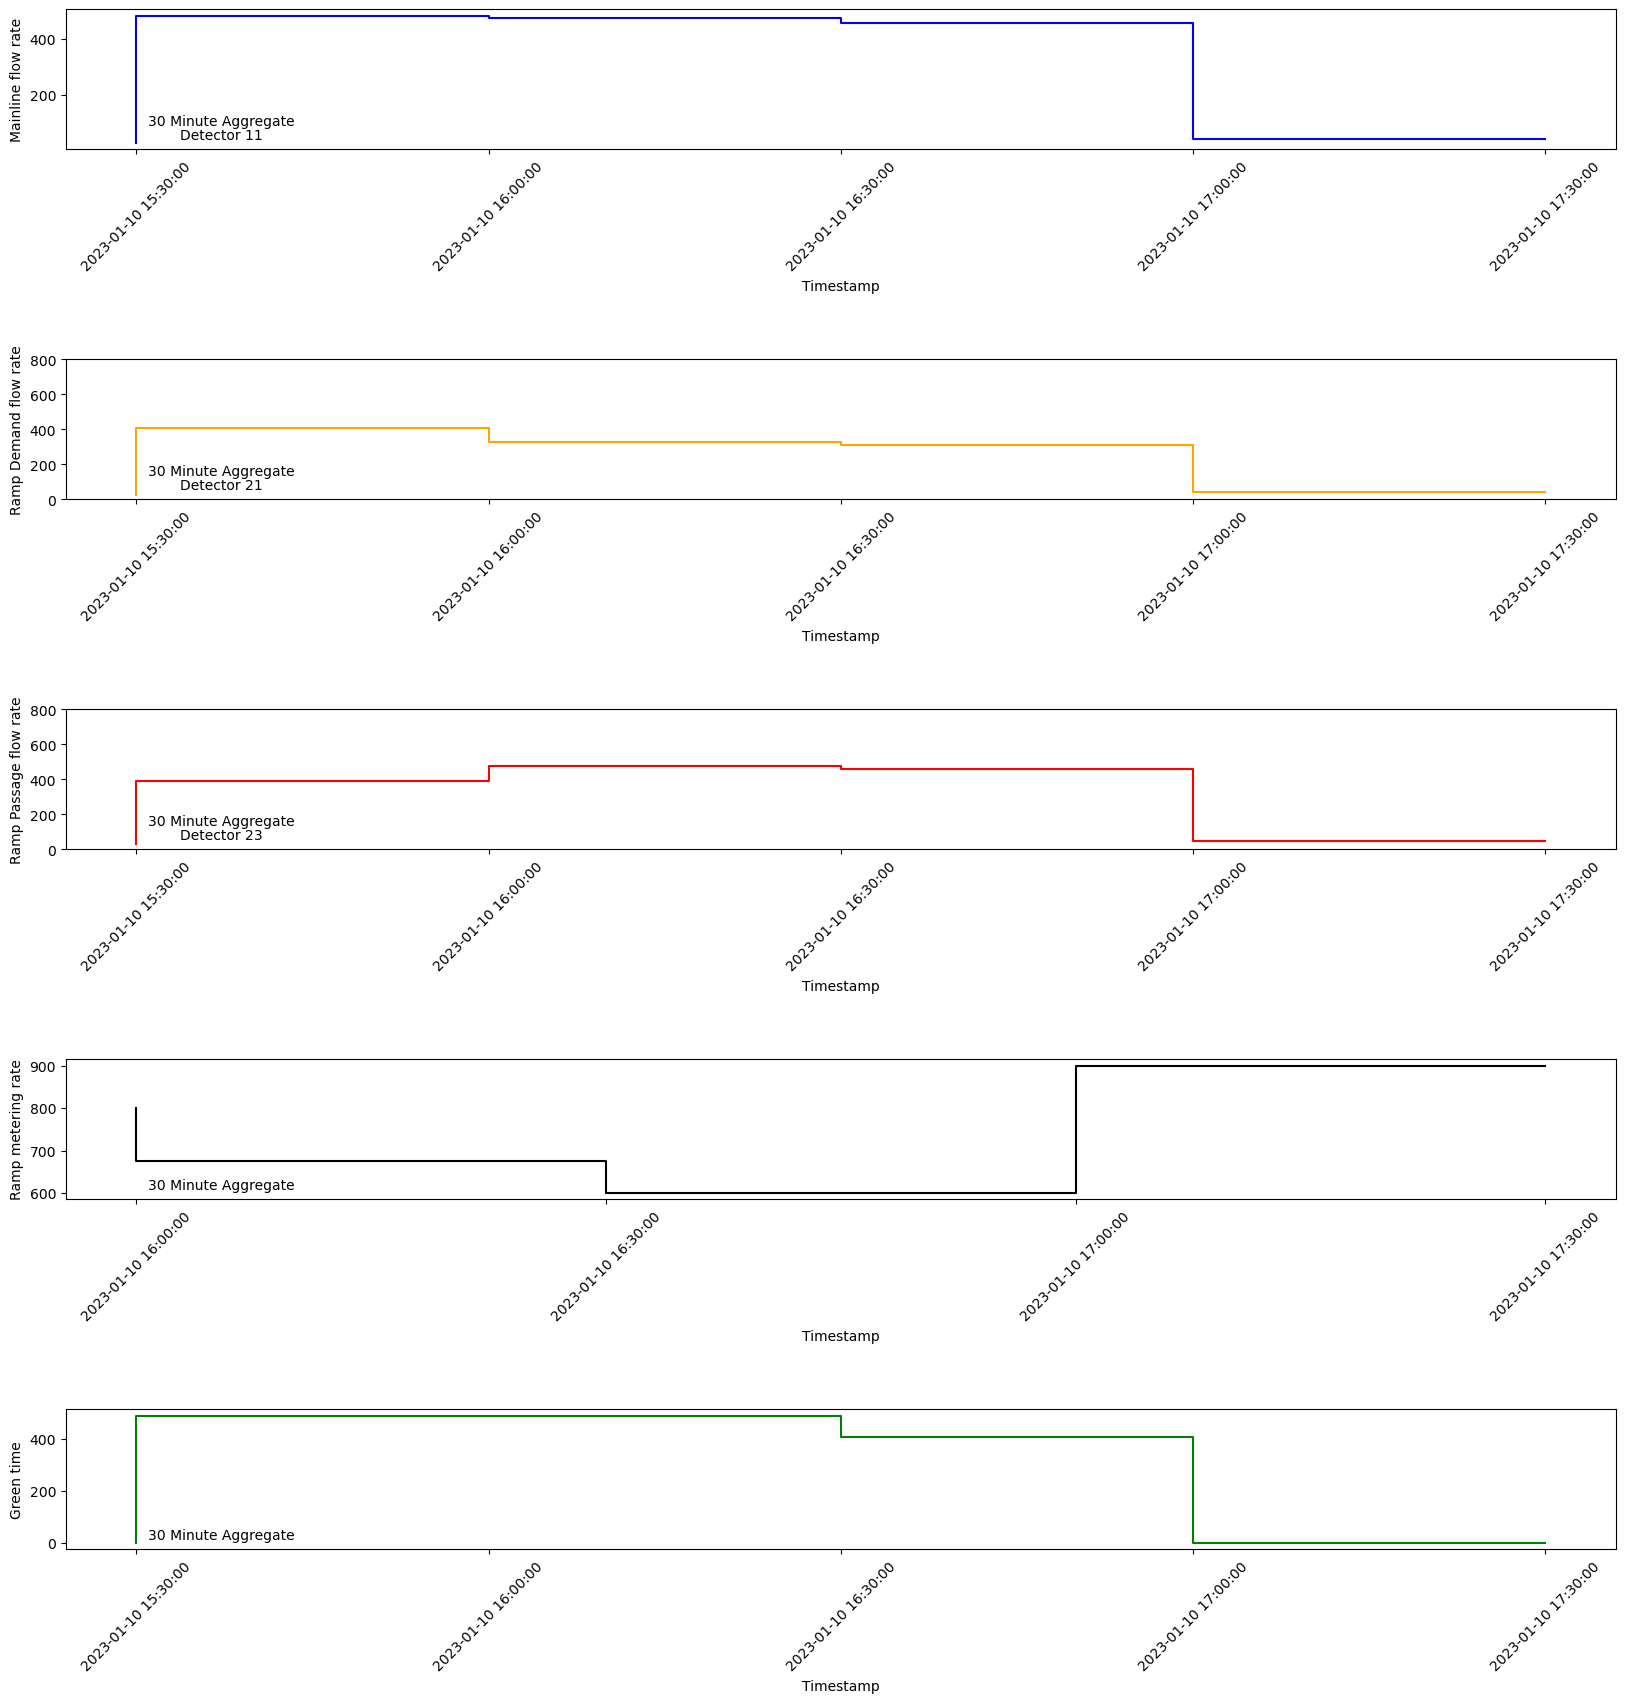

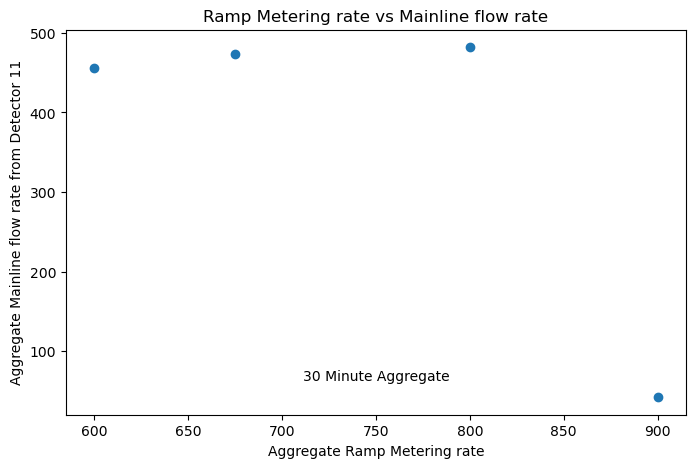

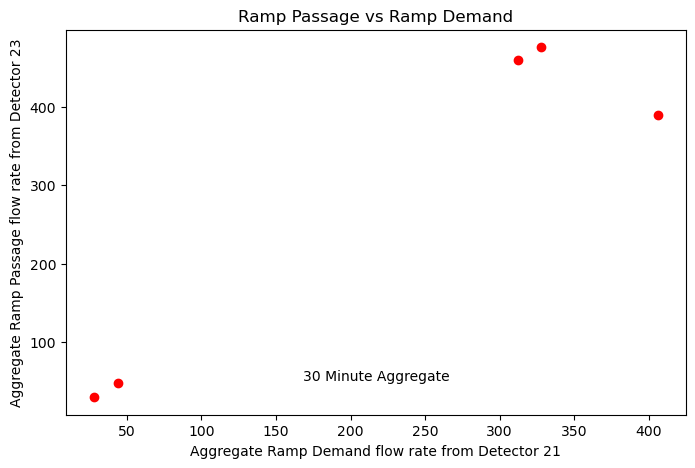

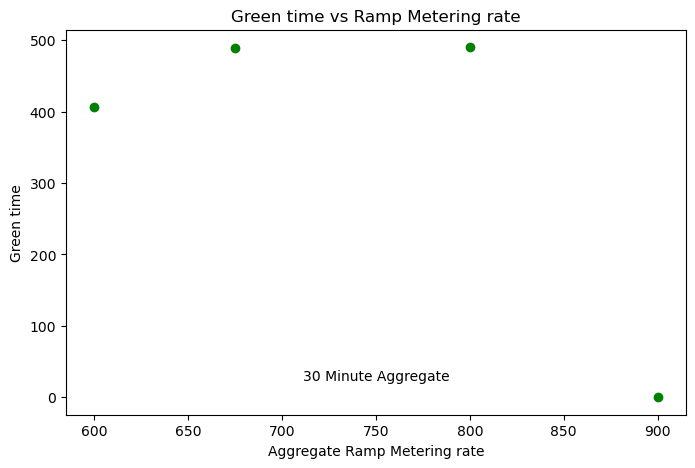

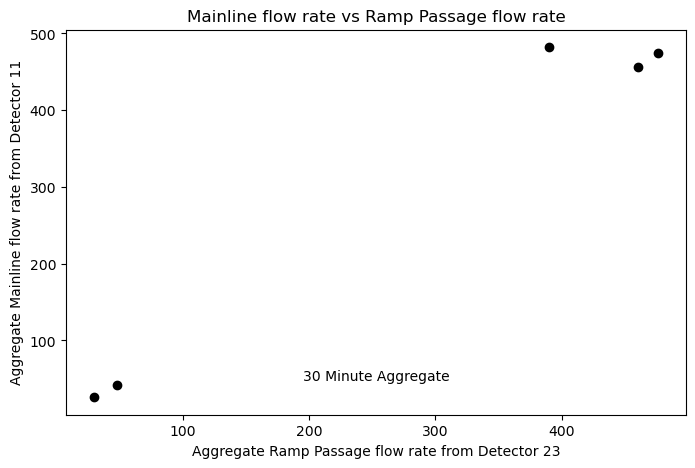

In [56]:
for i in [5,10,15,30]:
    plot_function(df_event_detail,i)